天医二院

Calculating ROC, AUC, and 95% CI for each class...
- Right Coronary Artery: AUC=0.714 (95% CI: 0.691-0.738)
- Left Main Artery: AUC=0.713 (95% CI: 0.640-0.785)
- Left Anterior Descending: AUC=0.700 (95% CI: 0.678-0.721)
- Left Circumflex: AUC=0.673 (95% CI: 0.645-0.698)


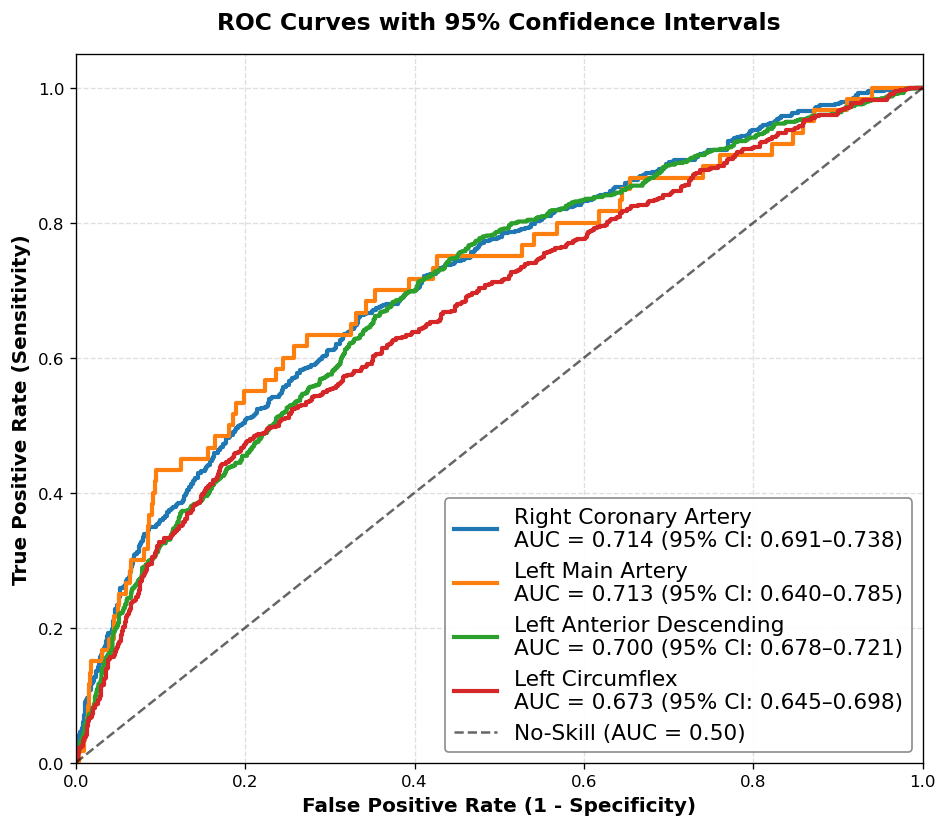

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np

# ===================================================================
# 1. 配置区
# ===================================================================

RESULTS_CSV_PATH = '/data2/2shared/xiaoyujie/冠脉造影/final/tyey_pred.csv'

LABEL_COLUMN_NAMES = [
    '右冠状动脉_检查结果', 
    '左冠状动脉主干_检查结果', 
    '左前降支_检查结果', 
    '左回旋支_检查结果'
]

PROB_COLUMN_NAMES = [
    '右冠状动脉_prob', 
    '左冠状动脉主干_prob', 
    '左前降支_prob', 
    '左回旋支_prob'
]

CLASS_NAMES_ENGLISH = [
    'Right Coronary Artery',
    'Left Main Artery',
    'Left Anterior Descending',
    'Left Circumflex'
]

NEGATIVE_CLASS_STRINGS_LIST = ["未见明显狭窄","轻度狭窄","中度狭窄"]

# Bootstrapping 配置
N_BOOTSTRAPS = 1000  # 重采样次数
CI_ALPHA = 0.95      # 置信度 (95%)
SEED = 42            # 随机种子

# ===================================================================
# 2. 辅助函数：计算 AUC CI
# ===================================================================

def calculate_auc_ci(y_true, y_scores, n_bootstraps=1000, alpha=0.95, rng_seed=42):
    """
    使用 Bootstrapping 计算 ROC-AUC 的置信区间
    """
    bootstrapped_scores = []
    rng = np.random.RandomState(rng_seed)
    
    for i in range(n_bootstraps):
        # 有放回重采样索引
        indices = rng.randint(0, len(y_scores), len(y_scores))
        if len(np.unique(y_true.iloc[indices])) < 2:
            # 如果重采样样本中只有一类，跳过此次（虽少见但可能发生）
            continue
            
        score = auc(*roc_curve(y_true.iloc[indices], y_scores.iloc[indices])[:2])
        bootstrapped_scores.append(score)
        
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    # 计算分位数
    lower_bound = np.percentile(sorted_scores, (1 - alpha) / 2 * 100)
    upper_bound = np.percentile(sorted_scores, (1 + alpha) / 2 * 100)
    
    return lower_bound, upper_bound

# ===================================================================
# 3. 数据加载和处理
# ===================================================================

df = pd.read_csv(RESULTS_CSV_PATH)

roc_results = {}

print("Calculating ROC, AUC, and 95% CI for each class...")

for i in range(len(LABEL_COLUMN_NAMES)):
    label_col = LABEL_COLUMN_NAMES[i]
    prob_col = PROB_COLUMN_NAMES[i]
    class_name = CLASS_NAMES_ENGLISH[i]

    if label_col not in df.columns or prob_col not in df.columns:
        continue

    temp_df = df[[label_col, prob_col]].dropna()
    y_true = temp_df[label_col].apply(lambda x: 0 if x in NEGATIVE_CLASS_STRINGS_LIST else 1)
    y_scores = temp_df[prob_col]

    if len(np.unique(y_true)) < 2:
        continue

    # 1. 计算基础指标
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # 2. 计算置信区间 (CI)
    ci_lower, ci_upper = calculate_auc_ci(y_true, y_scores, n_bootstraps=N_BOOTSTRAPS, alpha=CI_ALPHA, rng_seed=SEED)

    roc_results[class_name] = {
        'fpr': fpr, 
        'tpr': tpr, 
        'auc': roc_auc,
        'ci_low': ci_lower,
        'ci_high': ci_upper
    }
    
    print(f"- {class_name}: AUC={roc_auc:.3f} (95% CI: {ci_lower:.3f}-{ci_upper:.3f})")

# ===================================================================
# 4. 绘图 (带 CI)
# ===================================================================

if not roc_results:
    print("\nNo valid data to plot. Exiting.")
    exit()

# 使用无衬线字体风格
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
fig, ax = plt.subplots(1, 1, figsize=(8, 7), dpi=120) # 稍微加大一点尺寸

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] # 经典配色

for idx, (class_name, results) in enumerate(roc_results.items()):
    auc_val = results['auc']
    ci_low = results['ci_low']
    ci_high = results['ci_high']
    color = colors[idx % len(colors)]
    
    # 格式化图例文字
    label_str = f"{class_name}\nAUC = {auc_val:.3f} (95% CI: {ci_low:.3f}–{ci_high:.3f})"
    
    ax.plot(
        results['fpr'], 
        results['tpr'], 
        lw=2.5,
        color=color,
        label=label_str
    )

# 绘制对角线
ax.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.6, label='No-Skill (AUC = 0.50)')

# 美化图表
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate (Sensitivity)', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves with 95% Confidence Intervals', fontsize=14, fontweight='bold', pad=15)

# 优化图例 (放在右下角，稍微调小字体以防遮挡)
ax.legend(loc="lower right", fontsize=13, frameon=True, framealpha=0.9, edgecolor='gray')

ax.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('/data2/2shared/xiaoyujie/冠脉造影/final/auc/Roc_b.png',dpi=900)
plt.show()

renmin

Calculating ROC, AUC, and 95% CI for each class...
- Right Coronary Artery: AUC=0.744 (95% CI: 0.726-0.762)
- Left Main Artery: AUC=0.706 (95% CI: 0.671-0.740)
- Left Anterior Descending: AUC=0.716 (95% CI: 0.700-0.732)
- Left Circumflex: AUC=0.736 (95% CI: 0.718-0.755)


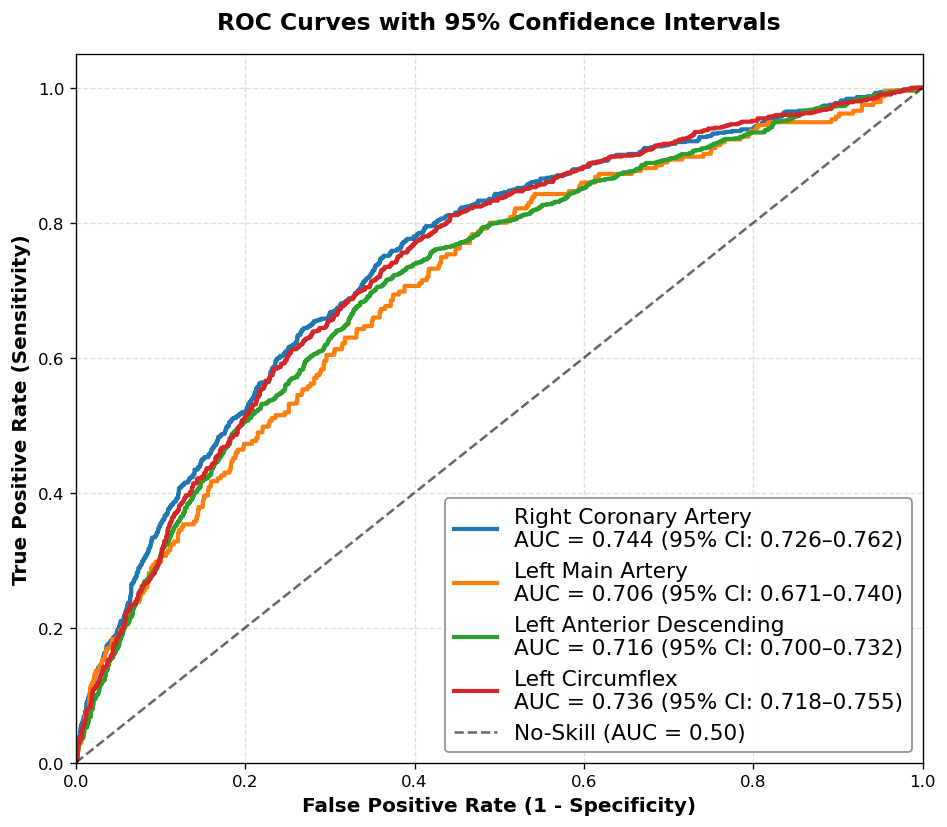

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np

# ===================================================================
# 1. 配置区
# ===================================================================

RESULTS_CSV_PATH = '/data2/2shared/xiaoyujie/冠脉造影/人民5折交叉验证/checkpoint_5fold_轻中度正常/oof_predictions_all_folds.csv'

LABEL_COLUMN_NAMES = [
    '右冠状动脉主干_诊断结果', 
    '左冠状动脉主干_诊断结果', 
    '左前降支_诊断结果', 
    '左回旋支_诊断结果'
]

PROB_COLUMN_NAMES = [
    '右冠状动脉主干_prob', 
    '左冠状动脉主干_prob', 
    '左前降支_prob', 
    '左回旋支_prob'
]

CLASS_NAMES_ENGLISH = [
    'Right Coronary Artery',
    'Left Main Artery',
    'Left Anterior Descending',
    'Left Circumflex'
]

NEGATIVE_CLASS_STRINGS_LIST = ["未见明显狭窄","轻度狭窄","中度狭窄"]

# Bootstrapping 配置
N_BOOTSTRAPS = 1000  # 重采样次数
CI_ALPHA = 0.95      # 置信度 (95%)
SEED = 42            # 随机种子

# ===================================================================
# 2. 辅助函数：计算 AUC CI
# ===================================================================

def calculate_auc_ci(y_true, y_scores, n_bootstraps=1000, alpha=0.95, rng_seed=42):
    """
    使用 Bootstrapping 计算 ROC-AUC 的置信区间
    """
    bootstrapped_scores = []
    rng = np.random.RandomState(rng_seed)
    
    for i in range(n_bootstraps):
        # 有放回重采样索引
        indices = rng.randint(0, len(y_scores), len(y_scores))
        if len(np.unique(y_true.iloc[indices])) < 2:
            # 如果重采样样本中只有一类，跳过此次（虽少见但可能发生）
            continue
            
        score = auc(*roc_curve(y_true.iloc[indices], y_scores.iloc[indices])[:2])
        bootstrapped_scores.append(score)
        
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    # 计算分位数
    lower_bound = np.percentile(sorted_scores, (1 - alpha) / 2 * 100)
    upper_bound = np.percentile(sorted_scores, (1 + alpha) / 2 * 100)
    
    return lower_bound, upper_bound

# ===================================================================
# 3. 数据加载和处理
# ===================================================================

df = pd.read_csv(RESULTS_CSV_PATH)

roc_results = {}

print("Calculating ROC, AUC, and 95% CI for each class...")

for i in range(len(LABEL_COLUMN_NAMES)):
    label_col = LABEL_COLUMN_NAMES[i]
    prob_col = PROB_COLUMN_NAMES[i]
    class_name = CLASS_NAMES_ENGLISH[i]

    if label_col not in df.columns or prob_col not in df.columns:
        continue

    temp_df = df[[label_col, prob_col]].dropna()
    y_true = temp_df[label_col].apply(lambda x: 0 if x in NEGATIVE_CLASS_STRINGS_LIST else 1)
    y_scores = temp_df[prob_col]

    if len(np.unique(y_true)) < 2:
        continue

    # 1. 计算基础指标
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # 2. 计算置信区间 (CI)
    ci_lower, ci_upper = calculate_auc_ci(y_true, y_scores, n_bootstraps=N_BOOTSTRAPS, alpha=CI_ALPHA, rng_seed=SEED)

    roc_results[class_name] = {
        'fpr': fpr, 
        'tpr': tpr, 
        'auc': roc_auc,
        'ci_low': ci_lower,
        'ci_high': ci_upper
    }
    
    print(f"- {class_name}: AUC={roc_auc:.3f} (95% CI: {ci_lower:.3f}-{ci_upper:.3f})")

# ===================================================================
# 4. 绘图 (带 CI)
# ===================================================================

if not roc_results:
    print("\nNo valid data to plot. Exiting.")
    exit()

# 使用无衬线字体风格
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
fig, ax = plt.subplots(1, 1, figsize=(8, 7), dpi=120) # 稍微加大一点尺寸

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] # 经典配色

for idx, (class_name, results) in enumerate(roc_results.items()):
    auc_val = results['auc']
    ci_low = results['ci_low']
    ci_high = results['ci_high']
    color = colors[idx % len(colors)]
    
    # 格式化图例文字
    label_str = f"{class_name}\nAUC = {auc_val:.3f} (95% CI: {ci_low:.3f}–{ci_high:.3f})"
    
    ax.plot(
        results['fpr'], 
        results['tpr'], 
        lw=2.5,
        color=color,
        label=label_str
    )

# 绘制对角线
ax.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.6, label='No-Skill (AUC = 0.50)')

# 美化图表
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate (Sensitivity)', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves with 95% Confidence Intervals', fontsize=14, fontweight='bold', pad=15)

# 优化图例 (放在右下角，稍微调小字体以防遮挡)
ax.legend(loc="lower right", fontsize=13, frameon=True, framealpha=0.9, edgecolor='gray')

ax.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('/data2/2shared/xiaoyujie/冠脉造影/final/auc/Roc_a.png',dpi=900)
plt.show()

正常心电图

Calculating ROC, AUC, and 95% CI for each class...
- Right Coronary Artery: AUC=0.693 (95% CI: 0.654-0.736)
- Left Main Artery: AUC=0.659 (95% CI: 0.588-0.727)
- Left Anterior Descending: AUC=0.673 (95% CI: 0.646-0.701)
- Left Circumflex: AUC=0.716 (95% CI: 0.676-0.756)


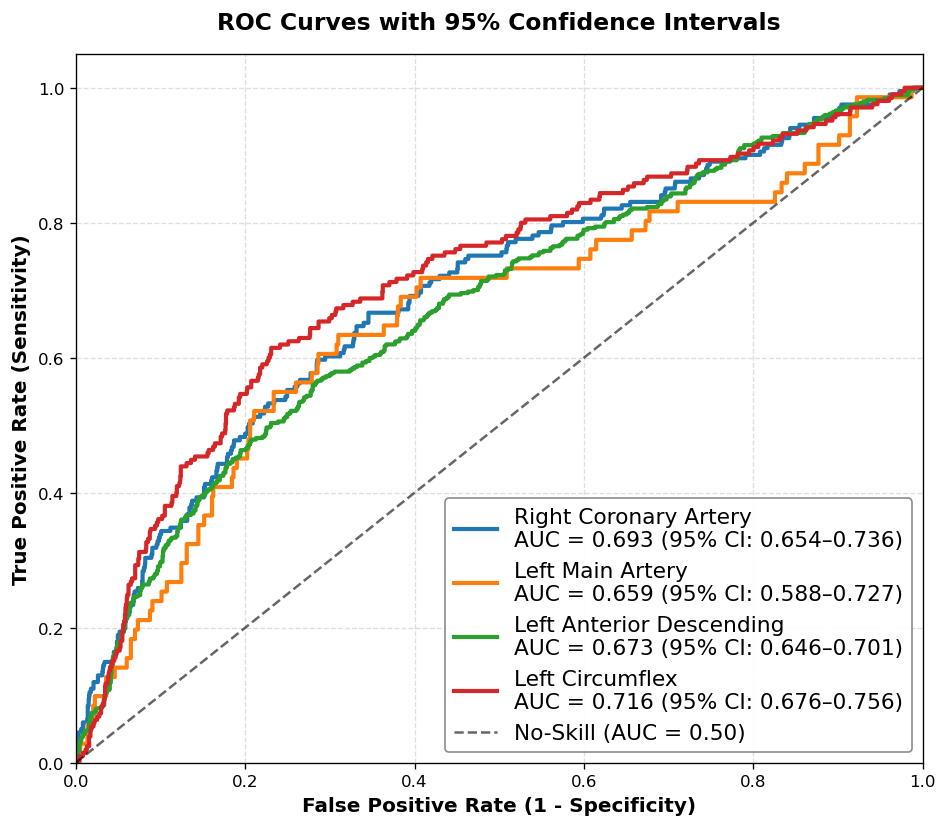

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np

# ===================================================================
# 1. 配置区
# ===================================================================

RESULTS_CSV_PATH = '/data2/2shared/xiaoyujie/冠脉造影/人民5折交叉验证/checkpoint_5fold_轻中度正常/筛选正常/renmin_final.csv'

LABEL_COLUMN_NAMES = [
    '右冠状动脉主干_诊断结果', 
    '左冠状动脉主干_诊断结果', 
    '左前降支_诊断结果', 
    '左回旋支_诊断结果'
]

PROB_COLUMN_NAMES = [
    '右冠状动脉主干_prob', 
    '左冠状动脉主干_prob', 
    '左前降支_prob', 
    '左回旋支_prob'
]

CLASS_NAMES_ENGLISH = [
    'Right Coronary Artery',
    'Left Main Artery',
    'Left Anterior Descending',
    'Left Circumflex'
]

NEGATIVE_CLASS_STRINGS_LIST = ["未见明显狭窄","轻度狭窄","中度狭窄"]

# Bootstrapping 配置
N_BOOTSTRAPS = 1000  # 重采样次数
CI_ALPHA = 0.95      # 置信度 (95%)
SEED = 42            # 随机种子

# ===================================================================
# 2. 辅助函数：计算 AUC CI
# ===================================================================

def calculate_auc_ci(y_true, y_scores, n_bootstraps=1000, alpha=0.95, rng_seed=42):
    """
    使用 Bootstrapping 计算 ROC-AUC 的置信区间
    """
    bootstrapped_scores = []
    rng = np.random.RandomState(rng_seed)
    
    for i in range(n_bootstraps):
        # 有放回重采样索引
        indices = rng.randint(0, len(y_scores), len(y_scores))
        if len(np.unique(y_true.iloc[indices])) < 2:
            # 如果重采样样本中只有一类，跳过此次（虽少见但可能发生）
            continue
            
        score = auc(*roc_curve(y_true.iloc[indices], y_scores.iloc[indices])[:2])
        bootstrapped_scores.append(score)
        
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    # 计算分位数
    lower_bound = np.percentile(sorted_scores, (1 - alpha) / 2 * 100)
    upper_bound = np.percentile(sorted_scores, (1 + alpha) / 2 * 100)
    
    return lower_bound, upper_bound

# ===================================================================
# 3. 数据加载和处理
# ===================================================================

df = pd.read_csv(RESULTS_CSV_PATH)

roc_results = {}

print("Calculating ROC, AUC, and 95% CI for each class...")

for i in range(len(LABEL_COLUMN_NAMES)):
    label_col = LABEL_COLUMN_NAMES[i]
    prob_col = PROB_COLUMN_NAMES[i]
    class_name = CLASS_NAMES_ENGLISH[i]

    if label_col not in df.columns or prob_col not in df.columns:
        continue

    temp_df = df[[label_col, prob_col]].dropna()
    y_true = temp_df[label_col].apply(lambda x: 0 if x in NEGATIVE_CLASS_STRINGS_LIST else 1)
    y_scores = temp_df[prob_col]

    if len(np.unique(y_true)) < 2:
        continue

    # 1. 计算基础指标
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # 2. 计算置信区间 (CI)
    ci_lower, ci_upper = calculate_auc_ci(y_true, y_scores, n_bootstraps=N_BOOTSTRAPS, alpha=CI_ALPHA, rng_seed=SEED)

    roc_results[class_name] = {
        'fpr': fpr, 
        'tpr': tpr, 
        'auc': roc_auc,
        'ci_low': ci_lower,
        'ci_high': ci_upper
    }
    
    print(f"- {class_name}: AUC={roc_auc:.3f} (95% CI: {ci_lower:.3f}-{ci_upper:.3f})")

# ===================================================================
# 4. 绘图 (带 CI)
# ===================================================================

if not roc_results:
    print("\nNo valid data to plot. Exiting.")
    exit()

# 使用无衬线字体风格
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
fig, ax = plt.subplots(1, 1, figsize=(8, 7), dpi=120) # 稍微加大一点尺寸

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] # 经典配色

for idx, (class_name, results) in enumerate(roc_results.items()):
    auc_val = results['auc']
    ci_low = results['ci_low']
    ci_high = results['ci_high']
    color = colors[idx % len(colors)]
    
    # 格式化图例文字
    label_str = f"{class_name}\nAUC = {auc_val:.3f} (95% CI: {ci_low:.3f}–{ci_high:.3f})"
    
    ax.plot(
        results['fpr'], 
        results['tpr'], 
        lw=2.5,
        color=color,
        label=label_str
    )

# 绘制对角线
ax.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.6, label='No-Skill (AUC = 0.50)')

# 美化图表
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate (Sensitivity)', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves with 95% Confidence Intervals', fontsize=14, fontweight='bold', pad=15)

# 优化图例 (放在右下角，稍微调小字体以防遮挡)
ax.legend(loc="lower right", fontsize=13, frameon=True, framealpha=0.9, edgecolor='gray')

ax.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('/data2/2shared/xiaoyujie/冠脉造影/final/auc/Roc_c.png',dpi=900)
plt.show()

未来风险预测（km曲线）


==================== Endpoint: Myocardial Infarction (new_MI, new_MI_KM（筛选＞28）) ====================
Fixed follow-up window: 700 days
High-risk rule: TOP-% in ANY vessel (LM/LAD/RCA/LCX)
[Combined] ⚠️ 2 events have negative total time (event before follow-up). Excluding them.
[Combined] High=62/398 (15.58%) | window=700d | events_censored_by_window=8
  - Trigger by RCA Top 15%: 60/398 (within non-missing)
  - Trigger by LM Top 10%: 40/398 (within non-missing)
  - Trigger by LAD Top 15%: 60/398 (within non-missing)
  - Trigger by LCX Top 15%: 60/398 (within non-missing)


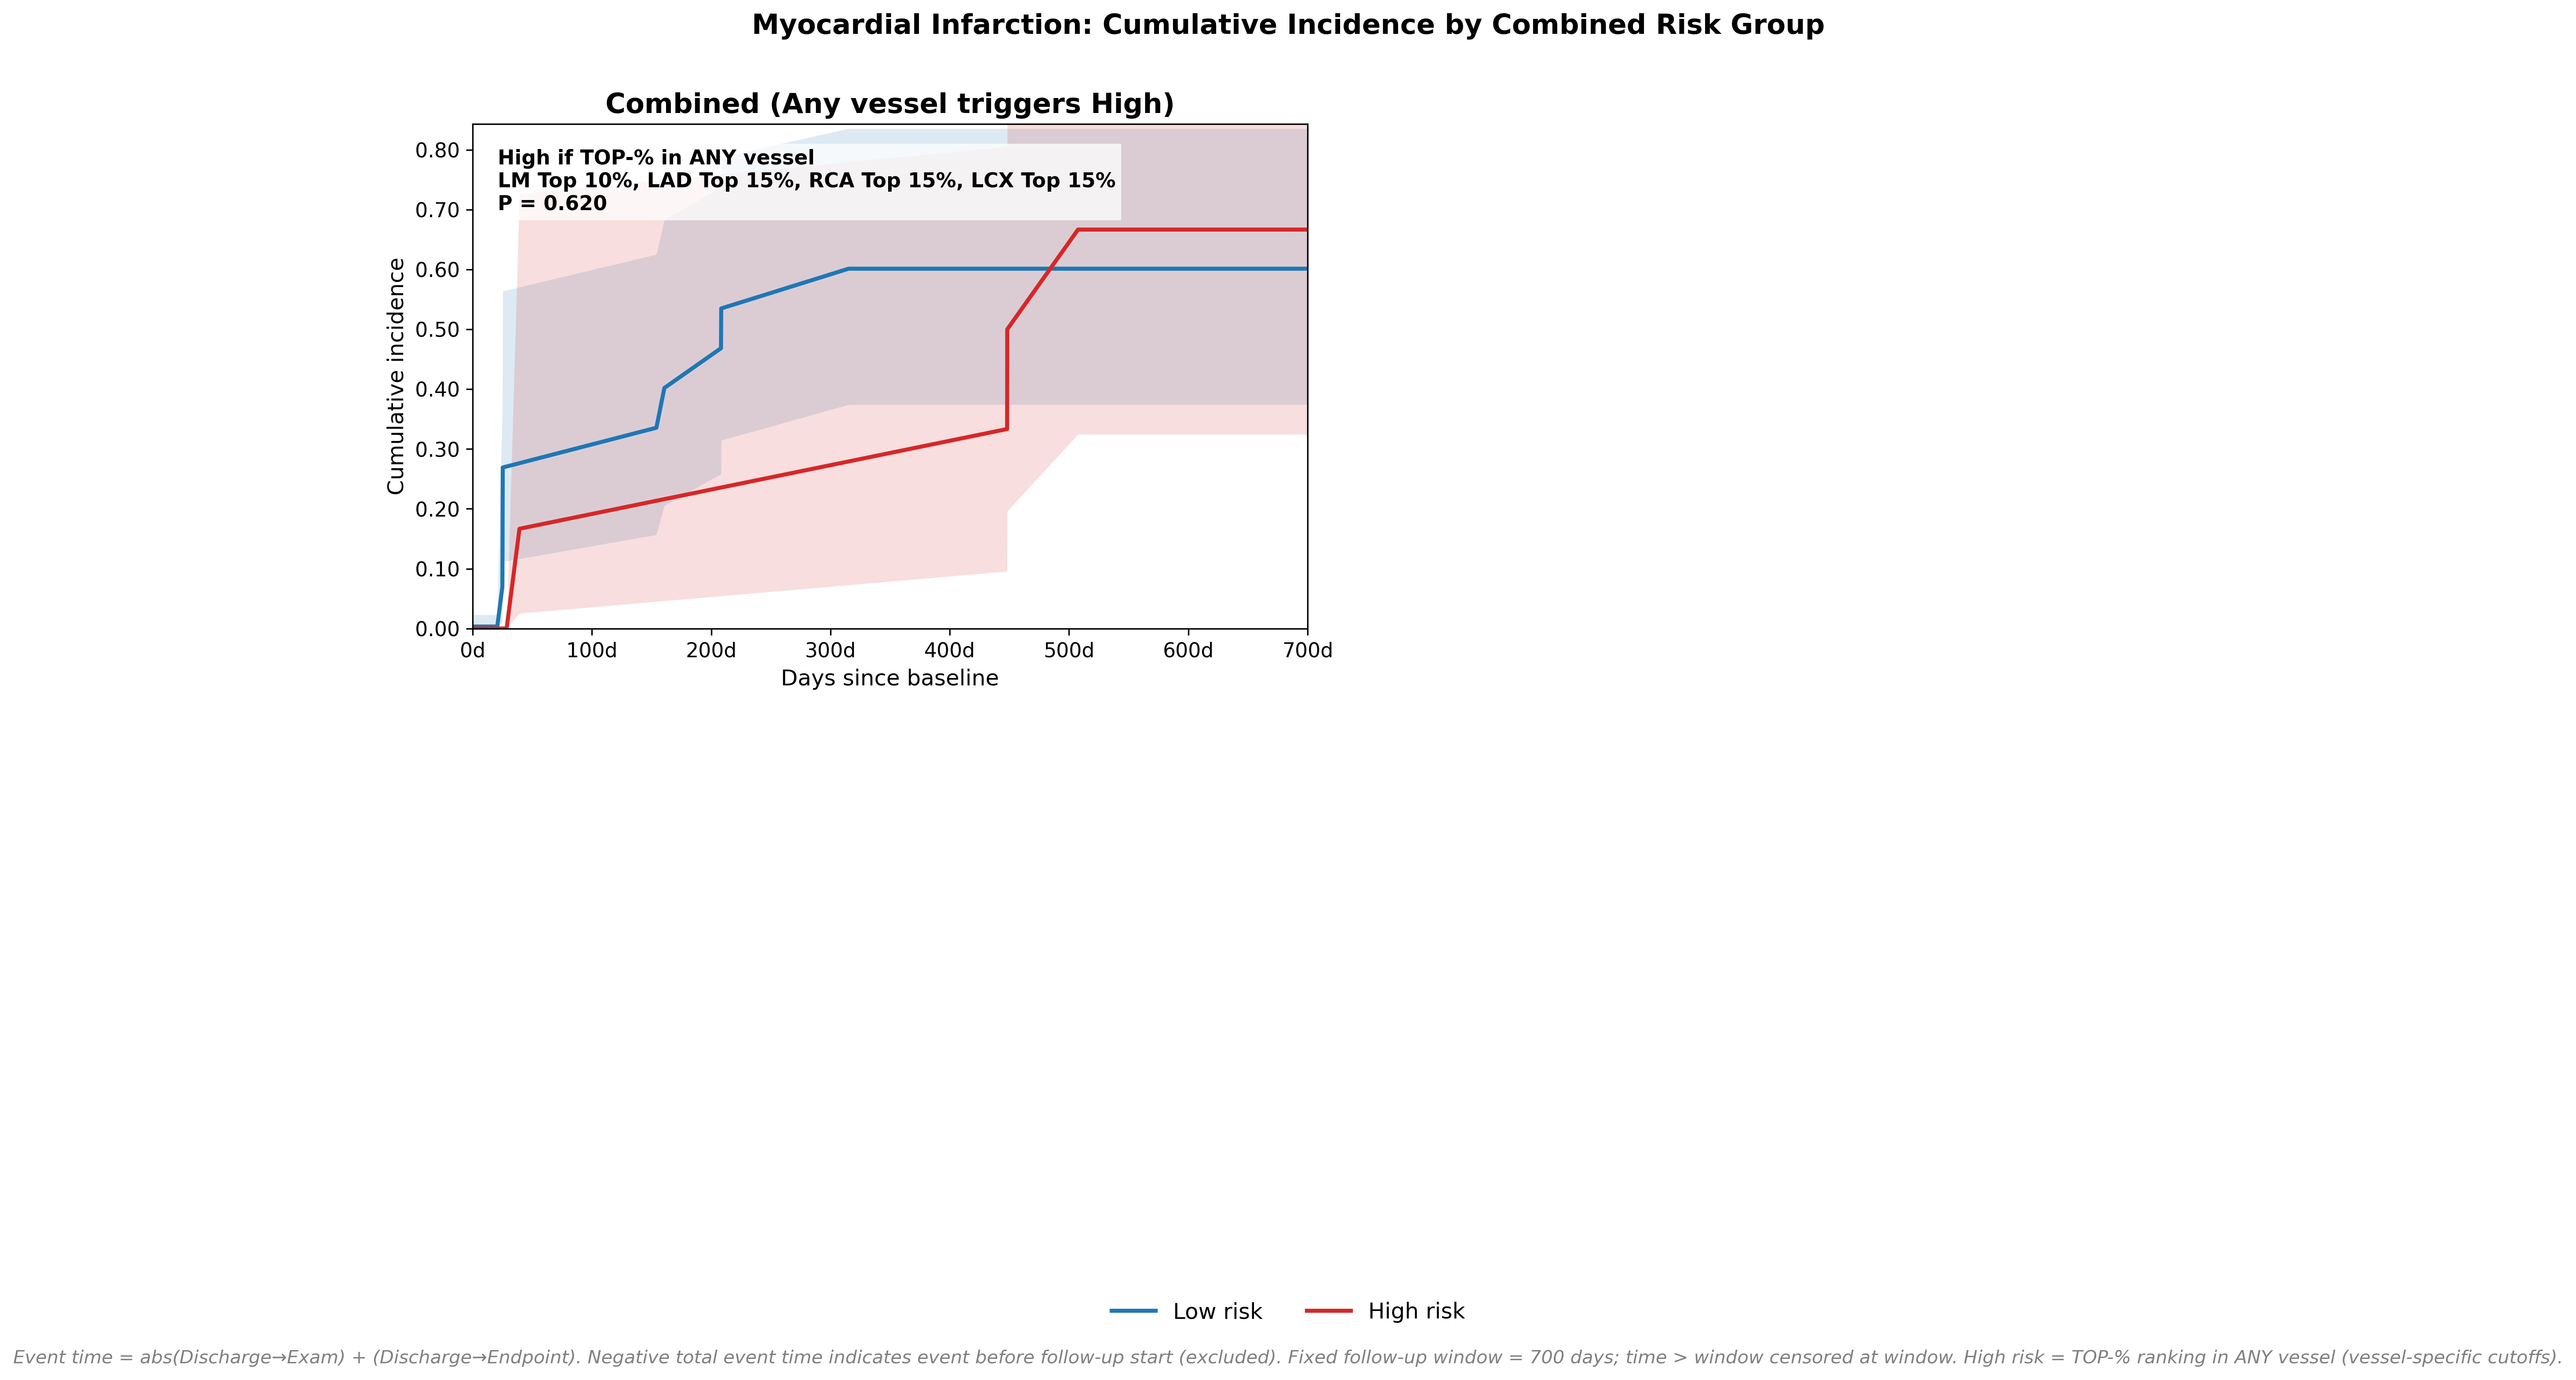

Saved: ./KM_outputs_anyVesselTop_fixed700/KM_MI_combined_anyVesselTop_fixed700.png
Saved: ./KM_outputs_anyVesselTop_fixed700/KM_MI_combined_anyVesselTop_fixed700.pdf

==================== Endpoint: All-cause Death (new_death, new_death_KM) ====================
Fixed follow-up window: 700 days
High-risk rule: TOP-% in ANY vessel (LM/LAD/RCA/LCX)
[Combined] ⚠️ 1 events have negative total time (event before follow-up). Excluding them.
[Combined] High=62/399 (15.54%) | window=700d | events_censored_by_window=0
  - Trigger by RCA Top 15%: 60/399 (within non-missing)
  - Trigger by LM Top 10%: 40/399 (within non-missing)
  - Trigger by LAD Top 15%: 60/399 (within non-missing)
  - Trigger by LCX Top 15%: 60/399 (within non-missing)


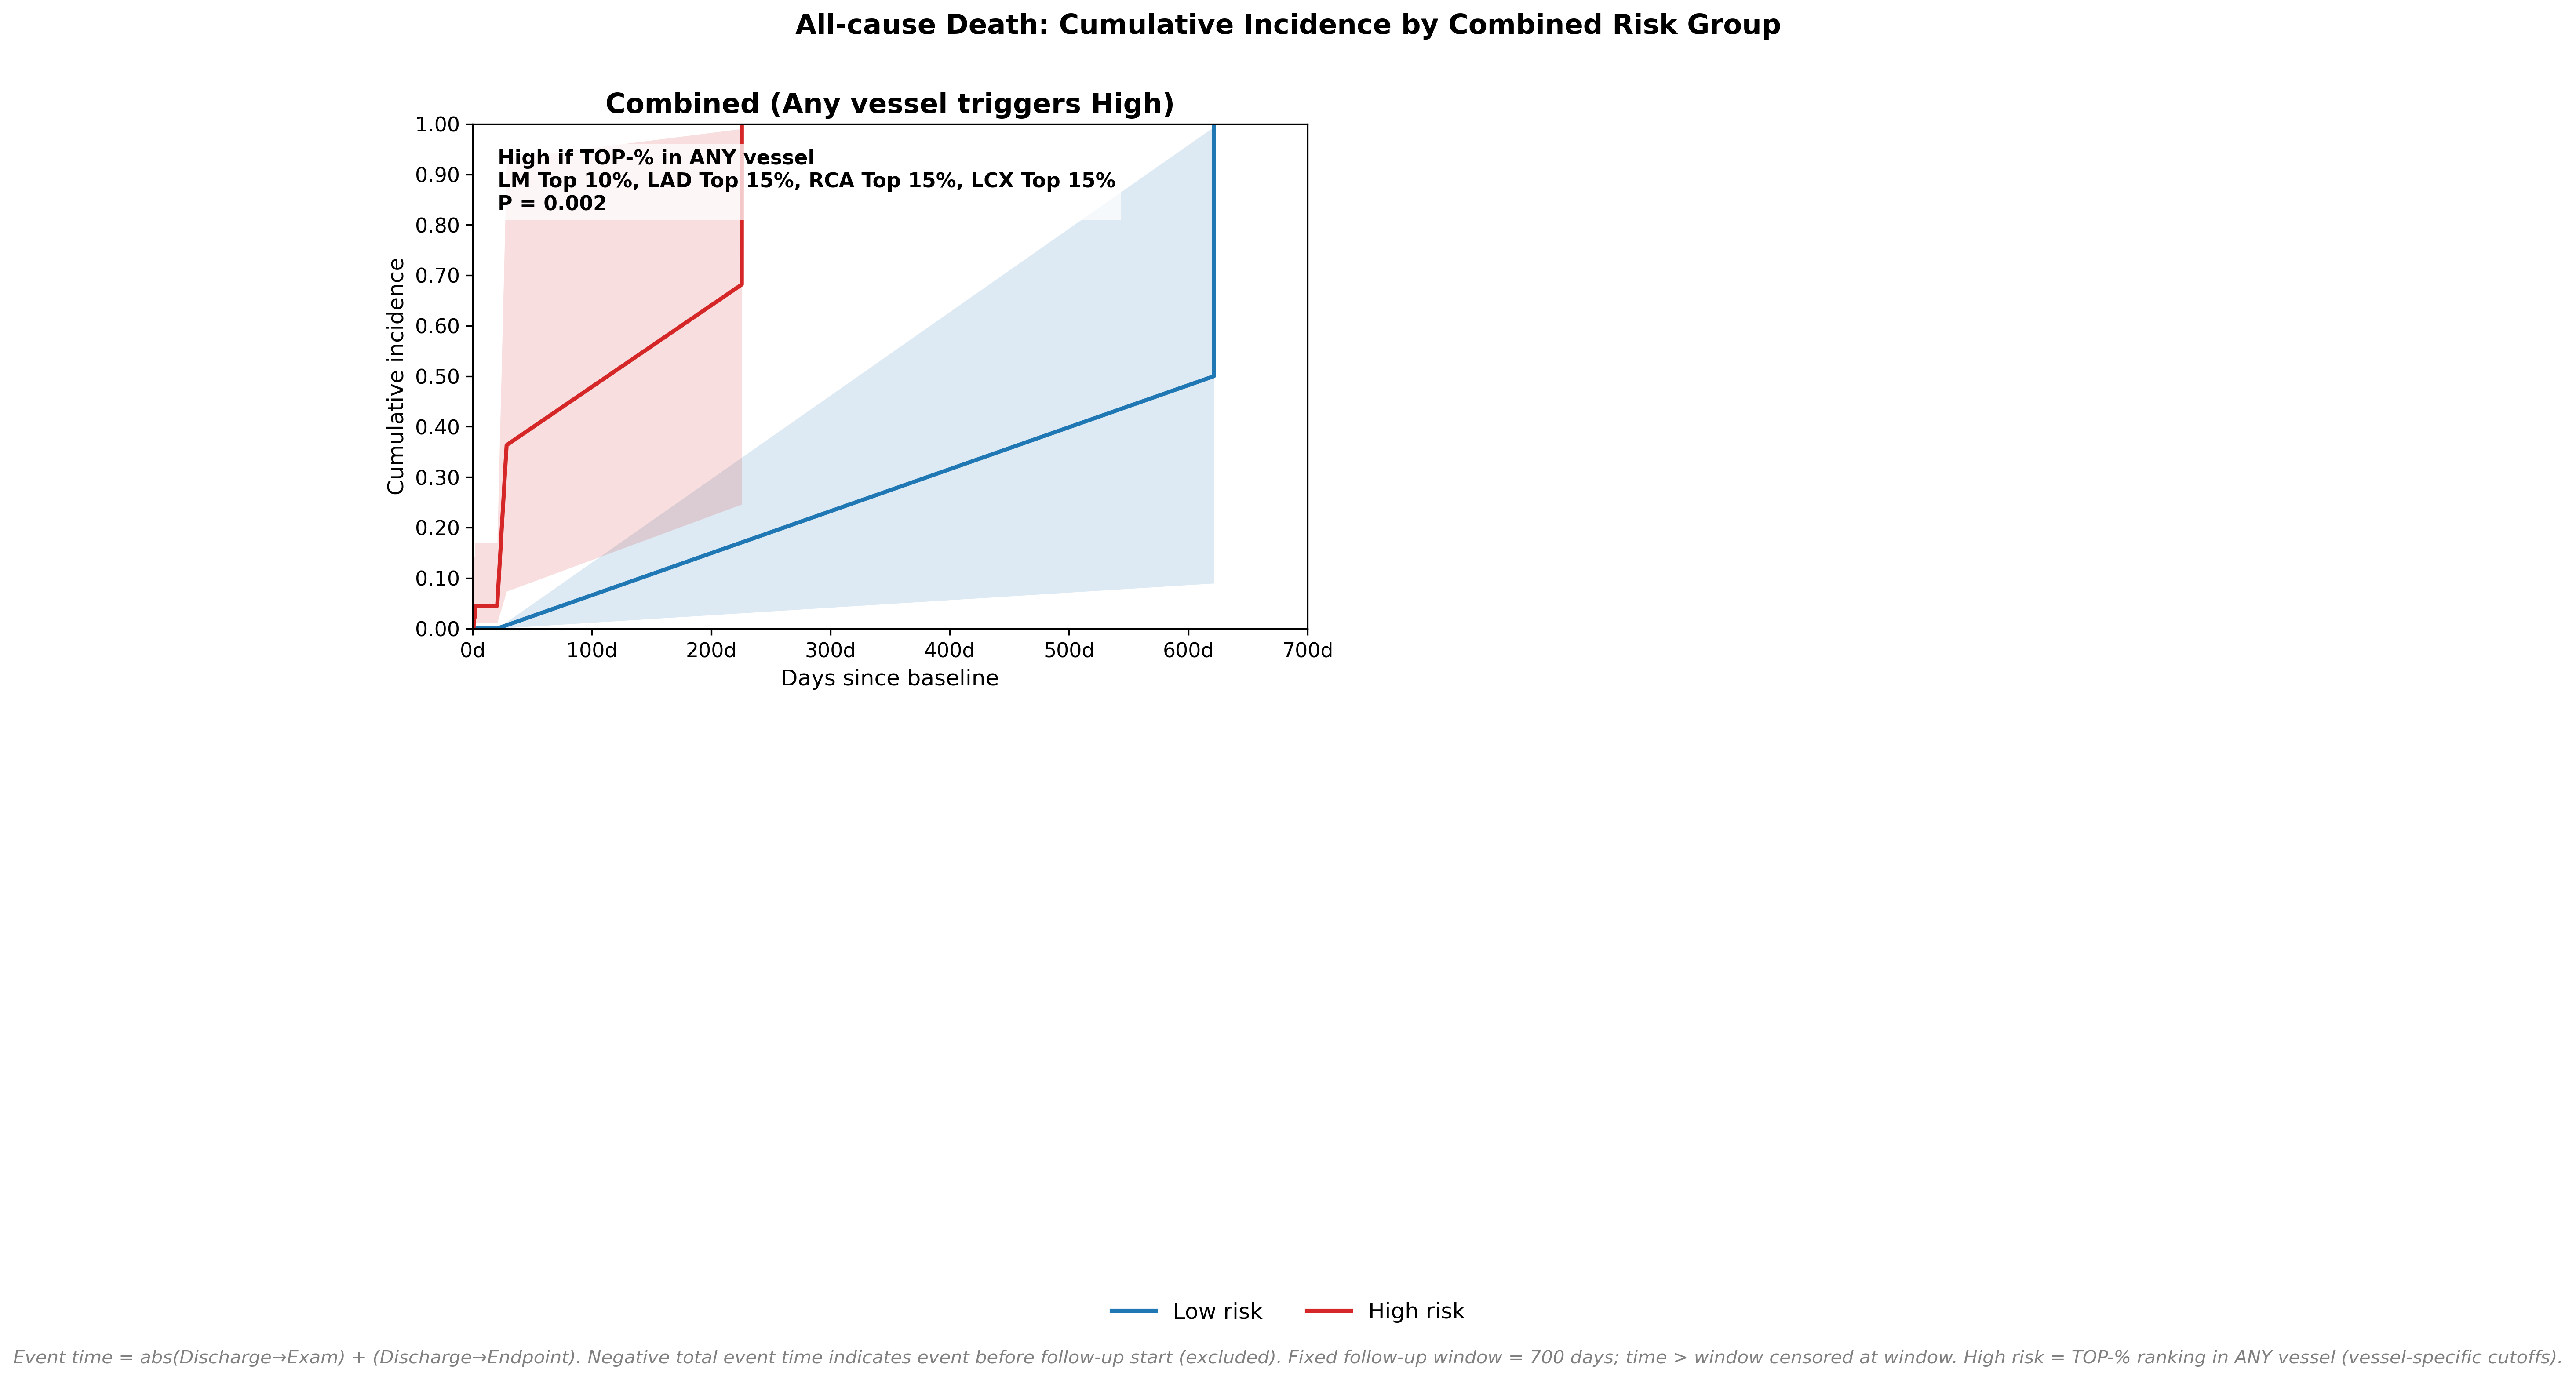

Saved: ./KM_outputs_anyVesselTop_fixed700/KM_Death_combined_anyVesselTop_fixed700.png
Saved: ./KM_outputs_anyVesselTop_fixed700/KM_Death_combined_anyVesselTop_fixed700.pdf


In [10]:
# -*- coding: utf-8 -*-
"""
Cumulative incidence curves (1 - S(t)) with:
✅ Two endpoints (MI, Death) -> two 2x2 figures
✅ High-risk defined by vessel-specific TOP-% ranking (NO absolute thresholds)
✅ Combined rule across 4 vessels:
   High if a subject is in TOP-% for ANY vessel (LM/LAD/RCA/LCX) using:
   {"LM":0.10, "LAD":0.15, "RCA":0.15, "LCX":0.15}
✅ Fixed follow-up window: 700 days
   - time > 700 days => censor at 700 days (event set to 0)
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# ==================== 1) STYLE ====================

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.linewidth'] = 0.8

RISK_COLORS = {"Low": "#1f77b4", "High": "#d62728"}

# ==================== 2) PATH / OUTPUT ====================

CSV_PATH = '/data2/2shared/xiaoyujie/冠脉造影/final/随访_pred.csv'
OUT_DIR = "./KM_outputs_anyVesselTop_fixed700"
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(CSV_PATH)

# ==================== 3) TIME COLUMNS ====================

DISCHARGE_COL = "出院日期"
EXAM_TIME_COL = "检查时间"

# ==================== 4) PROB COLUMNS ====================

PROB_COLUMN_NAMES = [
    '右冠状动脉主干_prob',  # RCA
    '左冠状动脉主干_prob',  # LM
    '左前降支_prob',        # LAD
    '左回旋支_prob'         # LCX
]
VESSEL_NAMES = ['RCA', 'LM', 'LAD', 'LCX']

# ==================== 5) VESSEL-SPECIFIC TOP-% ====================

TOP_PCT_BY_VESSEL = {"LM": 0.10, "LAD": 0.15, "RCA": 0.15, "LCX": 0.15}
DEFAULT_TOP_PCT = 0.15

# ==================== 6) ENDPOINTS ====================

ENDPOINTS = [
    {"name": "Myocardial Infarction", "event_col": "new_MI",    "km_days_col": "new_MI_KM（筛选＞28）", "tag": "MI"},
    {"name": "All-cause Death",       "event_col": "new_death", "km_days_col": "new_death_KM",         "tag": "Death"},
]

# ==================== 7) FIXED FOLLOW-UP ====================

FIXED_FOLLOWUP_DAYS = 700.0
MIN_YMAX = 0.02

# ==================== 8) HELPERS ====================

def to_numeric_series(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

def to_datetime_series(s: pd.Series) -> pd.Series:
    return pd.to_datetime(s, errors="coerce")

def days_between_abs(a: pd.Series, b: pd.Series) -> pd.Series:
    dt_days = (b - a).dt.total_seconds() / 86400.0
    return dt_days.abs()

def censor_at_fixed_window(time_raw: pd.Series, event_raw: pd.Series, x_max: float):
    """
    固定随访窗：time > x_max => time=x_max, event=0 (删失)
    """
    time = time_raw.clip(lower=0, upper=x_max).astype(float)
    event = event_raw.copy().astype(int)

    over_mask = (time_raw > x_max)
    event.loc[over_mask] = 0
    time.loc[over_mask] = x_max
    return time, event

def choose_y_ticks(y_max: float):
    if y_max <= 0.10:
        return 0.01
    elif y_max <= 0.30:
        return 0.05
    else:
        return 0.10

def format_axes_days(ax, x_max: float):
    ax.set_xlim(0, x_max)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(100))
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda v, pos: f"{int(round(v))}d"))
    ax.set_xlabel("Days since baseline")

def set_adaptive_yaxis(ax, y_max: float):
    y_max = min(1.0, y_max * 1.25 + 0.01)
    y_max = max(y_max, MIN_YMAX)
    ax.set_ylim(0, y_max)
    step = choose_y_ticks(y_max)
    ax.yaxis.set_major_locator(mticker.MultipleLocator(step))
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

def p_text_from_p(p_value: float) -> str:
    return "P < 0.001" if p_value < 0.001 else f"P = {p_value:.3f}"

def build_time_event_from_columns(df_sub: pd.DataFrame, event_col: str, km_days_col: str):
    """
    event_raw = 1 iff new_* == 1 else 0
    base_days = abs(出院日期 -> 检查时间)
    time_raw = base_days (+ km_days if event and km available)
    """
    discharge_dt = to_datetime_series(df_sub[DISCHARGE_COL])
    exam_dt = to_datetime_series(df_sub[EXAM_TIME_COL])
    base_days = days_between_abs(discharge_dt, exam_dt)

    ev = to_numeric_series(df_sub[event_col]).fillna(0).astype(int)
    ev = (ev == 1).astype(int)

    km_days = to_numeric_series(df_sub[km_days_col])

    time = base_days.copy()
    event_mask = (ev == 1)

    km_ok = event_mask & km_days.notna()
    time.loc[km_ok] = base_days.loc[km_ok] + km_days.loc[km_ok]

    # if marked event but missing km time => treat as censored
    ev.loc[event_mask & km_days.isna()] = 0

    return time, ev

def select_top_k_mask(prob: pd.Series, top_pct: float) -> pd.Series:
    """
    返回布尔mask：prob非空样本中，概率最高 top_pct 为 True。
    使用 rank(method="first")，保证精确人数 = ceil(n*top_pct)。
    """
    top_pct = float(top_pct)
    top_pct = min(max(top_pct, 0.0), 1.0)

    mask = pd.Series(False, index=prob.index)

    valid = prob.dropna()
    n = int(valid.shape[0])
    if n == 0 or top_pct <= 0:
        return mask

    k = int(np.ceil(n * top_pct))
    if k <= 0:
        return mask

    r = valid.rank(method="first", ascending=True)
    cutoff_rank = n - k + 1
    chosen_idx = r[r >= cutoff_rank].index
    mask.loc[chosen_idx] = True
    return mask

def build_combined_any_vessel_risk(df_all: pd.DataFrame) -> pd.Series:
    """
    High if TOP-% in ANY vessel.
    为避免不同血管的缺失导致“未参与排名”，这里采用：
      - 每个血管仅在该血管prob非空的人群中选 top%
      - 某人只要在任意一根血管被选中 => High
      - 如果一个人四根血管全缺失 => Low（也可以改成丢弃）
    """
    high_any = pd.Series(False, index=df_all.index)

    for prob_col, vessel in zip(PROB_COLUMN_NAMES, VESSEL_NAMES):
        if prob_col not in df_all.columns:
            continue
        p = to_numeric_series(df_all[prob_col])
        top_pct = float(TOP_PCT_BY_VESSEL.get(vessel, DEFAULT_TOP_PCT))
        top_mask = select_top_k_mask(p, top_pct)
        high_any = high_any | top_mask

    return pd.Series(np.where(high_any, "High", "Low"), index=df_all.index)

# ==================== 9) CORE PLOTTER ====================

def plot_endpoint_combined(df: pd.DataFrame, endpoint_name: str, event_col: str, km_days_col: str, tag: str):
    for col in [event_col, km_days_col, DISCHARGE_COL, EXAM_TIME_COL]:
        if col not in df.columns:
            raise KeyError(f"❌ 未找到列: {col}")

    # 只需要1张图（High vs Low），但你原来是2x2；这里做成2x2保持风格：
    fig, axes = plt.subplots(2, 2, figsize=(14, 10.5), dpi=300)
    axes = axes.flatten()

    print(f"\n{'='*20} Endpoint: {endpoint_name} ({event_col}, {km_days_col}) {'='*20}")
    print(f"Fixed follow-up window: {FIXED_FOLLOWUP_DAYS:.0f} days")
    print("High-risk rule: TOP-% in ANY vessel (LM/LAD/RCA/LCX)")

    # ====== 1) 计算 combined risk_group（在全体 df 上做） ======
    df_work = df.copy()
    df_work["risk_group"] = build_combined_any_vessel_risk(df_work)

    # ====== 2) 构建 time/event + 固定700天删失 ======
    sub_cols = [event_col, km_days_col, DISCHARGE_COL, EXAM_TIME_COL] + PROB_COLUMN_NAMES
    sub_cols = [c for c in sub_cols if c in df_work.columns]
    sub = df_work[sub_cols + ["risk_group"]].copy()

    time_raw, event_raw = build_time_event_from_columns(sub, event_col, km_days_col)

    # 负的最终时间（只有可能来自 km_days 为负）=> 事件在随访开始前
    neg_event_mask = (event_raw == 1) & (time_raw < 0)
    n_neg = int(neg_event_mask.sum())
    if n_neg > 0:
        print(f"[Combined] ⚠️ {n_neg} events have negative total time (event before follow-up). Excluding them.")
        sub = sub.loc[~neg_event_mask].copy()
        time_raw = time_raw.loc[~neg_event_mask].copy()
        event_raw = event_raw.loc[~neg_event_mask].copy()

    valid_mask = time_raw.notna()
    sub = sub.loc[valid_mask].copy()
    time_raw = time_raw.loc[valid_mask].copy()
    event_raw = event_raw.loc[valid_mask].copy()

    x_max = FIXED_FOLLOWUP_DAYS
    time, event = censor_at_fixed_window(time_raw, event_raw, x_max)
    sub["time"] = time
    sub["event"] = event

    # ====== 3) KM + logrank ======
    group_high = sub[sub["risk_group"] == "High"]
    group_low  = sub[sub["risk_group"] == "Low"]
    if len(group_high) > 0 and len(group_low) > 0:
        p_value = logrank_test(
            group_high["time"], group_low["time"],
            event_observed_A=group_high["event"],
            event_observed_B=group_low["event"]
        ).p_value
    else:
        p_value = 1.0

    # 画在第一个子图，其余关掉（保持你2x2布局习惯）
    ax = axes[0]
    for j in [1, 2, 3]:
        axes[j].axis("off")

    kmf = KaplanMeierFitter()
    y_max_candidates = []

    for group in ["Low", "High"]:
        data = sub[sub["risk_group"] == group]
        if len(data) == 0:
            continue

        kmf.fit(data["time"], event_observed=data["event"], label=group)
        cuminc = 1.0 - kmf.survival_function_

        ax.plot(
            cuminc.index.values,
            cuminc.values.flatten(),
            color=RISK_COLORS[group],
            lw=2.2,
            label=group
        )

        if hasattr(kmf, "confidence_interval_") and kmf.confidence_interval_ is not None:
            ci = kmf.confidence_interval_
            ci_low = 1.0 - ci.iloc[:, 1]
            ci_high = 1.0 - ci.iloc[:, 0]
            ax.fill_between(
                cuminc.index.values,
                ci_low.values,
                ci_high.values,
                alpha=0.15,
                linewidth=0,
                color=RISK_COLORS[group]
            )

        y_max_candidates.append(float(np.nanmax(cuminc.values)))

    # ====== 4) 标注与坐标 ======
    ax.text(
        0.03, 0.95,
        "High if TOP-% in ANY vessel\n"
        f"LM Top {TOP_PCT_BY_VESSEL.get('LM', DEFAULT_TOP_PCT):.0%}, "
        f"LAD Top {TOP_PCT_BY_VESSEL.get('LAD', DEFAULT_TOP_PCT):.0%}, "
        f"RCA Top {TOP_PCT_BY_VESSEL.get('RCA', DEFAULT_TOP_PCT):.0%}, "
        f"LCX Top {TOP_PCT_BY_VESSEL.get('LCX', DEFAULT_TOP_PCT):.0%}\n"
        f"{p_text_from_p(p_value)}",
        transform=ax.transAxes,
        va="top",
        fontsize=11,
        fontweight="bold",
        bbox=dict(facecolor="white", alpha=0.75, edgecolor="none", pad=3)
    )

    ax.set_title("Combined (Any vessel triggers High)", fontsize=15, fontweight="bold", pad=6)
    ax.set_ylabel("Cumulative incidence")
    format_axes_days(ax, x_max)

    y_max = max(y_max_candidates) if len(y_max_candidates) > 0 else MIN_YMAX
    set_adaptive_yaxis(ax, y_max)

    ax.grid(False)

    # legend
    fig.legend(
        handles=[
            plt.Line2D([0], [0], color=RISK_COLORS["Low"],  lw=2.2, label="Low risk"),
            plt.Line2D([0], [0], color=RISK_COLORS["High"], lw=2.2, label="High risk"),
        ],
        loc="lower center",
        ncol=2,
        frameon=False,
        fontsize=12,
        bbox_to_anchor=(0.5, 0.02)
    )

    # ====== 5) 打印统计 ======
    high_n = int((sub["risk_group"] == "High").sum())
    total_n = len(sub)
    censored_due_to_window = int(((time_raw > x_max) & (event_raw == 1)).sum())
    print(f"[Combined] High={high_n}/{total_n} ({high_n/total_n:.2%}) | window={x_max:.0f}d | events_censored_by_window={censored_due_to_window}")

    # 可选：看每根血管各自 top% 触发的人数（并会有重叠）
    for prob_col, vessel in zip(PROB_COLUMN_NAMES, VESSEL_NAMES):
        if prob_col not in df_work.columns:
            continue
        p = to_numeric_series(df_work.loc[sub.index, prob_col])
        top_pct = float(TOP_PCT_BY_VESSEL.get(vessel, DEFAULT_TOP_PCT))
        trig = select_top_k_mask(p, top_pct)
        print(f"  - Trigger by {vessel} Top {top_pct:.0%}: {int(trig.sum())}/{int(p.notna().sum())} (within non-missing)")

    # ====== 6) 保存 ======
    plt.figtext(
        0.5, 0.005,
        "Event time = abs(Discharge→Exam) + (Discharge→Endpoint). "
        "Negative total event time indicates event before follow-up start (excluded). "
        f"Fixed follow-up window = {FIXED_FOLLOWUP_DAYS:.0f} days; time > window censored at window. "
        "High risk = TOP-% ranking in ANY vessel (vessel-specific cutoffs).",
        ha="center", fontsize=10, style="italic", color="gray"
    )

    plt.suptitle(f"{endpoint_name}: Cumulative Incidence by Combined Risk Group", fontsize=15, fontweight="bold", y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.12, top=0.90)

    out_png = os.path.join(OUT_DIR, f"KM_{tag}_combined_anyVesselTop_fixed700.png")
    out_pdf = os.path.join(OUT_DIR, f"KM_{tag}_combined_anyVesselTop_fixed700.pdf")
    plt.savefig(out_png, dpi=600)
    plt.savefig(out_pdf)
    plt.show()

    print("Saved:", out_png)
    print("Saved:", out_pdf)

# ==================== 10) RUN ====================

for ep in ENDPOINTS:
    plot_endpoint_combined(
        df=df,
        endpoint_name=ep["name"],
        event_col=ep["event_col"],
        km_days_col=ep["km_days_col"],
        tag=ep["tag"]
    )


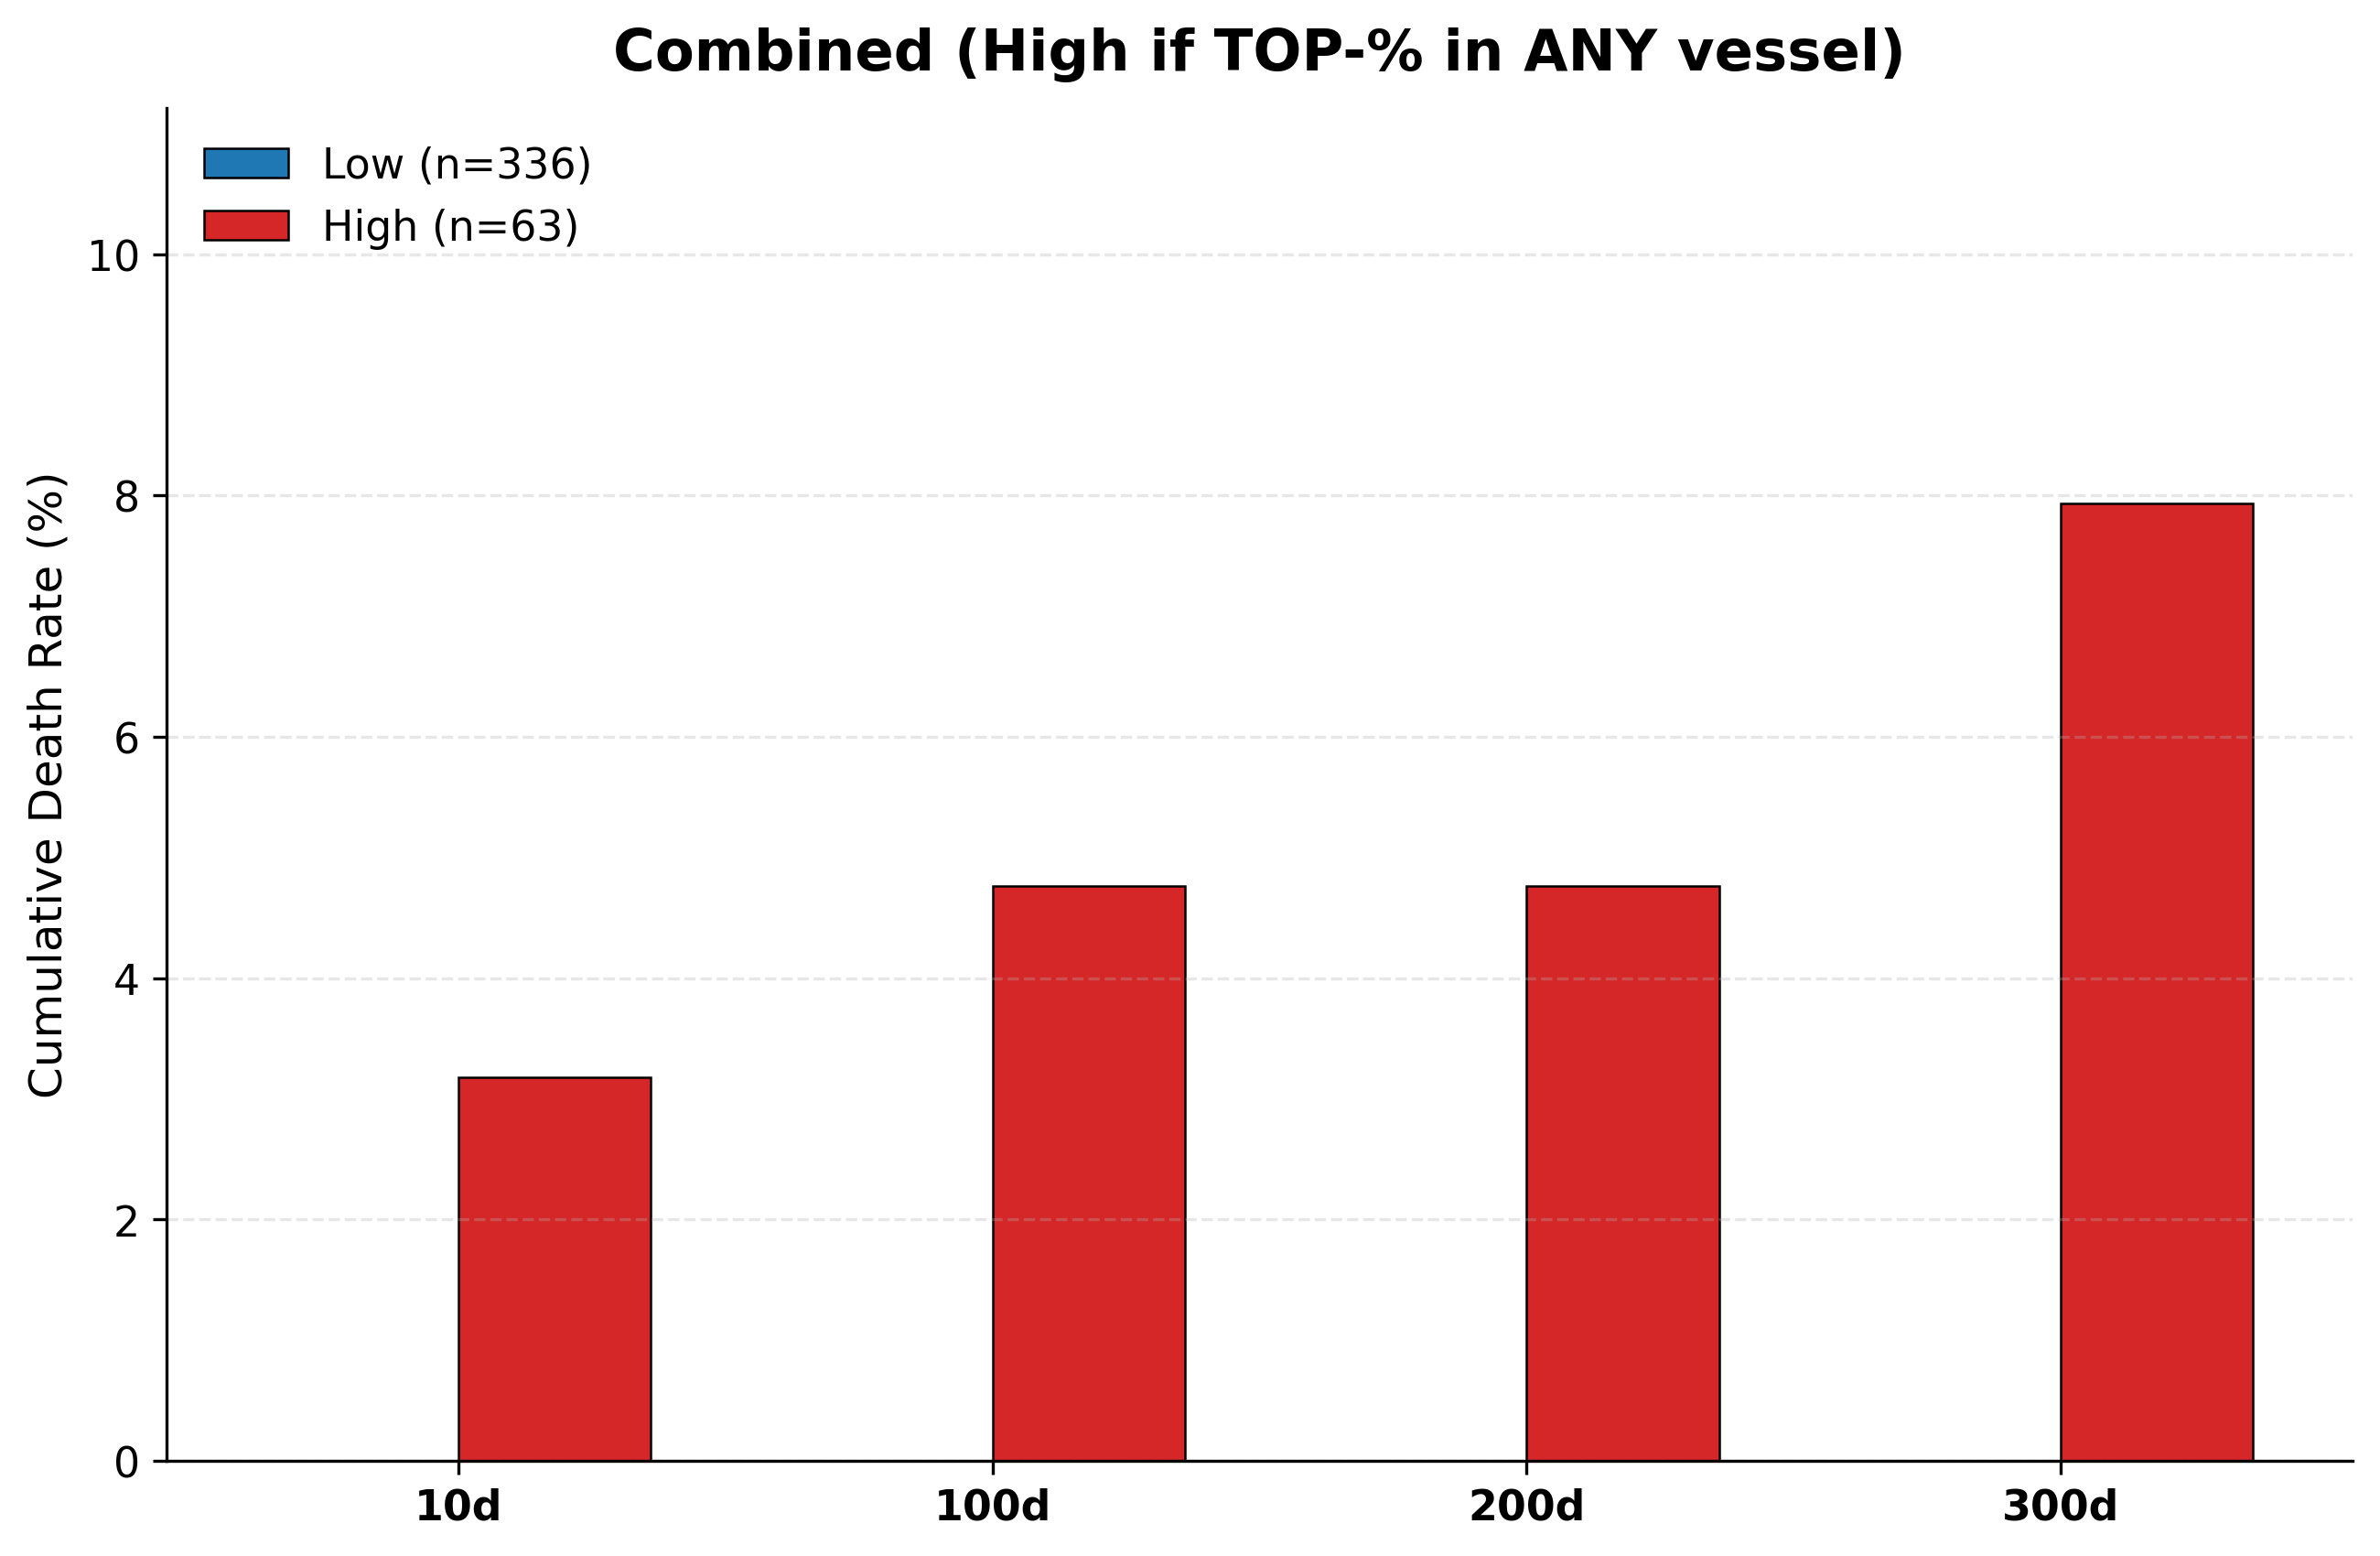

Saved: ./BarDeath_timeWindow_xaxis/DeathBars_TimeAxis_Combined_anyVesselTop.png
Saved: ./BarDeath_timeWindow_xaxis/DeathBars_TimeAxis_Combined_anyVesselTop.pdf


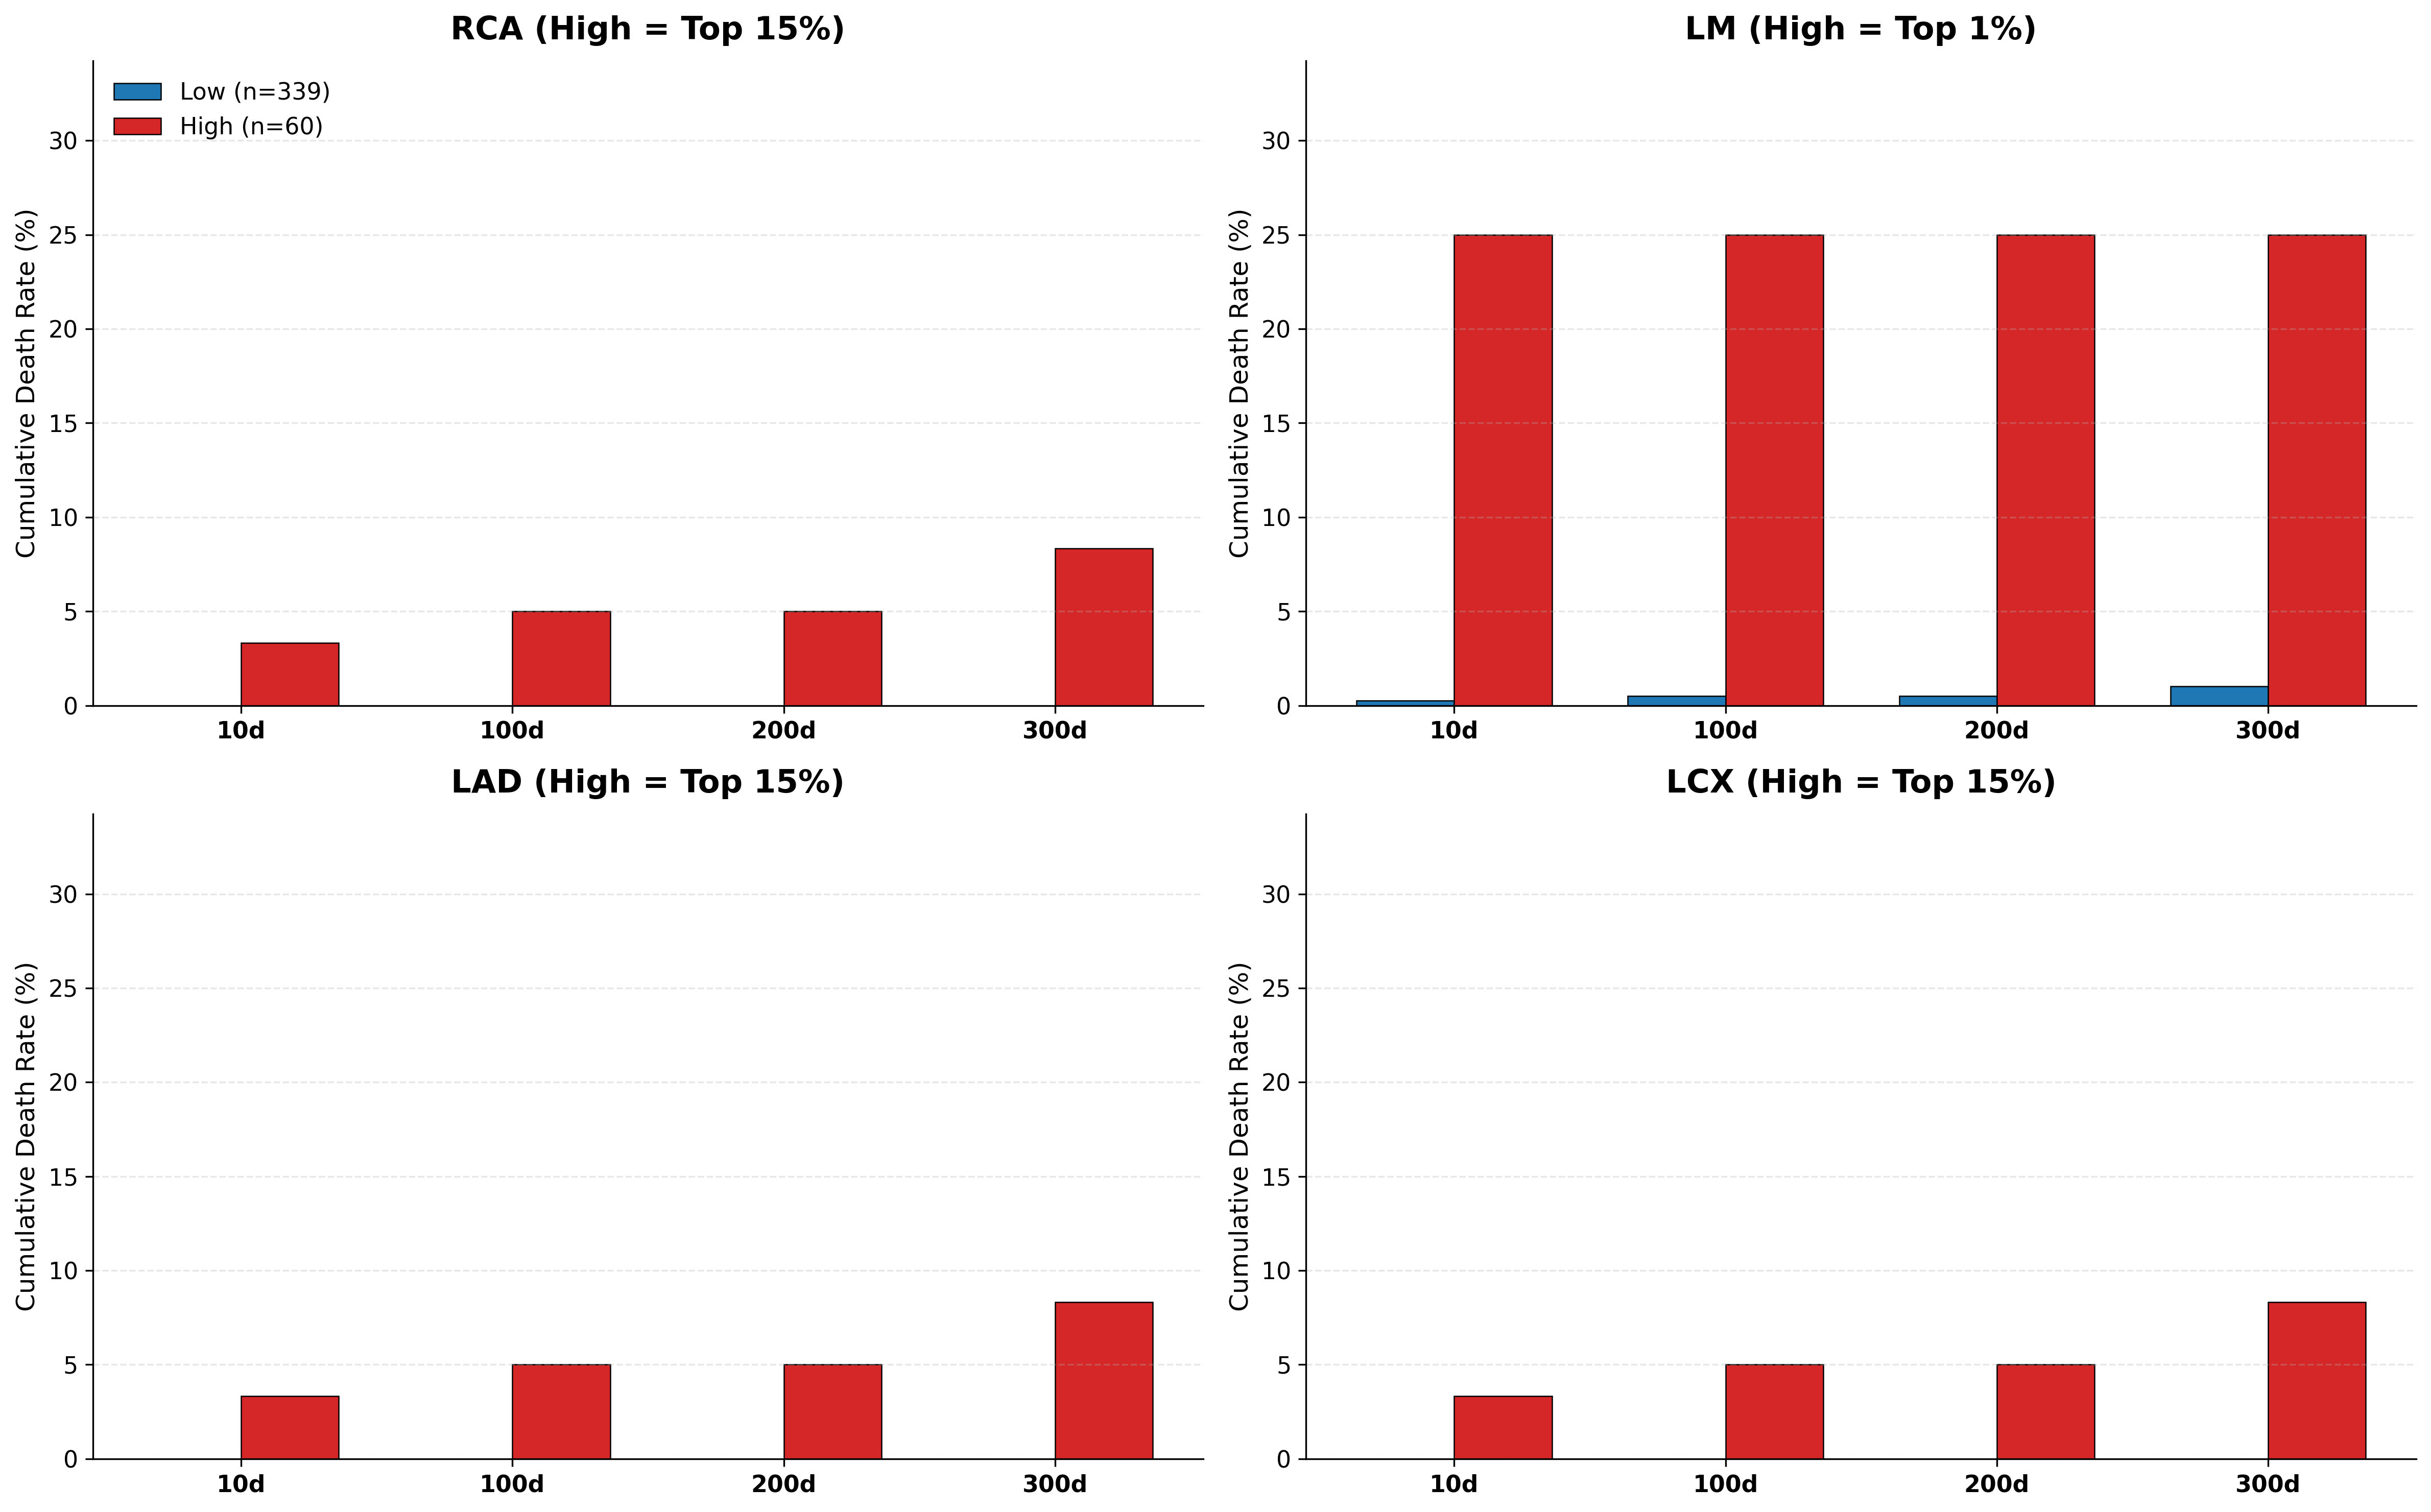

Saved: ./BarDeath_timeWindow_xaxis/DeathBars_TimeAxis_ByVesselTop_2x2.png
Saved: ./BarDeath_timeWindow_xaxis/DeathBars_TimeAxis_ByVesselTop_2x2.pdf


In [ ]:
# -*- coding: utf-8 -*-
"""
Bar plots of DEATH event rate within time windows:
✅ X-axis = time windows (10d / 100d / 200d / 300d)
✅ For each window, show side-by-side bars: Low vs High (easy comparison)
✅ Two figures:
   1) Combined (High if TOP-% in ANY vessel)
   2) Separate 2x2 (each vessel separately: High if TOP-% in that vessel)
✅ Fixed follow-up window: 700 days (censor >700d)
✅ NO p-values, NO bottom tables
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==================== Nature-ish style ====================

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['axes.linewidth'] = 0.8

RISK_COLORS = {"Low": "#1f77b4", "High": "#d62728"}

# ==================== PATH ====================

CSV_PATH = '/data2/2shared/xiaoyujie/冠脉造影/final/随访_pred.csv'  # ←改成你的文件
OUT_DIR = "./BarDeath_timeWindow_xaxis"
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(CSV_PATH)

# ==================== Endpoint config (Death) ====================

DISCHARGE_COL = "出院日期"
EXAM_TIME_COL = "检查时间"
EVENT_COL = "new_death"
KM_DAYS_COL = "new_death_KM"

# ==================== Vessel prob columns ====================

PROB_COLUMN_NAMES = [
    '右冠状动脉主干_prob',  # RCA
    '左冠状动脉主干_prob',  # LM
    '左前降支_prob',        # LAD
    '左回旋支_prob'         # LCX
]
VESSEL_NAMES = ['RCA', 'LM', 'LAD', 'LCX']

# vessel-specific top-% thresholds
TOP_PCT_BY_VESSEL = {"LM": 0.01, "LAD": 0.15, "RCA": 0.15, "LCX": 0.15}
DEFAULT_TOP_PCT = 0.15

# time windows (days)
TIME_POINTS = [10, 100, 200, 300]
TIME_NAMES = ["10d", "100d", "200d", "300d"]

FIXED_FOLLOWUP_DAYS = 700.0

# ==================== Helpers ====================

def to_numeric_series(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

def to_datetime_series(s: pd.Series) -> pd.Series:
    return pd.to_datetime(s, errors="coerce")

def days_between_abs(a: pd.Series, b: pd.Series) -> pd.Series:
    dt_days = (b - a).dt.total_seconds() / 86400.0
    return dt_days.abs()

def build_time_event_from_columns(df_sub: pd.DataFrame, event_col: str, km_days_col: str,
                                  discharge_col: str, exam_col: str):
    """
    event_raw = 1 iff event_col == 1 else 0
    base_days = abs(discharge -> exam)
    if event_raw==1 and km_days exists: time_raw = base_days + km_days
    if event_raw==1 but km_days missing: treat as censored at base_days (event=0)
    if event_raw==0: time_raw = base_days
    """
    discharge_dt = to_datetime_series(df_sub[discharge_col])
    exam_dt = to_datetime_series(df_sub[exam_col])
    base_days = days_between_abs(discharge_dt, exam_dt)

    ev = to_numeric_series(df_sub[event_col]).fillna(0).astype(int)
    ev = (ev == 1).astype(int)

    km_days = to_numeric_series(df_sub[km_days_col])

    time = base_days.copy()
    event_mask = (ev == 1)
    km_ok = event_mask & km_days.notna()
    time.loc[km_ok] = base_days.loc[km_ok] + km_days.loc[km_ok]

    # event but missing km time => censored
    ev.loc[event_mask & km_days.isna()] = 0
    return time, ev

def apply_fixed_followup(time_raw: pd.Series, event_raw: pd.Series, x_max: float):
    """
    time > x_max => censor at x_max (event=0)
    """
    time = time_raw.clip(lower=0, upper=x_max).astype(float)
    event = event_raw.copy().astype(int)
    over = (time_raw > x_max)
    event.loc[over] = 0
    time.loc[over] = x_max
    return time, event

def select_top_k_mask(prob: pd.Series, top_pct: float) -> pd.Series:
    """
    Among non-missing prob, select top_pct as True.
    Use rank(method="first") to ensure exact k=ceil(n*top_pct).
    """
    top_pct = float(top_pct)
    top_pct = min(max(top_pct, 0.0), 1.0)

    mask = pd.Series(False, index=prob.index)
    valid = prob.dropna()
    n = int(valid.shape[0])
    if n == 0 or top_pct <= 0:
        return mask

    k = int(np.ceil(n * top_pct))
    if k <= 0:
        return mask

    r = valid.rank(method="first", ascending=True)
    cutoff_rank = n - k + 1
    chosen_idx = r[r >= cutoff_rank].index
    mask.loc[chosen_idx] = True
    return mask

def risk_group_by_vessel_top(df_all: pd.DataFrame, vessel: str, prob_col: str) -> pd.Series:
    p = to_numeric_series(df_all[prob_col])
    top_pct = float(TOP_PCT_BY_VESSEL.get(vessel, DEFAULT_TOP_PCT))
    high = select_top_k_mask(p, top_pct)
    return pd.Series(np.where(high, "High", "Low"), index=df_all.index)

def risk_group_any_vessel_top(df_all: pd.DataFrame) -> pd.Series:
    high_any = pd.Series(False, index=df_all.index)
    for prob_col, vessel in zip(PROB_COLUMN_NAMES, VESSEL_NAMES):
        if prob_col not in df_all.columns:
            continue
        p = to_numeric_series(df_all[prob_col])
        top_pct = float(TOP_PCT_BY_VESSEL.get(vessel, DEFAULT_TOP_PCT))
        high_any = high_any | select_top_k_mask(p, top_pct)
    return pd.Series(np.where(high_any, "High", "Low"), index=df_all.index)

def prepare_time_event_df(df0: pd.DataFrame):
    need = [DISCHARGE_COL, EXAM_TIME_COL, EVENT_COL, KM_DAYS_COL]
    for c in need:
        if c not in df0.columns:
            raise KeyError(f"❌ 缺少必要列: {c}")

    sub = df0.copy()
    time_raw, event_raw = build_time_event_from_columns(
        sub, EVENT_COL, KM_DAYS_COL, DISCHARGE_COL, EXAM_TIME_COL
    )

    # exclude negative event times
    neg_event_mask = (event_raw == 1) & (time_raw < 0)
    if int(neg_event_mask.sum()) > 0:
        sub = sub.loc[~neg_event_mask].copy()
        time_raw = time_raw.loc[~neg_event_mask].copy()
        event_raw = event_raw.loc[~neg_event_mask].copy()

    # drop bad datetime rows
    ok = time_raw.notna()
    sub = sub.loc[ok].copy()
    time_raw = time_raw.loc[ok].copy()
    event_raw = event_raw.loc[ok].copy()

    # fixed 700d censoring
    time, event = apply_fixed_followup(time_raw, event_raw, FIXED_FOLLOWUP_DAYS)
    return sub, time, event

def compute_rates_by_timewindow(time: pd.Series, event: pd.Series, risk_group: pd.Series):
    """
    Return dict:
      rates["Low"] = [rate_10d, rate_100d, ...]  (percent)
      rates["High"] = ...
    rate = (#events with time<=t) / N_group
    """
    out = {}
    for rg in ["Low", "High"]:
        idx = (risk_group == rg)
        n_total = int(idx.sum())
        rates = []
        for t in TIME_POINTS:
            n_evt = int(((event == 1) & (time <= t) & idx).sum())
            r = (n_evt / n_total * 100.0) if n_total > 0 else 0.0
            rates.append(r)
        out[rg] = rates
        out[f"{rg}_n"] = n_total
    return out

def plot_timewindow_bars(ax, rates_dict, title, ylim_max=None):
    """
    X-axis: time windows
    Bars: Low vs High side-by-side at each time window
    """
    x = np.arange(len(TIME_POINTS))
    width = 0.36

    low = np.array(rates_dict["Low"], dtype=float)
    high = np.array(rates_dict["High"], dtype=float)

    ax.bar(x - width/2, low, width=width, color=RISK_COLORS["Low"],
           edgecolor='black', linewidth=0.6, label=f"Low (n={rates_dict['Low_n']})")
    ax.bar(x + width/2, high, width=width, color=RISK_COLORS["High"],
           edgecolor='black', linewidth=0.6, label=f"High (n={rates_dict['High_n']})")

    ax.set_xticks(x)
    ax.set_xticklabels(TIME_NAMES, fontweight='bold')
    ax.set_ylabel("Cumulative Death Rate (%)")
    ax.set_title(title, fontsize=15, fontweight='bold', pad=10)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    if ylim_max is None:
        m = float(np.nanmax(np.r_[low, high])) if len(low) else 0.0
        ylim_max = max(2, min(100, m * 1.35 + 0.5))
    ax.set_ylim(0, ylim_max)

# ==================== Prepare time/event once ====================

sub_all, time_all, event_all = prepare_time_event_df(df)

# ============================================================
# FIGURE 1: Combined (ANY vessel triggers High)
# ============================================================

risk_any = risk_group_any_vessel_top(sub_all)
rates_any = compute_rates_by_timewindow(time_all, event_all, risk_any)

fig1, ax1 = plt.subplots(1, 1, figsize=(8.8, 5.8), dpi=300)
plot_timewindow_bars(ax1, rates_any, title="Combined (High if TOP-% in ANY vessel)")
ax1.legend(frameon=False, loc="upper left")

plt.tight_layout()
out_png1 = os.path.join(OUT_DIR, "DeathBars_TimeAxis_Combined_anyVesselTop.png")
out_pdf1 = os.path.join(OUT_DIR, "DeathBars_TimeAxis_Combined_anyVesselTop.pdf")
plt.savefig(out_png1, dpi=600)
plt.savefig(out_pdf1)
plt.show()
print("Saved:", out_png1)
print("Saved:", out_pdf1)

# ============================================================
# FIGURE 2: Separate 2x2 by vessel
# ============================================================

# compute a global ylim for consistent y-axis across 4 panels
global_max = 0.0
tmp_rates = {}
for prob_col, vessel in zip(PROB_COLUMN_NAMES, VESSEL_NAMES):
    if prob_col not in sub_all.columns:
        continue
    rg = risk_group_by_vessel_top(sub_all, vessel, prob_col)
    rd = compute_rates_by_timewindow(time_all, event_all, rg)
    tmp_rates[vessel] = rd
    global_max = max(global_max, float(np.nanmax(np.r_[rd["Low"], rd["High"]])))

global_ylim = max(2, min(100, global_max * 1.35 + 0.5))

fig2, axes = plt.subplots(2, 2, figsize=(16, 10), dpi=300)
axes = axes.flatten()

for i, (prob_col, vessel) in enumerate(zip(PROB_COLUMN_NAMES, VESSEL_NAMES)):
    ax = axes[i]
    if prob_col not in sub_all.columns:
        ax.axis("off")
        ax.set_title(f"{vessel} (missing prob col)")
        continue

    top_pct = float(TOP_PCT_BY_VESSEL.get(vessel, DEFAULT_TOP_PCT))
    rg = risk_group_by_vessel_top(sub_all, vessel, prob_col)
    rd = compute_rates_by_timewindow(time_all, event_all, rg)

    plot_timewindow_bars(ax, rd, title=f"{vessel} (High = Top {top_pct:.0%})", ylim_max=global_ylim)

    # only show legend in first subplot to reduce clutter
    if i == 0:
        ax.legend(frameon=False, loc="upper left")
    else:
        ax.legend().remove()

plt.tight_layout()
out_png2 = os.path.join(OUT_DIR, "DeathBars_TimeAxis_ByVesselTop_2x2.png")
out_pdf2 = os.path.join(OUT_DIR, "DeathBars_TimeAxis_ByVesselTop_2x2.pdf")
plt.savefig(out_png2, dpi=600)
plt.savefig(out_pdf2)
plt.show()
print("Saved:", out_png2)
print("Saved:", out_pdf2)


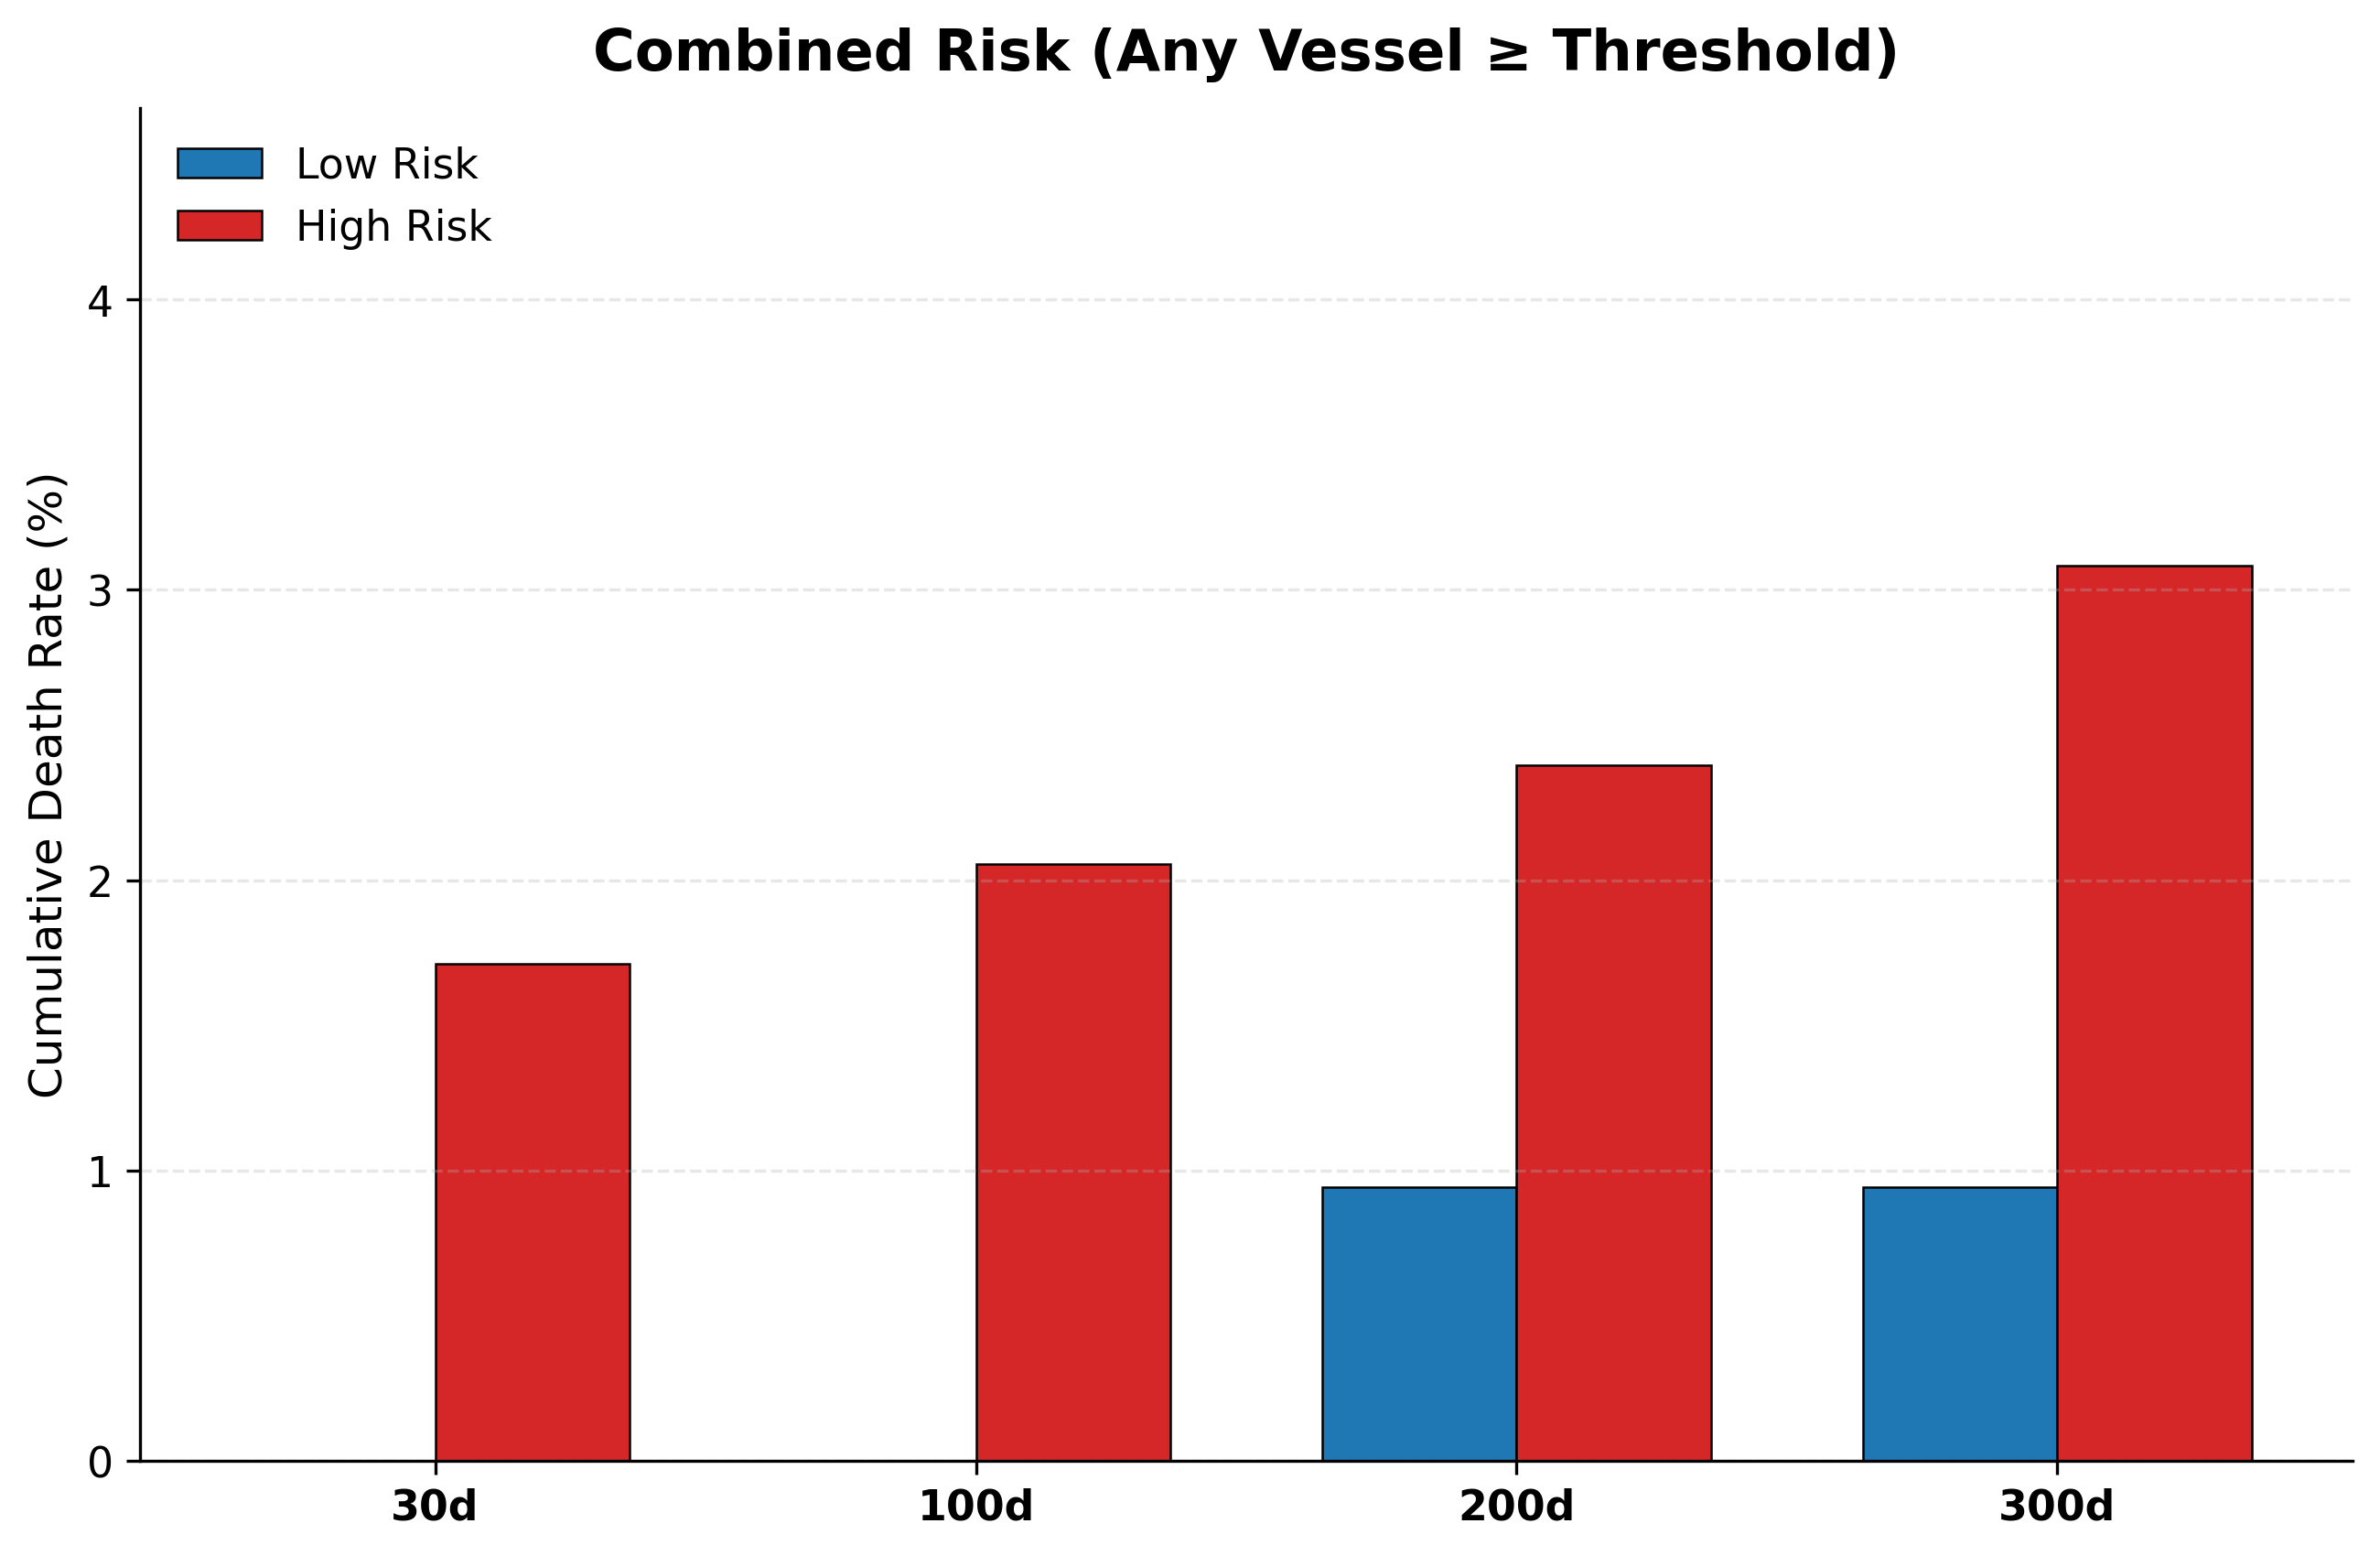

Saved: ./BarDeath_timeWindow_xaxis_abs/DeathBars_TimeAxis_Combined_anyVesselABS.png


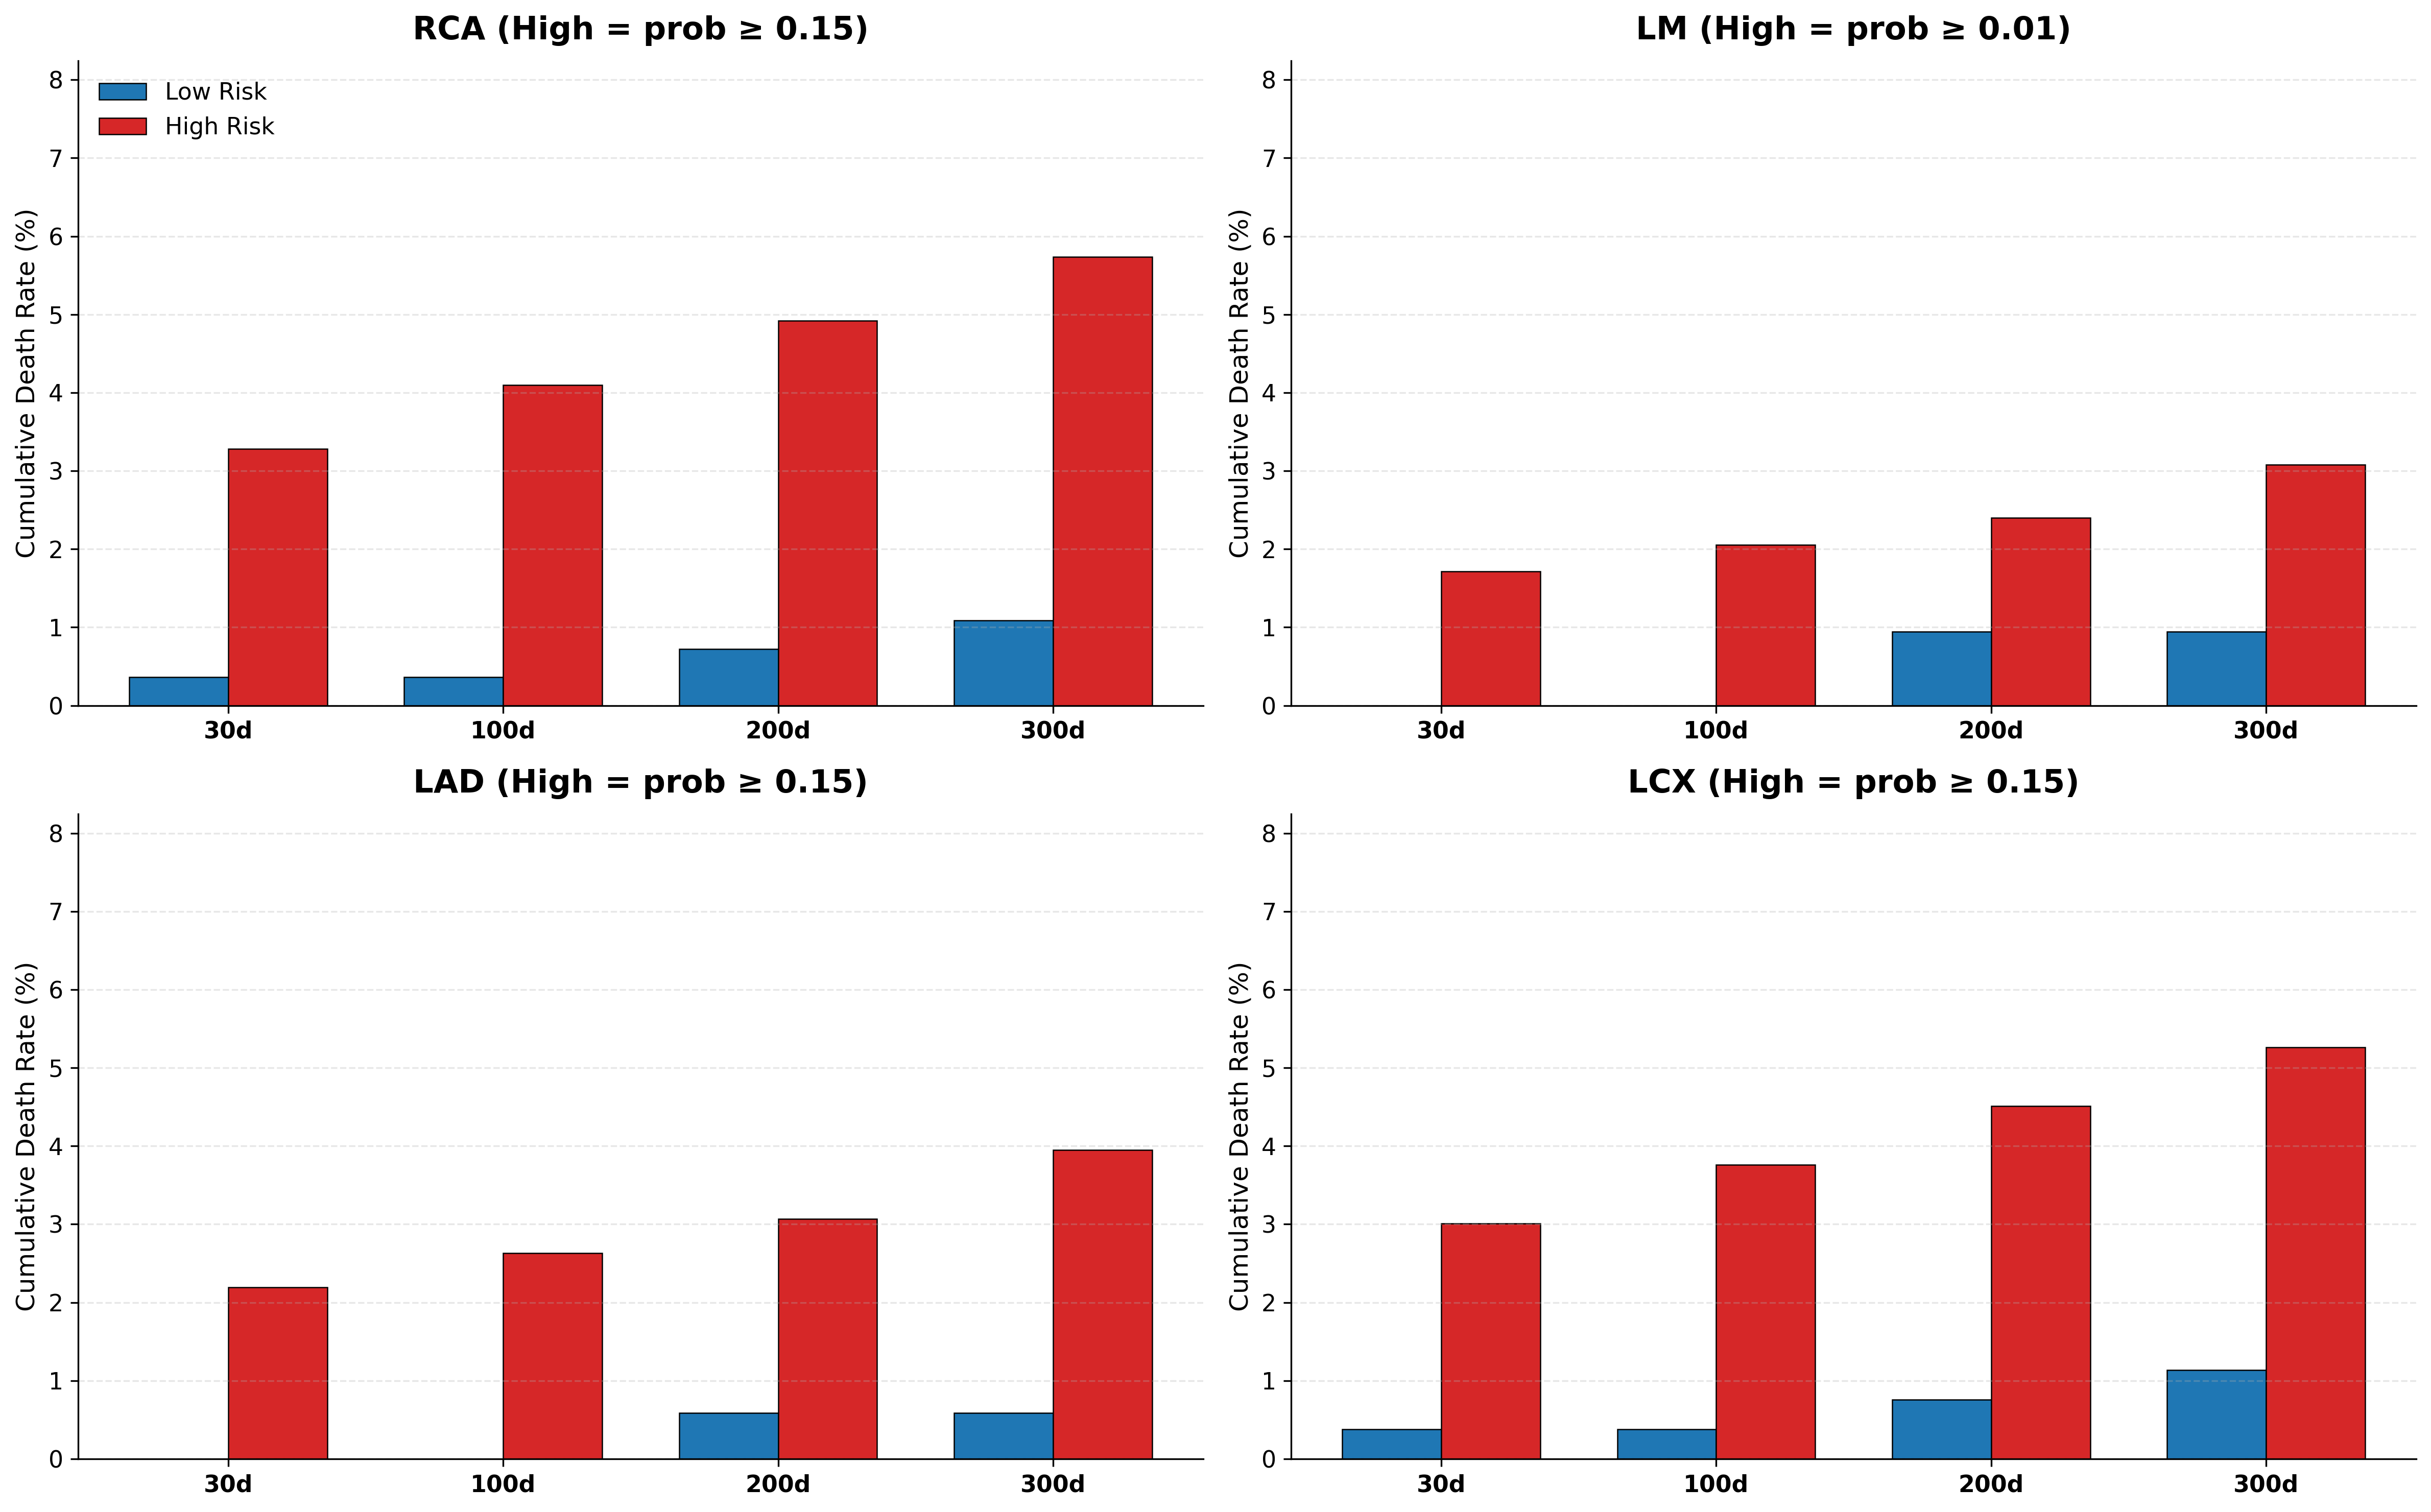

Saved: ./BarDeath_timeWindow_xaxis_abs/DeathBars_TimeAxis_ByVesselABS_2x2.png


In [3]:
# -*- coding: utf-8 -*-
"""
Bar plots of DEATH event rate within time windows (absolute-threshold version):
✅ X-axis = time windows (10d / 100d / 200d / 300d)
✅ For each window, side-by-side bars: Low vs High
✅ Two figures:
   1) Combined (High if ANY vessel prob >= threshold)
   2) Separate 2x2 (each vessel separately: High if that vessel prob >= threshold)
✅ Fixed follow-up window: 700 days (censor >700d)
✅ ADDED: Legend to distinguish Low vs High Risk colors
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==================== Nature-ish style ====================

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['axes.linewidth'] = 0.8

# 定义颜色
RISK_COLORS = {"Low": "#1f77b4", "High": "#d62728"}

# ==================== PATH ====================

CSV_PATH = '/data2/2shared/xiaoyujie/冠脉造影/final/随访_pred.csv'  # ←改成你的文件
OUT_DIR = "./BarDeath_timeWindow_xaxis_abs"
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(CSV_PATH)

# ==================== Endpoint config (Death) ====================

DISCHARGE_COL = "出院日期"
EXAM_TIME_COL = "检查时间"
EVENT_COL = "new_MI"
KM_DAYS_COL = "new_MI_KM（筛选＞28）"

# ==================== Vessel prob columns ====================

PROB_COLUMN_NAMES = [
    '右冠状动脉主干_prob',  # RCA
    '左冠状动脉主干_prob',  # LM
    '左前降支_prob',        # LAD
    '左回旋支_prob'         # LCX
]
VESSEL_NAMES = ['RCA', 'LM', 'LAD', 'LCX']

# ==================== ABSOLUTE thresholds (edit here) ====================

ABS_THR_BY_VESSEL = {"LM": 0.01, "LAD": 0.15, "RCA": 0.15, "LCX": 0.15}
DEFAULT_ABS_THR = 0.15

# ==================== time windows (days) ====================

TIME_POINTS = [30, 100, 200, 300]
TIME_NAMES = ["30d", "100d", "200d", "300d"]

FIXED_FOLLOWUP_DAYS = 700.0

# ==================== Helpers ====================

def to_numeric_series(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

def to_datetime_series(s: pd.Series) -> pd.Series:
    return pd.to_datetime(s, errors="coerce")

def days_between_abs(a: pd.Series, b: pd.Series) -> pd.Series:
    dt_days = (b - a).dt.total_seconds() / 86400.0
    return dt_days.abs()

def build_time_event_from_columns(df_sub: pd.DataFrame, event_col: str, km_days_col: str,
                                  discharge_col: str, exam_col: str):
    discharge_dt = to_datetime_series(df_sub[discharge_col])
    exam_dt = to_datetime_series(df_sub[exam_col])
    base_days = days_between_abs(discharge_dt, exam_dt)

    ev = to_numeric_series(df_sub[event_col]).fillna(0).astype(int)
    ev = (ev == 1).astype(int)

    km_days = to_numeric_series(df_sub[km_days_col])

    time = base_days.copy()
    event_mask = (ev == 1)
    km_ok = event_mask & km_days.notna()
    time.loc[km_ok] = base_days.loc[km_ok] + km_days.loc[km_ok]

    # event but missing km time => censored
    ev.loc[event_mask & km_days.isna()] = 0
    return time, ev

def apply_fixed_followup(time_raw: pd.Series, event_raw: pd.Series, x_max: float):
    time = time_raw.clip(lower=0, upper=x_max).astype(float)
    event = event_raw.copy().astype(int)
    over = (time_raw > x_max)
    event.loc[over] = 0
    time.loc[over] = x_max
    return time, event

# ==================== ABS risk grouping helpers ====================

def risk_group_by_vessel_abs(df_all: pd.DataFrame, vessel: str, prob_col: str) -> pd.Series:
    thr = float(ABS_THR_BY_VESSEL.get(vessel, DEFAULT_ABS_THR))
    p = to_numeric_series(df_all[prob_col])
    high = (p >= thr)
    high = high.fillna(False)
    return pd.Series(np.where(high, "High", "Low"), index=df_all.index)

def risk_group_any_vessel_abs(df_all: pd.DataFrame) -> pd.Series:
    high_any = pd.Series(False, index=df_all.index)
    for prob_col, vessel in zip(PROB_COLUMN_NAMES, VESSEL_NAMES):
        if prob_col not in df_all.columns:
            continue
        thr = float(ABS_THR_BY_VESSEL.get(vessel, DEFAULT_ABS_THR))
        p = to_numeric_series(df_all[prob_col])
        high_any = high_any | (p >= thr)
    high_any = high_any.fillna(False)
    return pd.Series(np.where(high_any, "High", "Low"), index=df_all.index)

# ==================== Data prepare (shared) ====================

def prepare_time_event_df(df0: pd.DataFrame):
    need = [DISCHARGE_COL, EXAM_TIME_COL, EVENT_COL, KM_DAYS_COL]
    for c in need:
        if c not in df0.columns:
            raise KeyError(f"❌ 缺少必要列: {c}")

    sub = df0.copy()
    time_raw, event_raw = build_time_event_from_columns(
        sub, EVENT_COL, KM_DAYS_COL, DISCHARGE_COL, EXAM_TIME_COL
    )

    neg_event_mask = (event_raw == 1) & (time_raw < 0)
    if int(neg_event_mask.sum()) > 0:
        sub = sub.loc[~neg_event_mask].copy()
        time_raw = time_raw.loc[~neg_event_mask].copy()
        event_raw = event_raw.loc[~neg_event_mask].copy()

    ok = time_raw.notna()
    sub = sub.loc[ok].copy()
    time_raw = time_raw.loc[ok].copy()
    event_raw = event_raw.loc[ok].copy()

    time, event = apply_fixed_followup(time_raw, event_raw, FIXED_FOLLOWUP_DAYS)
    return sub, time, event

def compute_rates_by_timewindow(time: pd.Series, event: pd.Series, risk_group: pd.Series):
    out = {}
    for rg in ["Low", "High"]:
        idx = (risk_group == rg)
        n_total = int(idx.sum())
        rates = []
        for t in TIME_POINTS:
            n_evt = int(((event == 1) & (time <= t) & idx).sum())
            r = (n_evt / n_total * 100.0) if n_total > 0 else 0.0
            rates.append(r)
        out[rg] = rates
        out[f"{rg}_n"] = n_total
    return out

# ==================== Plot Function (Updated with Labels) ====================

def plot_timewindow_bars(ax, rates_dict, title, ylim_max=None):
    x = np.arange(len(TIME_POINTS))
    width = 0.36

    low = np.array(rates_dict["Low"], dtype=float)
    high = np.array(rates_dict["High"], dtype=float)

    # 🟢 修改点：添加 label 参数，这样 legend 才能识别
    ax.bar(x - width/2, low, width=width, color=RISK_COLORS["Low"],
           edgecolor='black', linewidth=0.6, label='Low Risk')
    
    ax.bar(x + width/2, high, width=width, color=RISK_COLORS["High"],
           edgecolor='black', linewidth=0.6, label='High Risk')

    ax.set_xticks(x)
    ax.set_xticklabels(TIME_NAMES, fontweight='bold')
    ax.set_ylabel("Cumulative Death Rate (%)")
    ax.set_title(title, fontsize=15, fontweight='bold', pad=10)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    if ylim_max is None:
        m = float(np.nanmax(np.r_[low, high])) if len(low) else 0.0
        ylim_max = max(2, min(100, m * 1.35 + 0.5))
    ax.set_ylim(0, ylim_max)

# ==================== Prepare time/event once ====================

sub_all, time_all, event_all = prepare_time_event_df(df)

# ============================================================
# FIGURE 1: Combined (ANY vessel triggers High) [ABS]
# ============================================================

risk_any = risk_group_any_vessel_abs(sub_all)
rates_any = compute_rates_by_timewindow(time_all, event_all, risk_any)

fig1, ax1 = plt.subplots(1, 1, figsize=(8.8, 5.8), dpi=300)
plot_timewindow_bars(ax1, rates_any, title="Combined Risk (Any Vessel ≥ Threshold)")

# 🟢 显示图例 (因为 bar 里加了 label，这里会自动显示)
ax1.legend(frameon=False, loc="upper left")

plt.tight_layout()
out_png1 = os.path.join(OUT_DIR, "DeathBars_TimeAxis_Combined_anyVesselABS.png")
out_pdf1 = os.path.join(OUT_DIR, "DeathBars_TimeAxis_Combined_anyVesselABS.pdf")
plt.savefig(out_png1, dpi=600)
plt.savefig(out_pdf1)
plt.show()
print("Saved:", out_png1)

# ============================================================
# FIGURE 2: Separate 2x2 by vessel [ABS]
# ============================================================

global_max = 0.0
for prob_col, vessel in zip(PROB_COLUMN_NAMES, VESSEL_NAMES):
    if prob_col not in sub_all.columns:
        continue
    rg = risk_group_by_vessel_abs(sub_all, vessel, prob_col)
    rd = compute_rates_by_timewindow(time_all, event_all, rg)
    global_max = max(global_max, float(np.nanmax(np.r_[rd["Low"], rd["High"]])))

global_ylim = max(2, min(100, global_max * 1.35 + 0.5))

fig2, axes = plt.subplots(2, 2, figsize=(16, 10), dpi=300)
axes = axes.flatten()

for i, (prob_col, vessel) in enumerate(zip(PROB_COLUMN_NAMES, VESSEL_NAMES)):
    ax = axes[i]
    if prob_col not in sub_all.columns:
        ax.axis("off")
        ax.set_title(f"{vessel} (missing prob col)")
        continue

    thr = float(ABS_THR_BY_VESSEL.get(vessel, DEFAULT_ABS_THR))
    rg = risk_group_by_vessel_abs(sub_all, vessel, prob_col)
    rd = compute_rates_by_timewindow(time_all, event_all, rg)

    plot_timewindow_bars(ax, rd, title=f"{vessel} (High = prob ≥ {thr:.2f})", ylim_max=global_ylim)

    # 🟢 仅在第一个子图显示图例，避免重复
    if i == 0:
        ax.legend(frameon=False, loc="upper left")
    else:
        # 如果之前设置了，这里移除它保持整洁
        if ax.get_legend():
            ax.get_legend().remove()

plt.tight_layout()
out_png2 = os.path.join(OUT_DIR, "DeathBars_TimeAxis_ByVesselABS_2x2.png")
out_pdf2 = os.path.join(OUT_DIR, "DeathBars_TimeAxis_ByVesselABS_2x2.pdf")
plt.savefig(out_png2, dpi=600)
plt.savefig(out_pdf2)
plt.show()
print("Saved:", out_png2)


========== Debugging Survival: Myocardial Infarction ==========
!!! 找到 Low 组事件: 发生在第 160.7 天 !!!


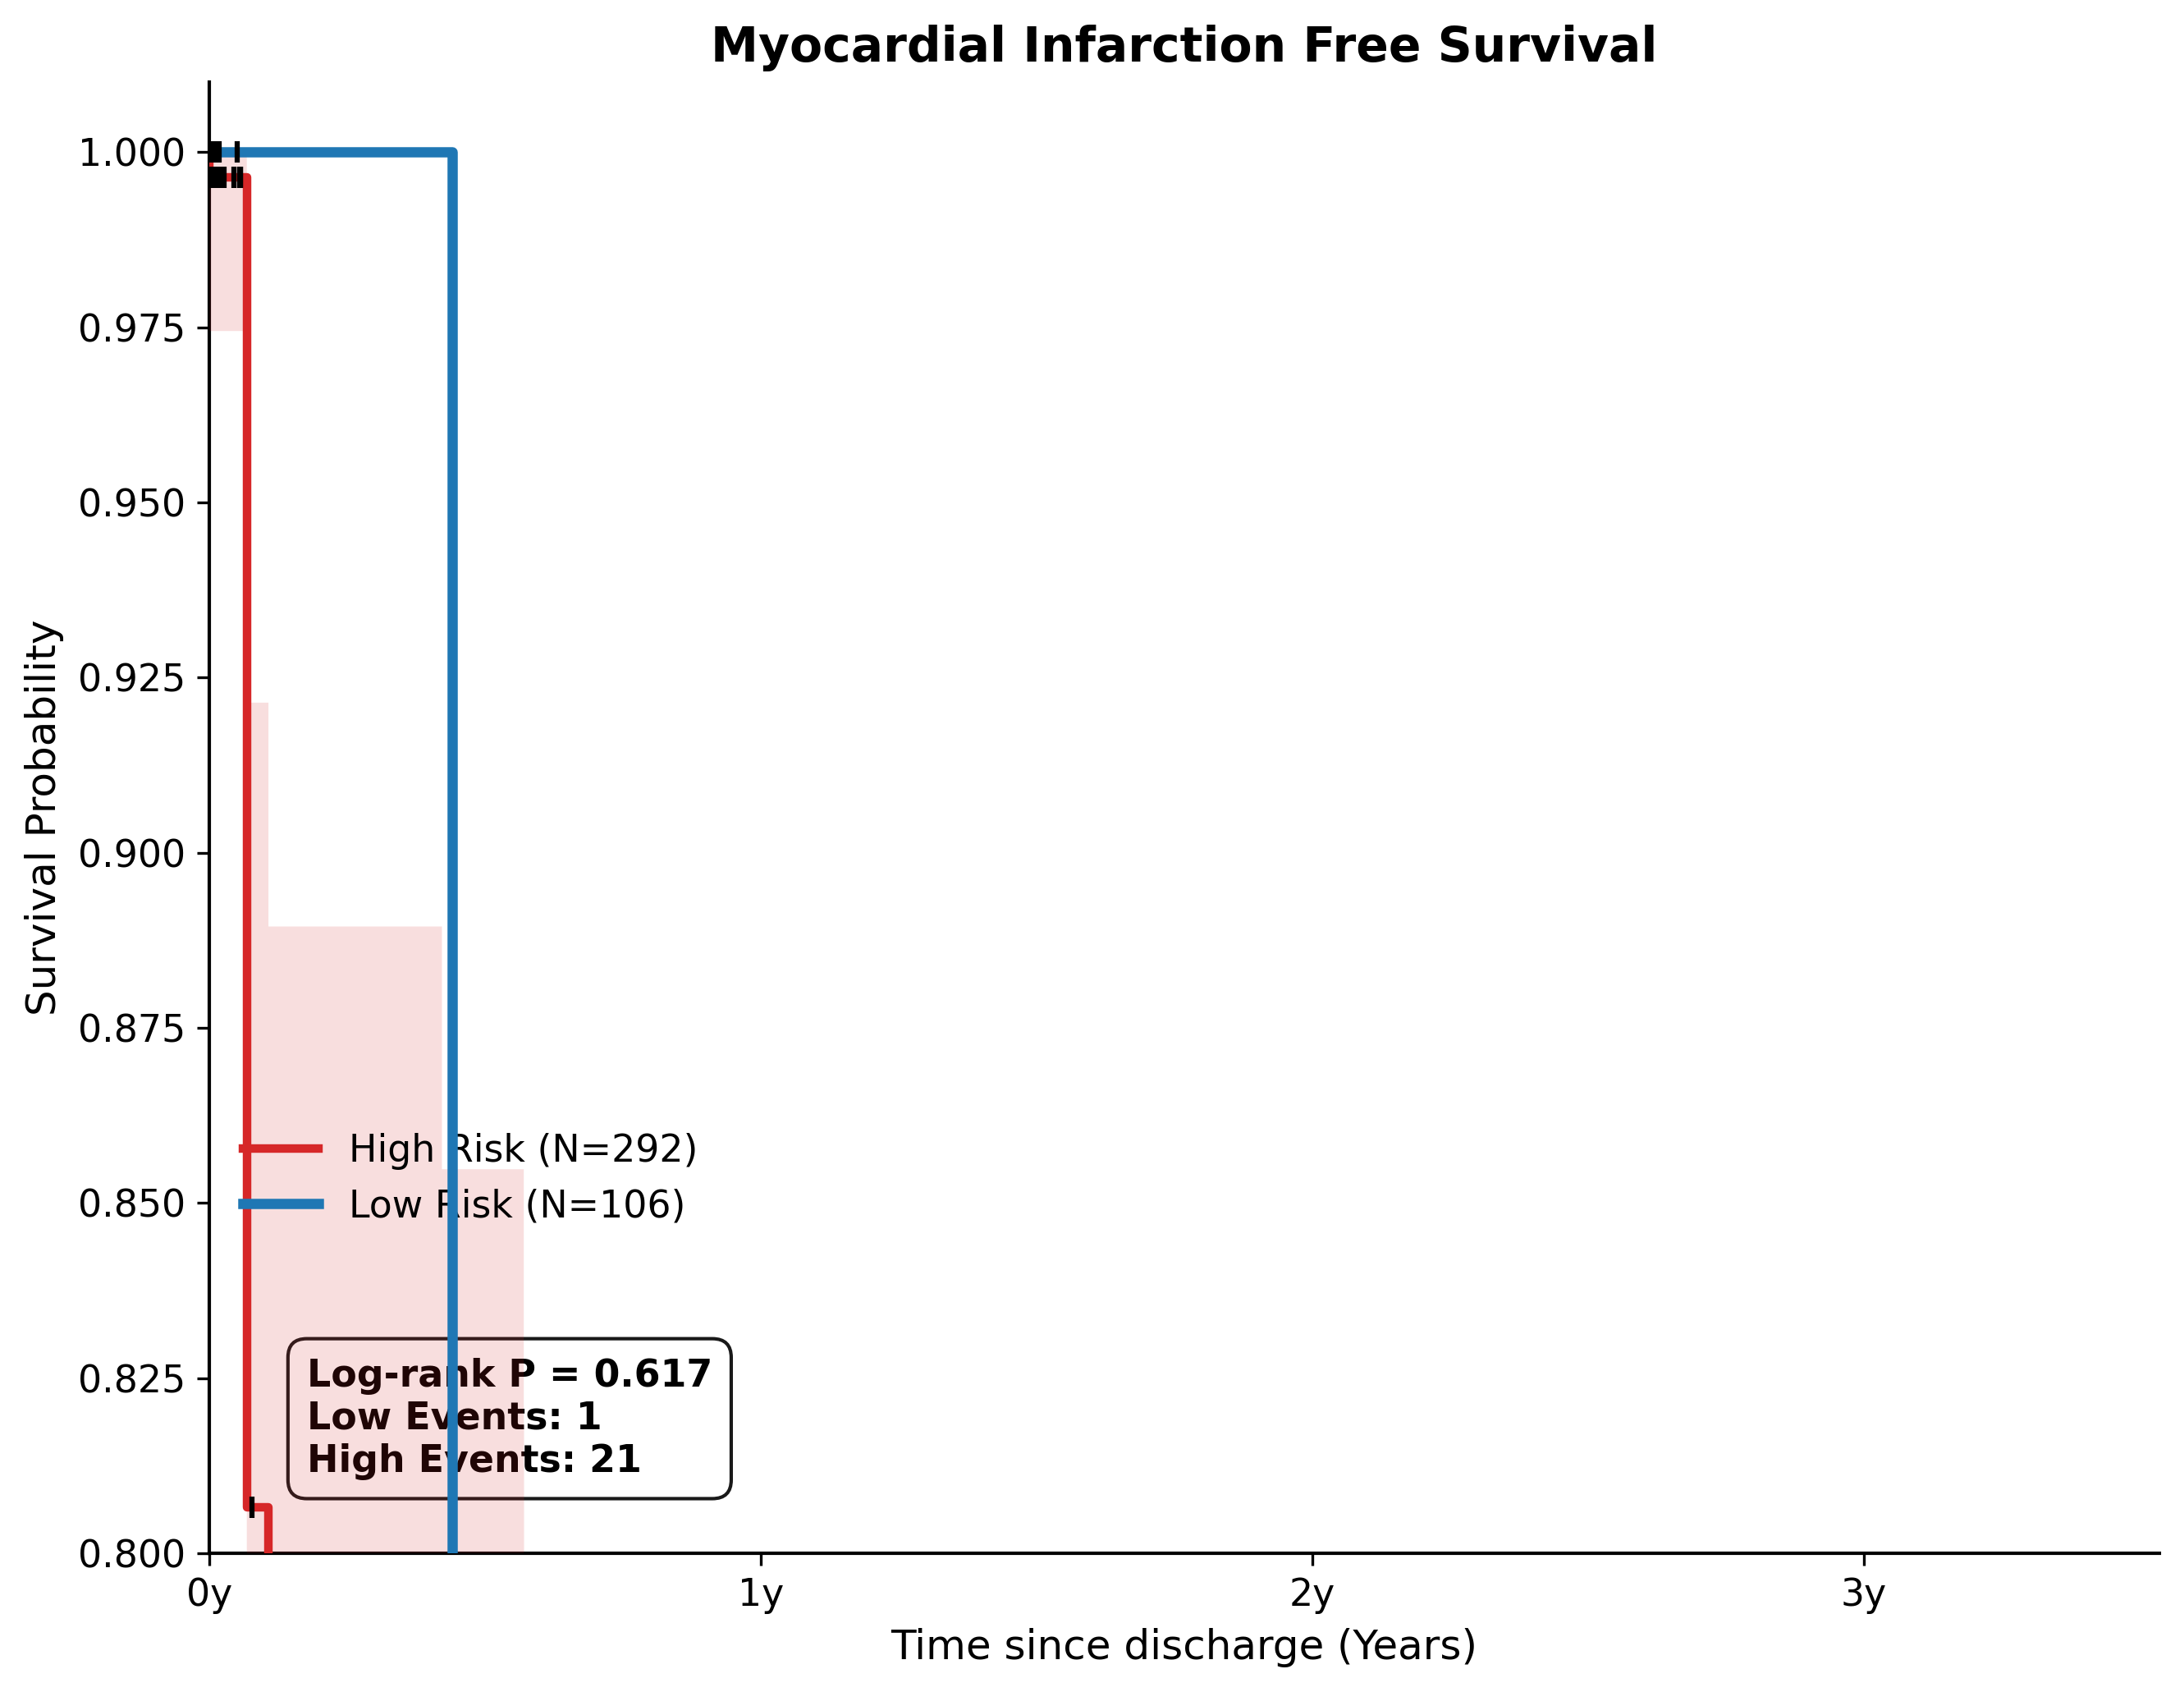

Saved: ./KM_outputs_survival_debug/Survival_MI_debug.png


In [ ]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# ==================== 配置 ====================

# 1. 样式配置
MIN_AT_RISK_COUNT = 5  
SHOW_CENSOR_TICKS = True 
CENSOR_SIZE = 50
CENSOR_COLOR = 'black' # 黑色删失点
RISK_COLORS = { "Low": "#1f77b4", "High": "#d62728" } # 蓝低红高

# 2. 路径 (请确认路径)
CSV_PATH = '/data2/2shared/xiaoyujie/冠脉造影/final/随访_pred.csv'
OUT_DIR = "./KM_outputs_survival"
os.makedirs(OUT_DIR, exist_ok=True)

# 3. 列名
DISCHARGE_COL = "出院日期"
EXAM_TIME_COL = "检查时间"

# 4. 血管配置 (阈值决定了谁进 High 组)
VESSEL_CONFIG = {
    'LM':  {'col': '左冠状动脉主干_prob', 'thresh': 0.01},
    'LAD': {'col': '左前降支_prob',       'thresh': 0.15},
    'RCA': {'col': '右冠状动脉主干_prob', 'thresh': 0.15},
    'LCX': {'col': '左回旋支_prob',       'thresh': 0.15}
}

ENDPOINTS = [
    {"name": "Myocardial Infarction", "event_col": "new_MI", "km_days_col": "new_MI_KM（筛选＞28）", "tag": "MI"},
    {"name": "All-cause Death",       "event_col": "new_death", "km_days_col": "new_death_KM",         "tag": "Death"},
]

# ==================== 辅助函数 ====================

def to_numeric_series(s): return pd.to_numeric(s, errors="coerce")
def to_datetime_series(s): return pd.to_datetime(s, errors="coerce")
def days_between_abs(a, b): return ((b - a).dt.total_seconds() / 86400.0).abs()

def build_time_event(df_sub, event_col, km_days_col):
    discharge = to_datetime_series(df_sub[DISCHARGE_COL])
    exam = to_datetime_series(df_sub[EXAM_TIME_COL])
    base_days = days_between_abs(discharge, exam)
    
    ev = to_numeric_series(df_sub[event_col]).fillna(0).astype(int)
    ev = (ev == 1).astype(int)
    km_days = to_numeric_series(df_sub[km_days_col])
    
    time = base_days.copy()
    mask_event_valid = (ev == 1) & km_days.notna()
    time.loc[mask_event_valid] += km_days.loc[mask_event_valid]
    ev.loc[(ev == 1) & km_days.isna()] = 0 # 缺时间的事件视为删失
    
    return time, ev

# ==================== 核心绘图 (Survival Mode) ====================

def plot_composite_survival(df, endpoint):
    ep_name = endpoint['name']
    event_col = endpoint['event_col']
    km_col = endpoint['km_days_col']
    
    print(f"\n{'='*10} Processing Survival: {ep_name} {'='*10}")
    
    # 1. 准备数据
    all_prob_cols = [cfg['col'] for cfg in VESSEL_CONFIG.values()]
    sub = df.dropna(subset=all_prob_cols + [DISCHARGE_COL, EXAM_TIME_COL]).copy()
    
    # 2. 综合分组 (Patient-level)
    sub['patient_risk'] = 'Low'
    high_mask = pd.Series(False, index=sub.index)
    for v_name, cfg in VESSEL_CONFIG.items():
        prob_s = to_numeric_series(sub[cfg['col']])
        high_mask = high_mask | (prob_s >= cfg['thresh'])
    sub.loc[high_mask, 'patient_risk'] = 'High'

    # 3. 计算时间
    time_s, event_s = build_time_event(sub, event_col, km_col)
    valid_t = (time_s >= 0) & time_s.notna()
    sub = sub.loc[valid_t].copy()
    sub['time'] = time_s.loc[valid_t]
    sub['event'] = event_s.loc[valid_t]
    
    # 调试信息
    for g in ['Low', 'High']:
        d = sub[sub['patient_risk'] == g]
        events = d['event'].sum()
        print(f"Group {g}: N={len(d)}, Events={events} (Rate: {events/len(d) if len(d)>0 else 0:.1%})")

    # Log-rank Test
    n_high = (sub['patient_risk'] == 'High').sum()
    n_low = (sub['patient_risk'] == 'Low').sum()
    p_value = 1.0
    if n_high > 0 and n_low > 0:
        res = logrank_test(
            sub[sub['patient_risk'] == 'High']['time'],
            sub[sub['patient_risk'] == 'Low']['time'],
            event_observed_A=sub[sub['patient_risk'] == 'High']['event'],
            event_observed_B=sub[sub['patient_risk'] == 'Low']['event']
        )
        p_value = res.p_value

    # 4. 绘图 (Survival Curve)
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    
    kmf = KaplanMeierFitter()
    max_plot_time = 0
    min_survival = 1.0 # 用于自动调整Y轴下限
    
    for group in ['Low', 'High']:
        data = sub[sub['patient_risk'] == group]
        if len(data) == 0: continue
        
        kmf.fit(data['time'], data['event'], label=group)
        
        # 截断逻辑
        ev_table = kmf.event_table
        risky_idx = ev_table[ev_table['at_risk'] < MIN_AT_RISK_COUNT].index
        cutoff = risky_idx[0] if len(risky_idx) > 0 else data['time'].max()
        
        # === 关键变化：直接获取 Survival Function (从1开始下降) ===
        sf = kmf.survival_function_
        mask = sf.index <= cutoff
        plot_t = sf.index[mask]
        surv_prob = sf.loc[mask].values.flatten()
        
        if len(surv_prob) == 0: continue
        
        max_plot_time = max(max_plot_time, cutoff)
        min_survival = min(min_survival, surv_prob.min())
        
        # 绘图 (Low组在最上层)
        zorder = 10 if group == 'Low' else 5
        lw = 3.0
        
        ax.step(plot_t, surv_prob, where='post', color=RISK_COLORS[group], 
                lw=lw, label=f"{group} Risk (N={len(data)})", zorder=zorder)
        
        # === 关键变化：CI 也是直接画，不需要 1减 ===
        ci = kmf.confidence_interval_
        ci_lo = ci.loc[mask].iloc[:, 0] # Lower bound
        ci_hi = ci.loc[mask].iloc[:, 1] # Upper bound
        ax.fill_between(plot_t, ci_lo, ci_hi, alpha=0.15, step='post', 
                        color=RISK_COLORS[group], lw=0, zorder=zorder-1)
        
        # 删失点
        if SHOW_CENSOR_TICKS:
            censored = data[data['event'] == 0]['time']
            censored = censored[censored <= cutoff]
            if len(censored) > 0:
                y_vals = []
                for t in censored:
                    idx = sf.index.asof(t)
                    val = sf.loc[idx].values[0] if pd.notna(idx) else 1.0
                    y_vals.append(val)
                ax.scatter(censored, y_vals, marker='|', s=60, color='black', zorder=20)

    # 5. 坐标轴调整
    # X轴
    x_lim = max(max_plot_time * 1.05, 365)
    ax.set_xlim(0, x_lim)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(365))
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda v, p: f"{int(v/365)}y"))
    
    # Y轴：Survival 从 0 到 1.02 (为了留点顶空)
    # 如果你想放大差异，可以设置 bottom = min_survival * 0.9
    # 但标准的生存曲线通常建议保留 0 刻度，除非差异极小
    y_bottom = max(0.0, min_survival - 0.1) # 自动缩放视角
    # y_bottom = 0.0 # 如果想要强制从0开始，请取消注释这一行
    
    ax.set_ylim(y_bottom, 1.02)
    
    # P值文本
    p_text = "P < 0.001" if p_value < 0.001 else f"P = {p_value:.3f}"
    ax.text(0.05, 0.1, f"Log-rank {p_text}", 
            transform=ax.transAxes, va='bottom', fontsize=12, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray", alpha=0.9))
    
    ax.set_xlabel("Time since discharge (Years)", fontsize=12)
    ax.set_ylabel("Survival Probability", fontsize=12) # 改名了
    ax.set_title(f"{ep_name} Free Survival", fontsize=14, fontweight='bold')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='lower left', frameon=False, fontsize=11)
    
    plt.tight_layout()
    out_file = os.path.join(OUT_DIR, f"Survival_{endpoint['tag']}.png")
    plt.savefig(out_file, dpi=300)
    plt.show()
    print(f"Saved: {out_file}")

# 执行
for ep in ENDPOINTS:
    plot_composite_survival(df, ep)

病史

In [3]:
import pandas as pd
import numpy as np
import re

ehr_path = "/data2/2shared/xiaoyujie/冠脉造影/人民5折交叉验证/checkpoint_5fold_轻中度正常/oof_predictions_all_folds.csv"
hx_path  = "/data1/1shared/lijun/data/Renmin/ECG患者基线数据/非隐私信息.就诊基本信息.病史信息.xlsx"

ehr_df = pd.read_csv(ehr_path) if ehr_path.lower().endswith(".csv") else pd.read_excel(ehr_path)
hx_df  = pd.read_csv(hx_path)  if hx_path.lower().endswith(".csv")  else pd.read_excel(hx_path)

ID_COL = "患者编号"   # 连接键
HX_COL = "既往史"     # 既往史文本列

# =========================
# 2) 清洗：id / 既往史文本
# =========================
ehr_df[ID_COL] = ehr_df[ID_COL].astype(str).str.strip()
hx_df[ID_COL]  = hx_df[ID_COL].astype(str).str.strip()

# 只保留需要的两列，避免后面groupby时带入别的列造成混乱
hx_df = hx_df[[ID_COL, HX_COL]].copy()
hx_df[HX_COL] = hx_df[HX_COL].fillna("").astype(str).str.strip()

# =========================
# 3) 先把病史表：同一患者多行合并为一行（并集）
#    得到 hx_merged: [患者编号, 既往史] 且每个患者编号只出现一次
# =========================
def merge_texts(series: pd.Series) -> str:
    """
    把一个患者的多条既往史合并：
    - 去空
    - 去重（完全相同文本去重）
    - 用分隔符拼接
    """
    vals = [v for v in series.astype(str).tolist() if v and v.strip()]
    if not vals:
        return ""
    # 去重（保持出现顺序）
    seen = set()
    uniq = []
    for v in vals:
        if v not in seen:
            uniq.append(v)
            seen.add(v)
    return "；".join(uniq)

hx_merged = (
    hx_df.groupby(ID_COL, as_index=False)[HX_COL]
         .apply(merge_texts)
         .rename(columns={HX_COL: HX_COL})
)

# 可选：检查是否真的一人一行
print("病史合并后患者数:", hx_merged[ID_COL].nunique(), "行数:", len(hx_merged))

# =========================
# 4) 定义关键词/正则 + 否定规则
# =========================
patterns = {
    "既往_糖尿病": r"(糖尿病|DM\b|T1DM|T2DM|2型糖尿病|1型糖尿病)",
    "既往_高血压": r"(高血压|HTN\b|原发性高血压|继发性高血压)",
    "既往_心肌梗死": r"(心肌梗死|MI\b|STEMI|NSTEMI|陈旧性心肌梗死|急性心梗|心梗)",
    "既往_心衰": r"(心力衰竭|心衰|HF\b|CHF\b|慢性心衰|急性心衰)",
}

neg_words = r"(否认|无|未见|没有|不伴|未患|排除)"

def has_condition(text: str, pat: str) -> int:
    if not text:
        return 0
    m = re.search(pat, text, flags=re.IGNORECASE)
    if m is None:
        return 0

    # 简易否定：关键词前后15个字符窗口出现否定词 -> 视为否定
    s, e = m.span()
    left = max(0, s - 15)
    right = min(len(text), e + 15)
    window = text[left:right]
    if re.search(neg_words, window):
        return 0
    return 1

# =========================
# 5) 从“合并后的一人一行病史”提取4列（是/否）
# =========================
hx_feat = hx_merged.copy()
for col, pat in patterns.items():
    hx_feat[col] = hx_feat[HX_COL].apply(lambda x: has_condition(x, pat)).astype(int)

# 0/1 -> 是/否（如果你想保留0/1，把这段注释掉）
for col in patterns.keys():
    hx_feat[col] = hx_feat[col].map({1: "是", 0: "否"})

# hx_feat 最终就是你要的：一个患者编号一行 + 既往史 + 四个标签
# hx_feat columns: [患者编号, 既往史, 既往_糖尿病, 既往_高血压, 既往_心肌梗死, 既往_心衰]

# =========================
# 6) 与 EHR 表按患者编号匹配（左连接：EHR全保留）
# =========================
out = ehr_df.merge(
    hx_feat[[ID_COL] + list(patterns.keys())],  # 如需把“既往史”原文也带过去，可把 HX_COL 也加进来
    on=ID_COL,
    how="left"
)

# 没有病史记录的患者，填“否”
for col in patterns.keys():
    out[col] = out[col].fillna("否")

# =========================
# 7) 保存
# =========================
out_path = "./人民结果_with病史.csv"
out.to_csv(out_path, index=False)

print("✅ 已输出：", out_path)
print("EHR行数：", len(ehr_df), "-> 输出行数：", len(out))
print("病史表原始行数：", len(hx_df), "-> 合并后患者数：", hx_merged[ID_COL].nunique(), "（行数：", len(hx_merged), "）")
print("新增列：", list(patterns.keys()))


病史合并后患者数: 77785 行数: 77785
✅ 已输出： ./人民结果_with病史.csv
EHR行数： 4620 -> 输出行数： 4620
病史表原始行数： 187760 -> 合并后患者数： 77785 （行数： 77785 ）
新增列： ['既往_糖尿病', '既往_高血压', '既往_心肌梗死', '既往_心衰']


In [4]:
print(out['既往_糖尿病'].value_counts())
print(out['既往_高血压'].value_counts())
print(out['既往_心肌梗死'].value_counts())
print(out['既往_心衰'].value_counts())

既往_糖尿病
否    3187
是    1433
Name: count, dtype: int64
既往_高血压
是    2411
否    2209
Name: count, dtype: int64
既往_心肌梗死
否    4427
是     193
Name: count, dtype: int64
既往_心衰
否    4575
是      45
Name: count, dtype: int64


亚组分析

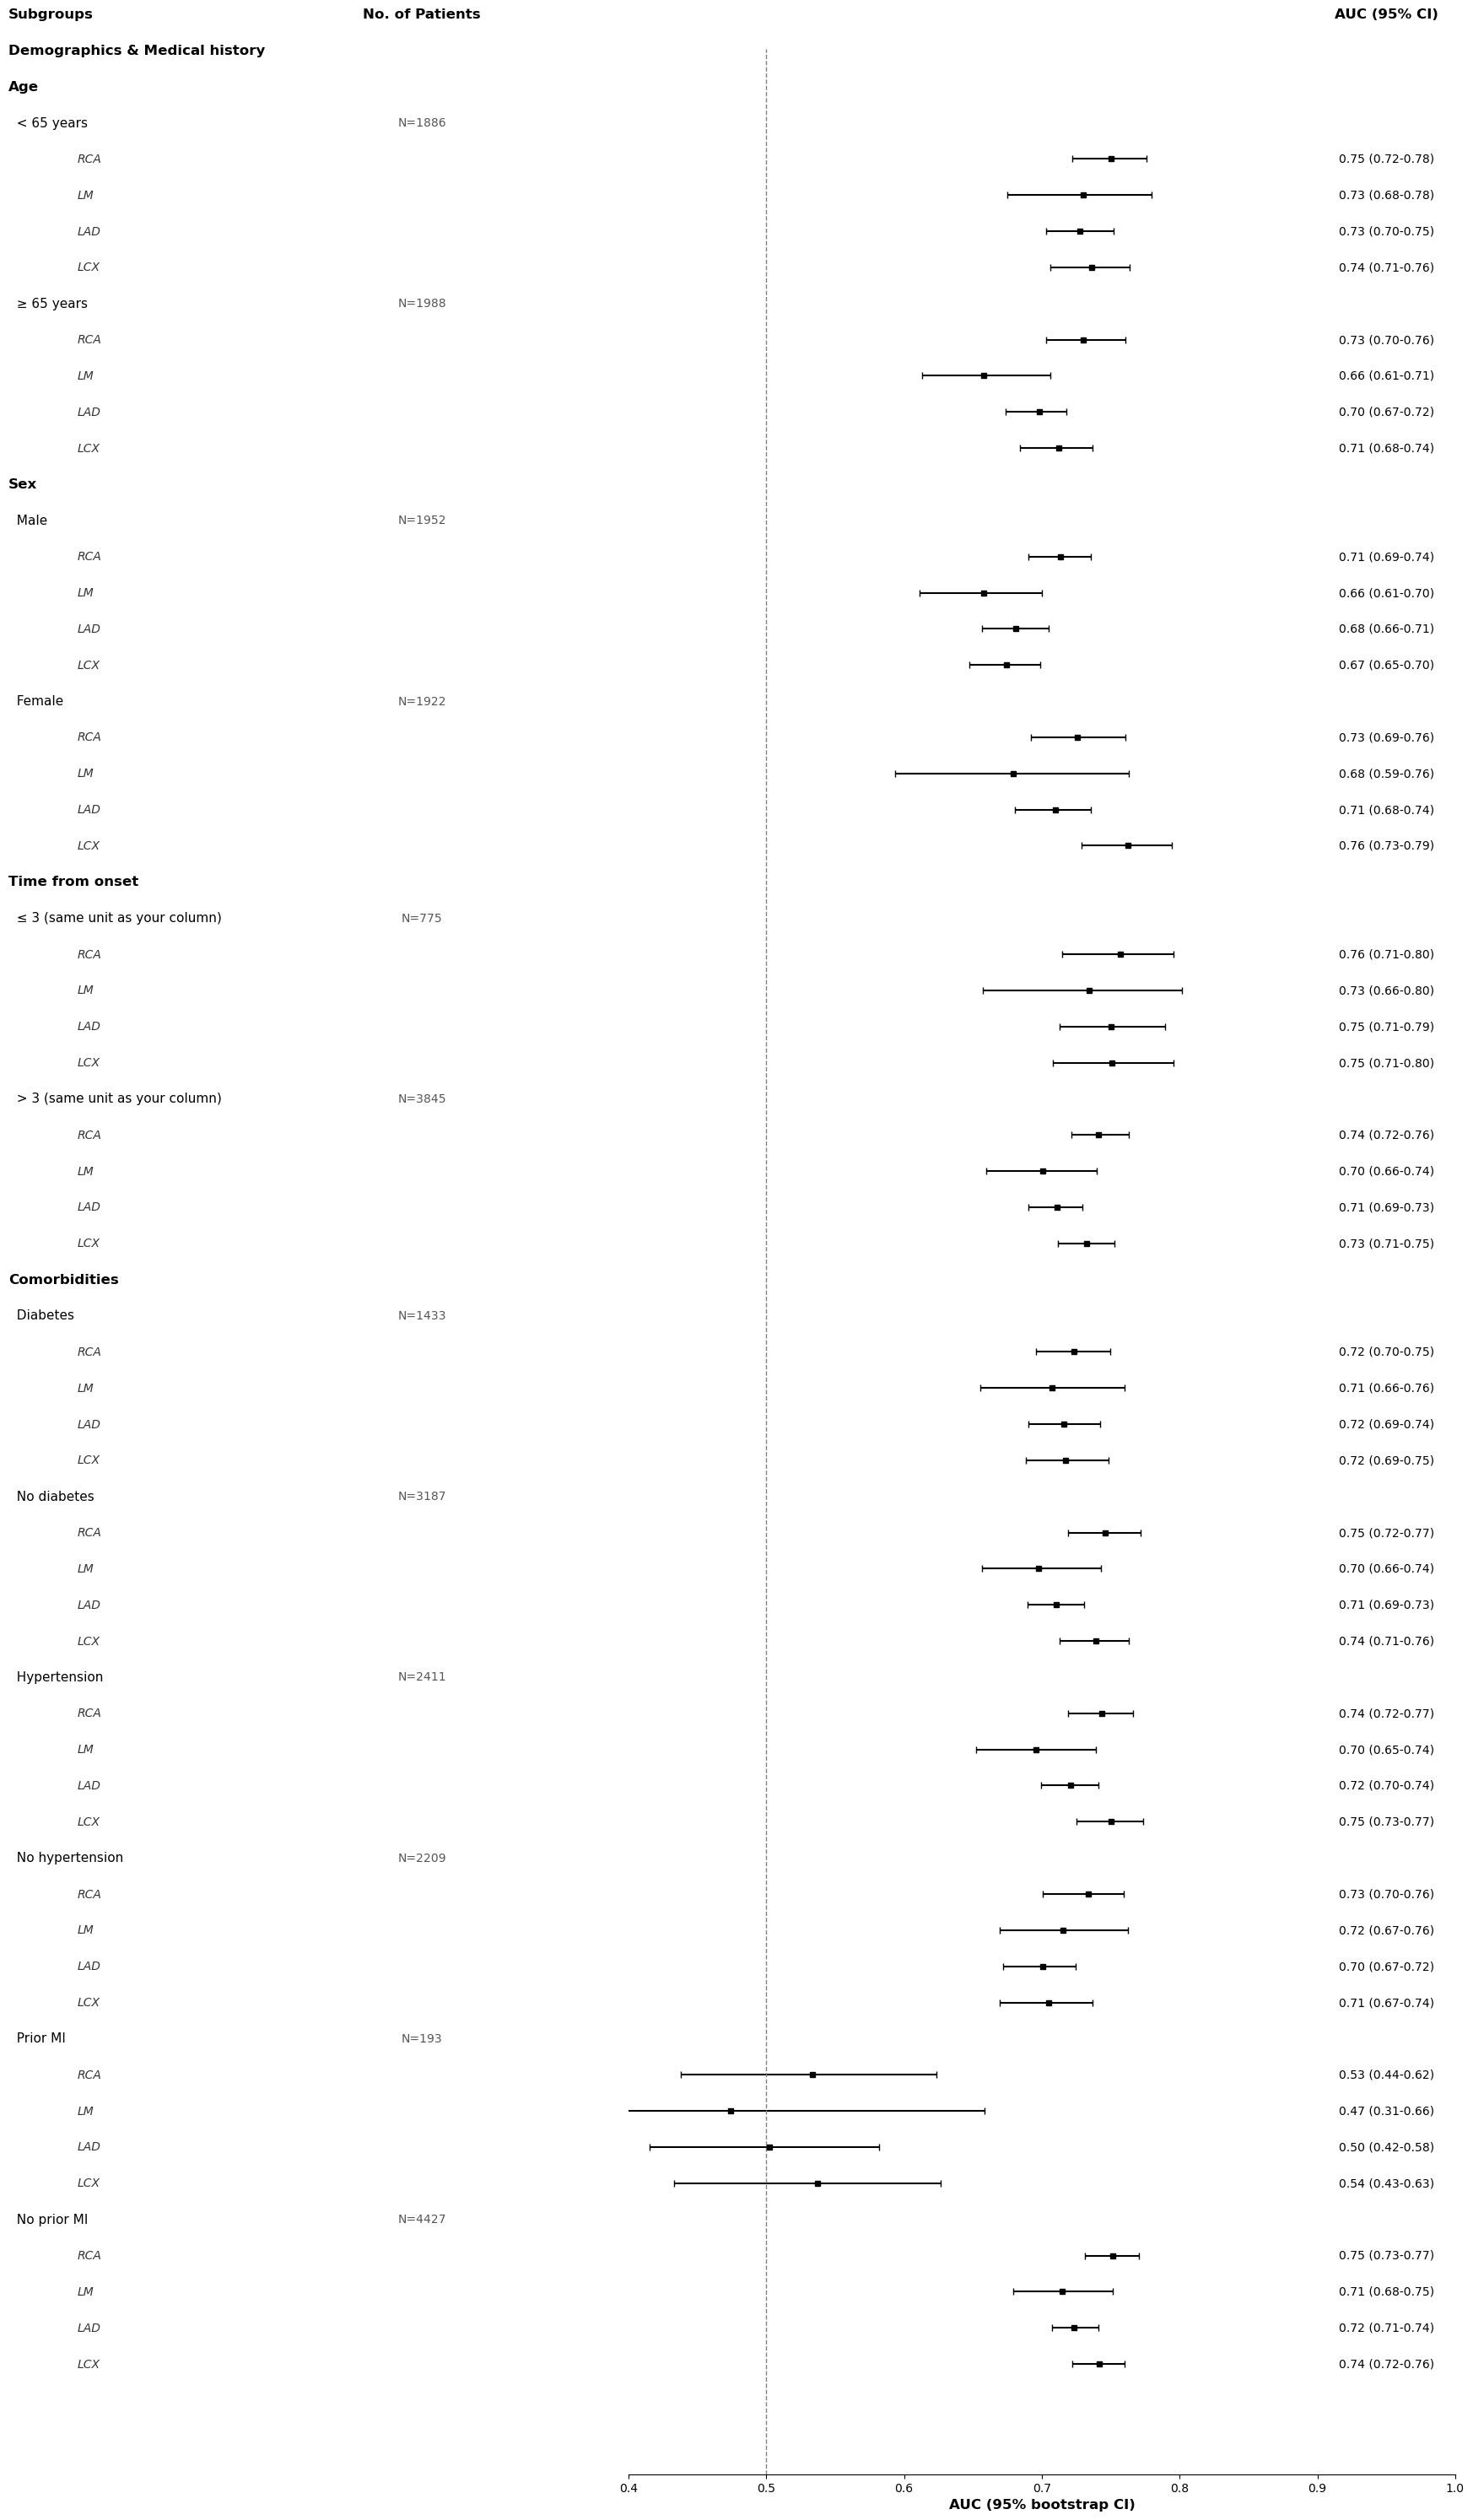

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# ================= 1. 配置与数据读取 =================
input_file = '/data2/2shared/xiaoyujie/冠脉造影/final/人民结果_with病史_性别年龄.csv'
df = pd.read_csv(input_file)

artery_map = {
    '右冠状动脉主干': 'RCA',
    '左冠状动脉主干': 'LM',
    '左前降支': 'LAD',
    '左回旋支': 'LCX'
}

# ================= 2. 必要列检查 =================
required_cols = ['age', '性别_labeled', '既往_糖尿病', '既往_高血压', '既往_心肌梗死']  # ✅ 不做心衰
for cn in artery_map.keys():
    required_cols += [f"{cn}_label", f"{cn}_prob"]

missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"缺少必要列：{missing}\n当前df列名示例：{df.columns.tolist()[:60]} ...")

# ================= 3. 统一把“是/否/0/1/True/False/空值”等转成 0/1 =================
def to01(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, np.integer, float, np.floating, bool, np.bool_)):
        try:
            v = float(x)
            if np.isnan(v):
                return np.nan
            return 1 if v >= 1 else 0
        except Exception:
            pass
    s = str(x).strip().lower()
    if s in {"1", "true", "t", "yes", "y", "是", "有", "阳性", "positive"}:
        return 1
    if s in {"0", "false", "f", "no", "n", "否", "无", "阴性", "negative"}:
        return 0
    try:
        v = float(s)
        return 1 if v >= 1 else 0
    except Exception:
        return np.nan

# 既往史三列
hx_cols = ['既往_糖尿病', '既往_高血压', '既往_心肌梗死']
for c in hx_cols:
    df[c] = df[c].apply(to01)

# 血管 label
for cn in artery_map.keys():
    df[f"{cn}_label"] = df[f"{cn}_label"].apply(to01)

# 性别
df['性别_labeled'] = df['性别_labeled'].apply(to01)

# 年龄
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# ================= 4. 时间差天数处理（加入亚组） =================
# 支持两种列名：时间差天数 或 abs_time_diff
time_col = None
if '时间差天数' in df.columns:
    df['abs_time_diff'] = pd.to_numeric(df['时间差天数'], errors='coerce').abs()
    time_col = 'abs_time_diff'
elif 'abs_time_diff' in df.columns:
    df['abs_time_diff'] = pd.to_numeric(df['abs_time_diff'], errors='coerce')
    time_col = 'abs_time_diff'
else:
    print("⚠️ 未找到 '时间差天数' 或 'abs_time_diff' 列，将跳过 Time from onset 亚组。")

# 你原来是 <=3 hours / >3 hours
# 如果你的“时间差天数”其实是“天”，那阈值就不该用 3（小时）。
# 这里严格按你的原始写法：阈值=3（单位由你数据决定）。
time_threshold = 3

# ================= 5. 定义亚组（放一起在上面做AUC） =================
subgroup_definitions = [
    ('Demographics & Medical history', None),

    ('Age', None),
    ('  < 65 years', df['age'] < 65),
    ('  ≥ 65 years', df['age'] >= 65),

    ('Sex', None),
    ('  Male', df['性别_labeled'] == 1),
    ('  Female', df['性别_labeled'] == 0),
]

# 加入时间差亚组
if time_col is not None:
    subgroup_definitions += [
        ('Time from onset', None),
        (f'  ≤ {time_threshold} (same unit as your column)', df[time_col] <= time_threshold),
        (f'  > {time_threshold} (same unit as your column)', df[time_col] > time_threshold),
    ]

# 既往史（不含心衰）
subgroup_definitions += [
    ('Comorbidities', None),
    ('  Diabetes', df['既往_糖尿病'] == 1),
    ('  No diabetes', df['既往_糖尿病'] == 0),
    ('  Hypertension', df['既往_高血压'] == 1),
    ('  No hypertension', df['既往_高血压'] == 0),
    ('  Prior MI', df['既往_心肌梗死'] == 1),
    ('  No prior MI', df['既往_心肌梗死'] == 0),
]

# ================= 6. 计算 AUC + bootstrap CI =================
plot_rows = []
n_bootstraps = 500
rng = np.random.RandomState(42)

for label, mask in subgroup_definitions:
    if mask is None:
        plot_rows.append({'type': 'header', 'label': label})
        continue

    subset = df[mask].copy()
    plot_rows.append({'type': 'subgroup_title', 'label': label, 'n': len(subset)})

    for cn_name, en_name in artery_map.items():
        label_col = f"{cn_name}_label"
        prob_col  = f"{cn_name}_prob"

        y_true = subset[label_col].values
        y_score = subset[prob_col].values

        valid = ~np.isnan(y_true) & ~np.isnan(y_score)
        y_true = y_true[valid].astype(int)
        y_score = y_score[valid].astype(float)

        # AUC 需要同时有0/1
        if len(y_true) == 0 or len(np.unique(y_true)) < 2:
            plot_rows.append({
                'type': 'data', 'label': en_name,
                'auc': np.nan, 'ci_low': np.nan, 'ci_high': np.nan,
                'n': len(y_true)
            })
            continue

        auc = roc_auc_score(y_true, y_score)

        boot_scores = []
        for _ in range(n_bootstraps):
            idx = rng.randint(0, len(y_score), len(y_score))
            if len(np.unique(y_true[idx])) < 2:
                continue
            boot_scores.append(roc_auc_score(y_true[idx], y_score[idx]))

        if len(boot_scores) < 10:
            ci_low, ci_high = np.nan, np.nan
        else:
            boot_scores = np.sort(np.array(boot_scores))
            ci_low = boot_scores[int(0.025 * len(boot_scores))]
            ci_high = boot_scores[int(0.975 * len(boot_scores))]

        plot_rows.append({
            'type': 'data', 'label': en_name,
            'auc': auc, 'ci_low': ci_low, 'ci_high': ci_high,
            'n': len(y_true)
        })

# ================= 7. 绘制森林图（仅AUC） =================
plot_rows = plot_rows[::-1]
fig_height = len(plot_rows) * 0.45 + 2
fig, ax = plt.subplots(figsize=(14, fig_height))

col_labels_x = -0.05
col_n_x = 0.25
col_val_x = 0.95

for i, row in enumerate(plot_rows):
    y = i
    if row['type'] == 'header':
        ax.text(col_labels_x, y, row['label'], fontweight='bold', fontsize=12, va='center', ha='left')
    elif row['type'] == 'subgroup_title':
        ax.text(col_labels_x, y, row['label'], fontsize=11, va='center', ha='left')
        ax.text(col_n_x, y, f"N={row['n']}", fontsize=10, va='center', ha='center', color='#555555')
    elif row['type'] == 'data':
        ax.text(col_labels_x + 0.05, y, row['label'], fontsize=10, va='center', ha='left',
                style='italic', color='#333333')

        if not np.isnan(row['auc']):
            x_err_low = row['auc'] - row['ci_low'] if not np.isnan(row['ci_low']) else 0
            x_err_high = row['ci_high'] - row['auc'] if not np.isnan(row['ci_high']) else 0

            ax.errorbar(row['auc'], y, xerr=[[x_err_low], [x_err_high]],
                        fmt='s', color='black', ecolor='black', capsize=3, markersize=5)

            if np.isnan(row['ci_low']) or np.isnan(row['ci_high']):
                text = f"{row['auc']:.2f} (CI N/A)"
            else:
                text = f"{row['auc']:.2f} ({row['ci_low']:.2f}-{row['ci_high']:.2f})"

            ax.text(col_val_x, y, text, fontsize=10, va='center', ha='center')
        else:
            ax.text(col_val_x, y, "N/A", fontsize=10, va='center', ha='center', color='red')

ax.set_xlim(0.4, 1.0)
ax.set_xlabel("AUC (95% bootstrap CI)", fontsize=12, fontweight='bold')
ax.axvline(x=0.5, linestyle='--', color='gray', linewidth=1)
ax.set_yticks([])
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)

top_y = len(plot_rows)
ax.text(col_labels_x, top_y, "Subgroups", fontweight='bold', fontsize=12, va='center', ha='left')
ax.text(col_n_x, top_y, "No. of Patients", fontweight='bold', fontsize=12, va='center', ha='center')
ax.text(col_val_x, top_y, "AUC (95% CI)", fontweight='bold', fontsize=12, va='center', ha='center')

plt.subplots_adjust(left=0.2, right=0.9, top=0.97, bottom=0.05)
plt.show()


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

# ================= 1. 配置与数据读取 =================
input_file = '/data2/2shared/xiaoyujie/冠脉造影/final/人民结果_with病史_性别年龄.csv'
df = pd.read_csv(input_file)

artery_map = {
    '右冠状动脉主干': 'RCA',
    '左冠状动脉主干': 'LM',
    '左前降支': 'LAD',
    '左回旋支': 'LCX'
}

# ================= 2. 必要列检查 =================
required_cols = ['age', '性别_labeled', '既往_糖尿病', '既往_高血压', '既往_心肌梗死']
for cn in artery_map.keys():
    required_cols += [f"{cn}_label", f"{cn}_prob"]

missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"缺少必要列：{missing}\n当前df列名示例：{df.columns.tolist()[:80]} ...")

# ================= 3. 统一把“是/否/0/1/True/False/空值”等转成 0/1 =================
def to01(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, np.integer, float, np.floating, bool, np.bool_)):
        try:
            v = float(x)
            if np.isnan(v):
                return np.nan
            return 1 if v >= 1 else 0
        except Exception:
            pass
    s = str(x).strip().lower()
    if s in {"1", "true", "t", "yes", "y", "是", "有", "阳性", "positive"}:
        return 1
    if s in {"0", "false", "f", "no", "n", "否", "无", "阴性", "negative"}:
        return 0
    try:
        v = float(s)
        return 1 if v >= 1 else 0
    except Exception:
        return np.nan

# 既往史三列
hx_cols = ['既往_糖尿病', '既往_高血压', '既往_心肌梗死']
for c in hx_cols:
    df[c] = df[c].apply(to01)

# 血管 label
for cn in artery_map.keys():
    df[f"{cn}_label"] = df[f"{cn}_label"].apply(to01)

# 性别
df['性别_labeled'] = df['性别_labeled'].apply(to01)

# 年龄
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# ================= 4. 时间差天数处理（可选） =================
time_col = None
if '时间差天数' in df.columns:
    df['abs_time_diff'] = pd.to_numeric(df['时间差天数'], errors='coerce').abs()
    time_col = 'abs_time_diff'
elif 'abs_time_diff' in df.columns:
    df['abs_time_diff'] = pd.to_numeric(df['abs_time_diff'], errors='coerce')
    time_col = 'abs_time_diff'
else:
    print("⚠️ 未找到 '时间差天数' 或 'abs_time_diff' 列，将跳过 Time from onset 亚组。")

time_threshold = 3  # 仍按你原始逻辑：阈值=3（单位取决于你的列）

# ================= 5. 统一的 AUC + bootstrap CI 计算函数 =================
def auc_with_bootstrap_ci(y_true, y_score, n_boot=500, seed=42):
    """
    y_true: 0/1
    y_score: float prob
    return: auc, ci_low, ci_high, n_valid
    """
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)

    valid = ~np.isnan(y_true) & ~np.isnan(y_score)
    y_true = y_true[valid].astype(int)
    y_score = y_score[valid].astype(float)
    n_valid = len(y_true)

    if n_valid == 0 or len(np.unique(y_true)) < 2:
        return np.nan, np.nan, np.nan, n_valid

    auc = roc_auc_score(y_true, y_score)

    rng = np.random.RandomState(seed)
    boot_scores = []
    for _ in range(n_boot):
        idx = rng.randint(0, n_valid, n_valid)
        if len(np.unique(y_true[idx])) < 2:
            continue
        boot_scores.append(roc_auc_score(y_true[idx], y_score[idx]))

    if len(boot_scores) < 10:
        return auc, np.nan, np.nan, n_valid

    boot_scores = np.sort(np.array(boot_scores))
    ci_low = boot_scores[int(0.025 * len(boot_scores))]
    ci_high = boot_scores[int(0.975 * len(boot_scores))]
    return auc, ci_low, ci_high, n_valid

# ================= 6. 定义基础亚组（人口学、既往史、时间） =================
subgroups = []

# Age
subgroups += [
    ("Age", "< 65 years", df['age'] < 65),
    ("Age", "≥ 65 years", df['age'] >= 65),
]

# Sex
subgroups += [
    ("Sex", "Male", df['性别_labeled'] == 1),
    ("Sex", "Female", df['性别_labeled'] == 0),
]

# Time from onset (optional)
if time_col is not None:
    subgroups += [
        ("Time from onset", f"≤ {time_threshold} (same unit as column)", df[time_col] <= time_threshold),
        ("Time from onset", f"> {time_threshold} (same unit as column)", df[time_col] > time_threshold),
    ]

# Comorbidities
subgroups += [
    ("Comorbidities", "Diabetes", df['既往_糖尿病'] == 1),
    ("Comorbidities", "No diabetes", df['既往_糖尿病'] == 0),
    ("Comorbidities", "Hypertension", df['既往_高血压'] == 1),
    ("Comorbidities", "No hypertension", df['既往_高血压'] == 0),
    ("Comorbidities", "Prior MI", df['既往_心肌梗死'] == 1),
    ("Comorbidities", "No prior MI", df['既往_心肌梗死'] == 0),
]

# ================= 7. 新增：按“某条血管是否重度/闭塞”分层的亚组分析 =================
# 例如：RCA severe vs non-severe，然后只评估 LM/LAD/LCX（不输出 RCA 自己）
severity_subgroups = []
for cn_name, en_name in artery_map.items():
    label_col = f"{cn_name}_label"

    severity_subgroups += [
        (f"Stratified by {en_name} severity", f"{en_name}: Severe/occlusion (label=1)", df[label_col] == 1, en_name),
        (f"Stratified by {en_name} severity", f"{en_name}: Non-severe (label=0)", df[label_col] == 0, en_name),
    ]
# 这里 severity_subgroups 的最后一个字段 stratify_vessel 用于“排除自身”

# ================= 8. 计算结果并输出表格 =================
rows = []
N_BOOT = 500
SEED = 42

def add_results_for_subset(subset_df, group_cat, group_name, exclude_vessel=None):
    # subset 总样本量（不要求 label/prob 都有效）
    n_subset = len(subset_df)

    for cn_name, en_name in artery_map.items():
        # 如果指定排除某条血管（比如按RCA分层时，不输出RCA）
        if exclude_vessel is not None and en_name == exclude_vessel:
            continue

        label_col = f"{cn_name}_label"
        prob_col = f"{cn_name}_prob"

        auc, ci_low, ci_high, n_valid = auc_with_bootstrap_ci(
            subset_df[label_col].values,
            subset_df[prob_col].values,
            n_boot=N_BOOT,
            seed=SEED
        )

        rows.append({
            "group_category": group_cat,
            "subgroup": group_name,
            "subset_N": n_subset,
            "target_vessel": en_name,
            "valid_N_for_auc": n_valid,
            "auc": auc,
            "ci_low": ci_low,
            "ci_high": ci_high
        })

# 8.1 基础亚组：每个亚组都对四条血管输出
for group_cat, group_name, mask in subgroups:
    subset = df[mask].copy()
    add_results_for_subset(subset, group_cat, group_name, exclude_vessel=None)

# 8.2 狭窄严重程度分层亚组：每个分层下“排除自身血管”
for group_cat, group_name, mask, stratify_vessel in severity_subgroups:
    subset = df[mask].copy()
    add_results_for_subset(subset, group_cat, group_name, exclude_vessel=stratify_vessel)

result_df = pd.DataFrame(rows)

# 让显示更友好
def fmt_row(r):
    if pd.isna(r["auc"]):
        return "N/A"
    if pd.isna(r["ci_low"]) or pd.isna(r["ci_high"]):
        return f'{r["auc"]:.3f} (CI N/A)'
    return f'{r["auc"]:.3f} ({r["ci_low"]:.3f}-{r["ci_high"]:.3f})'

result_df["AUC (95% CI)"] = result_df.apply(fmt_row, axis=1)

# 排序：先基础亚组，再严重程度分层
result_df["group_order"] = result_df["group_category"].apply(lambda x: 1 if x.startswith("Stratified by") else 0)
result_df = result_df.sort_values(
    by=["group_order", "group_category", "subgroup", "target_vessel"],
    ascending=[True, True, True, True]
).drop(columns=["group_order"])

# 你最终要“输出表格”：给一个常用的展示列集合
out_df = result_df[[
    "group_category", "subgroup", "subset_N",
    "target_vessel", "valid_N_for_auc",
    "auc", "ci_low", "ci_high", "AUC (95% CI)"
]].reset_index(drop=True)

print(out_df.head(30))

# ================= 9. 保存结果 =================
out_csv = "/data2/2shared/xiaoyujie/冠脉造影/final/subgroup_auc_results.csv"
out_xlsx = "/data2/2shared/xiaoyujie/冠脉造影/final/subgroup_auc_results.xlsx"

out_df.to_csv(out_csv, index=False, encoding="utf-8-sig")
out_df.to_excel(out_xlsx, index=False)

print(f"\n✅ Saved:\n- {out_csv}\n- {out_xlsx}")


   group_category         subgroup  subset_N target_vessel  valid_N_for_auc  \
0             Age       < 65 years      1886           LAD             1886   
1             Age       < 65 years      1886           LCX             1886   
2             Age       < 65 years      1886            LM             1886   
3             Age       < 65 years      1886           RCA             1886   
4             Age       ≥ 65 years      1988           LAD             1988   
5             Age       ≥ 65 years      1988           LCX             1988   
6             Age       ≥ 65 years      1988            LM             1988   
7             Age       ≥ 65 years      1988           RCA             1988   
8   Comorbidities         Diabetes      1433           LAD             1433   
9   Comorbidities         Diabetes      1433           LCX             1433   
10  Comorbidities         Diabetes      1433            LM             1433   
11  Comorbidities         Diabetes      1433        

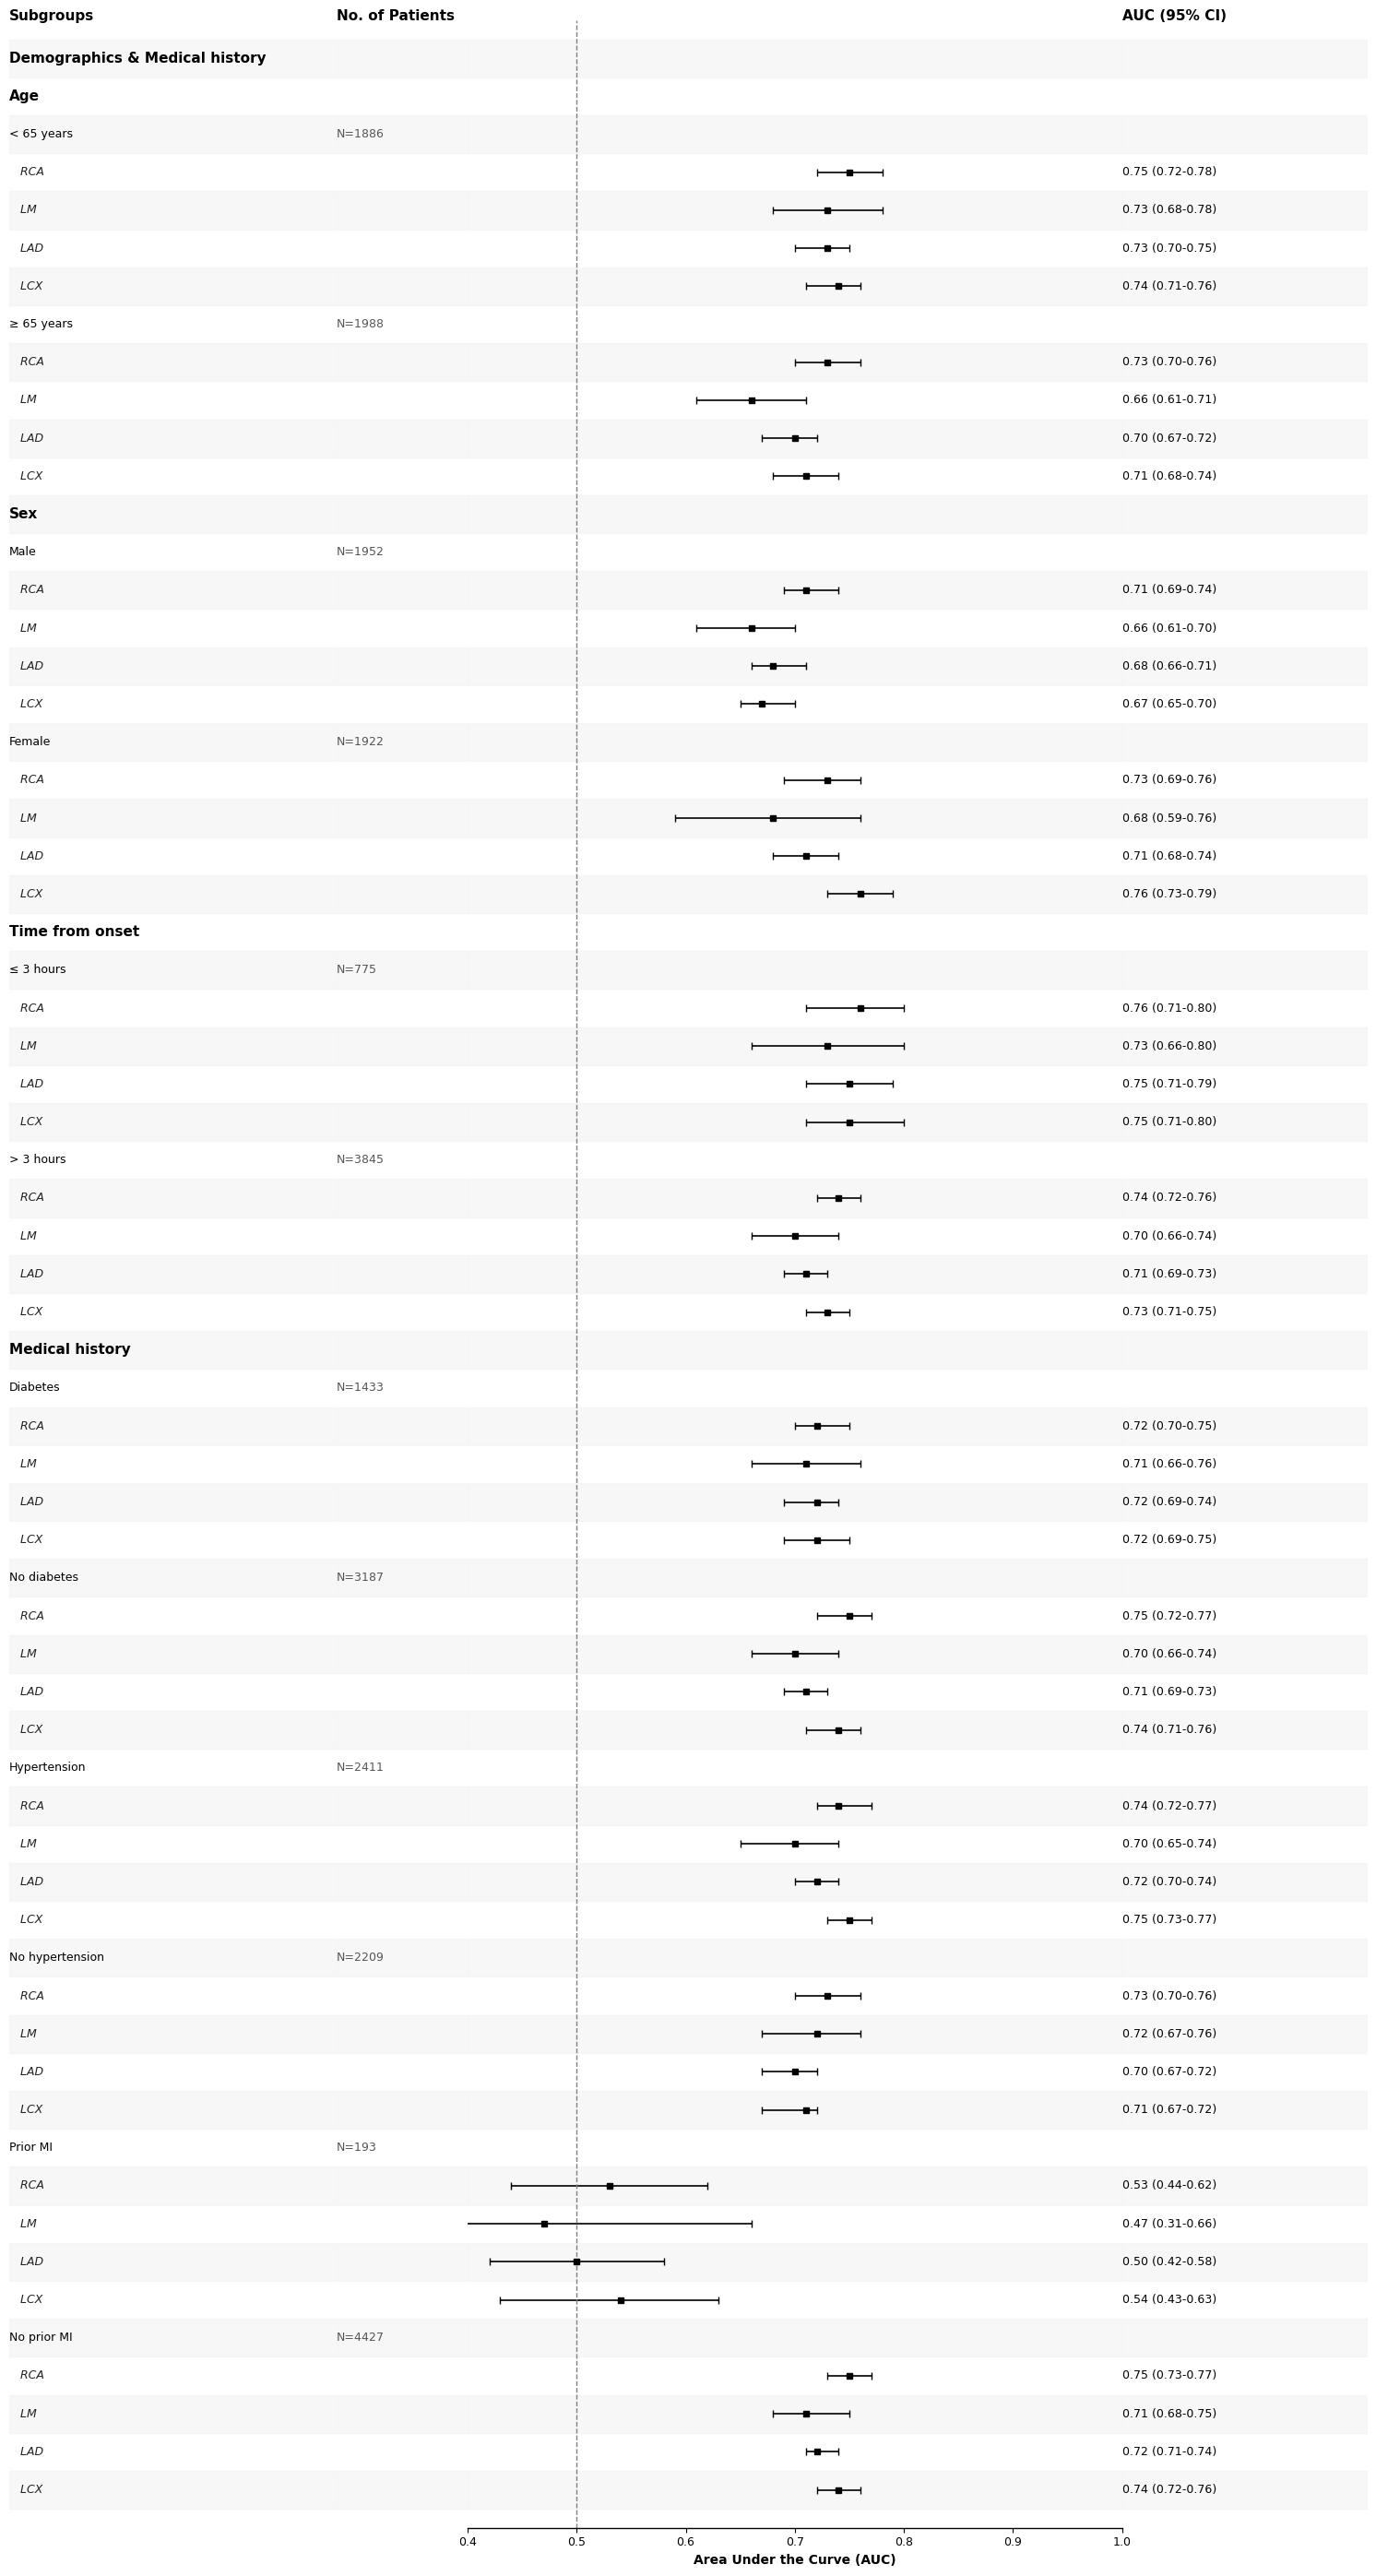

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ================= 1. 准备数据 (与之前保持一致) =================】
data = [
    # 顶部总标题
    ("Demographics & Medical history", "", "", np.nan, np.nan, np.nan, ""),

    # Age
    ("Age", "", "", np.nan, np.nan, np.nan, ""),

    ("", "< 65 years", "N=1886", np.nan, np.nan, np.nan, ""),
    ("", "   RCA", "", 0.75, 0.72, 0.78, "0.75 (0.72-0.78)"),
    ("", "   LM",  "", 0.73, 0.68, 0.78, "0.73 (0.68-0.78)"),
    ("", "   LAD", "", 0.73, 0.70, 0.75, "0.73 (0.70-0.75)"),
    ("", "   LCX", "", 0.74, 0.71, 0.76, "0.74 (0.71-0.76)"),

    ("", "≥ 65 years", "N=1988", np.nan, np.nan, np.nan, ""),
    ("", "   RCA", "", 0.73, 0.70, 0.76, "0.73 (0.70-0.76)"),
    ("", "   LM",  "", 0.66, 0.61, 0.71, "0.66 (0.61-0.71)"),
    ("", "   LAD", "", 0.70, 0.67, 0.72, "0.70 (0.67-0.72)"),
    ("", "   LCX", "", 0.71, 0.68, 0.74, "0.71 (0.68-0.74)"),

    # Sex
    ("Sex", "", "", np.nan, np.nan, np.nan, ""),

    ("", "Male", "N=1952", np.nan, np.nan, np.nan, ""),
    ("", "   RCA", "", 0.71, 0.69, 0.74, "0.71 (0.69-0.74)"),
    ("", "   LM",  "", 0.66, 0.61, 0.70, "0.66 (0.61-0.70)"),
    ("", "   LAD", "", 0.68, 0.66, 0.71, "0.68 (0.66-0.71)"),
    ("", "   LCX", "", 0.67, 0.65, 0.70, "0.67 (0.65-0.70)"),

    ("", "Female", "N=1922", np.nan, np.nan, np.nan, ""),
    ("", "   RCA", "", 0.73, 0.69, 0.76, "0.73 (0.69-0.76)"),
    ("", "   LM",  "", 0.68, 0.59, 0.76, "0.68 (0.59-0.76)"),
    ("", "   LAD", "", 0.71, 0.68, 0.74, "0.71 (0.68-0.74)"),
    ("", "   LCX", "", 0.76, 0.73, 0.79, "0.76 (0.73-0.79)"),

    ("Time from onset", "", "", np.nan, np.nan, np.nan, ""),

    ("", "≤ 3 hours", "N=775", np.nan, np.nan, np.nan, ""),
    ("", "   RCA", "", 0.76, 0.71, 0.80, "0.76 (0.71-0.80)"),
    ("", "   LM",  "", 0.73, 0.66, 0.80, "0.73 (0.66-0.80)"),
    ("", "   LAD", "", 0.75, 0.71, 0.79, "0.75 (0.71-0.79)"),
    ("", "   LCX", "", 0.75, 0.71, 0.80, "0.75 (0.71-0.80)"),

    ("", "> 3 hours", "N=3845", np.nan, np.nan, np.nan, ""),
    ("", "   RCA", "", 0.74, 0.72, 0.76, "0.74 (0.72-0.76)"),
    ("", "   LM",  "", 0.70, 0.66, 0.74, "0.70 (0.66-0.74)"),
    ("", "   LAD", "", 0.71, 0.69, 0.73, "0.71 (0.69-0.73)"),
    ("", "   LCX", "", 0.73, 0.71, 0.75, "0.73 (0.71-0.75)"),

    ("Medical history", "", "", np.nan, np.nan, np.nan, ""),

    ("", "Diabetes", "N=1433", np.nan, np.nan, np.nan, ""),
    ("", "   RCA", "", 0.72, 0.70, 0.75, "0.72 (0.70-0.75)"),
    ("", "   LM",  "", 0.71, 0.66, 0.76, "0.71 (0.66-0.76)"),
    ("", "   LAD", "", 0.72, 0.69, 0.74, "0.72 (0.69-0.74)"),
    ("", "   LCX", "", 0.72, 0.69, 0.75, "0.72 (0.69-0.75)"),

    ("", "No diabetes", "N=3187", np.nan, np.nan, np.nan, ""),
    ("", "   RCA", "", 0.75, 0.72, 0.77, "0.75 (0.72-0.77)"),
    ("", "   LM",  "", 0.70, 0.66, 0.74, "0.70 (0.66-0.74)"),
    ("", "   LAD", "", 0.71, 0.69, 0.73, "0.71 (0.69-0.73)"),
    ("", "   LCX", "", 0.74, 0.71, 0.76, "0.74 (0.71-0.76)"),

    ("", "Hypertension", "N=2411", np.nan, np.nan, np.nan, ""),
    ("", "   RCA", "", 0.74, 0.72, 0.77, "0.74 (0.72-0.77)"),
    ("", "   LM",  "", 0.70, 0.65, 0.74, "0.70 (0.65-0.74)"),
    ("", "   LAD", "", 0.72, 0.70, 0.74, "0.72 (0.70-0.74)"),
    ("", "   LCX", "", 0.75, 0.73, 0.77, "0.75 (0.73-0.77)"),

    ("", "No hypertension", "N=2209", np.nan, np.nan, np.nan, ""),
    ("", "   RCA", "", 0.73, 0.70, 0.76, "0.73 (0.70-0.76)"),
    ("", "   LM",  "", 0.72, 0.67, 0.76, "0.72 (0.67-0.76)"),
    ("", "   LAD", "", 0.70, 0.67, 0.72, "0.70 (0.67-0.72)"),
    ("", "   LCX", "", 0.71, 0.67, 0.72, "0.71 (0.67-0.72)"),

    ("", "Prior MI", "N=193", np.nan, np.nan, np.nan, ""),
    ("", "   RCA", "", 0.53, 0.44, 0.62, "0.53 (0.44-0.62)"),
    ("", "   LM",  "", 0.47, 0.31, 0.66, "0.47 (0.31-0.66)"),
    ("", "   LAD", "", 0.50, 0.42, 0.58, "0.50 (0.42-0.58)"),
    ("", "   LCX", "", 0.54, 0.43, 0.63, "0.54 (0.43-0.63)"),

    ("", "No prior MI", "N=4427", np.nan, np.nan, np.nan, ""),
    ("", "   RCA", "", 0.75, 0.73, 0.77, "0.75 (0.73-0.77)"),
    ("", "   LM",  "", 0.71, 0.68, 0.75, "0.71 (0.68-0.75)"),
    ("", "   LAD", "", 0.72, 0.71, 0.74, "0.72 (0.71-0.74)"),
    ("", "   LCX", "", 0.74, 0.72, 0.76, "0.74 (0.72-0.76)"),
]


df_plot = pd.DataFrame(data, columns=["Group", "Subgroup", "N", "Mean", "Lower", "Upper", "Text"])
# 反转数据，使得绘图时第一行在最上面
df_plot = df_plot.iloc[::-1].reset_index(drop=True)

# ================= 2. 核心绘图逻辑 =================

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['font.size'] = 9

h_per_row = 0.4
fig_height = len(df_plot) * h_per_row + 2 

fig, axes = plt.subplots(1, 4, figsize=(15, fig_height), sharey=True, 
                         gridspec_kw={'width_ratios': [2.0, 0.8, 4.0, 1.5], 'wspace': 0})

ax_text1, ax_text2, ax_plot, ax_text3 = axes

# --- 通用设置 ---
for ax in [ax_text1, ax_text2, ax_text3]:
    ax.axis('off')
    ax.set_ylim(-1, len(df_plot))

# --- 循环绘制每一行 ---
for i in range(len(df_plot)):
    row = df_plot.iloc[i]
    y = i
    
    # === [新增] 添加斑马纹背景 ===
    # 逻辑：如果是偶数行(i%2==0)，就在所有子图上画一个横跨的灰色矩形
    # zorder=0 确保它在文字和数据点的下面
    if i % 2 == 0:
        for ax in axes:
            ax.axhspan(y - 0.5, y + 0.5, color='#F2F2F2', alpha=0.6, zorder=0)

    # 1. 绘制文字
    if row["Group"]:
        ax_text1.text(0, y, row["Group"], weight='bold', ha='left', va='center', size=11, color='black')
        
    if row["Subgroup"]:
        if row["Subgroup"].strip() != row["Subgroup"]: 
            ax_text1.text(0, y, row["Subgroup"], style='italic', ha='left', va='center', color='#222222')
        else:
            ax_text1.text(0, y, row["Subgroup"], ha='left', va='center', color='black')

    if row["N"]:
        ax_text2.text(0, y, row["N"], ha='left', va='center', color='#555555', size=9)

    if row["Text"]:
        ax_text3.text(0, y, row["Text"], ha='left', va='center', color='black')

    # 2. 绘制森林图的点
    if pd.notna(row['Mean']):
        err_low = row['Mean'] - row['Lower']
        err_high = row['Upper'] - row['Mean']
        
        ax_plot.errorbar(row['Mean'], y, xerr=[[err_low], [err_high]], 
                         fmt='s', color='black', ecolor='black', 
                         capsize=3, markersize=4, elinewidth=1.2)

# --- 森林图坐标轴设置 ---
ax_plot.set_ylim(-1, len(df_plot))
ax_plot.set_yticks([])
ax_plot.spines['left'].set_visible(False)
ax_plot.spines['right'].set_visible(False)
ax_plot.spines['top'].set_visible(False)
ax_plot.spines['bottom'].set_linewidth(1.0)
ax_plot.spines['bottom'].set_color('black')
ax_plot.set_xlim(0.4, 1.0)
ax_plot.set_xlabel("Area Under the Curve (AUC)", weight='bold', size=10)
ax_plot.axvline(0.5, color='gray', linestyle='--', linewidth=1.0)

# --- 顶部列标题 ---
top_y = len(df_plot)
ax_text1.text(0, top_y, "Subgroups", weight='bold', size=11)
ax_text2.text(0, top_y, "No. of Patients", weight='bold', size=11, ha='left')
ax_text3.text(0, top_y, "AUC (95% CI)", weight='bold', size=11)
plt.savefig(
    '/data2/2shared/xiaoyujie/冠脉造影/subgroup_forest.svg',
    bbox_inches='tight'
)
plt.tight_layout()
plt.savefig('/data2/2shared/xiaoyujie/冠脉造影/final/subgroup.png',dpi=600)
plt.show()

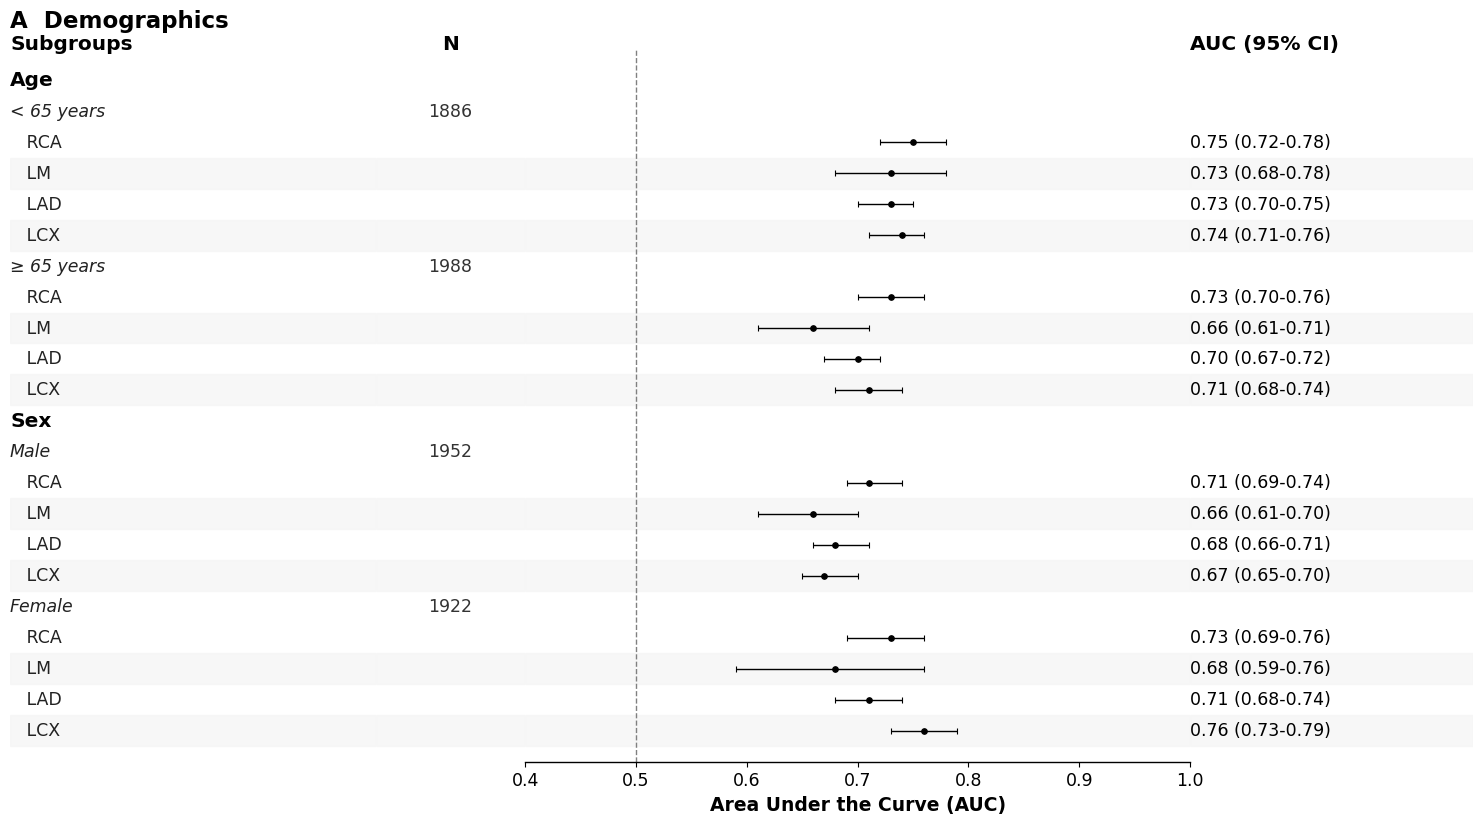

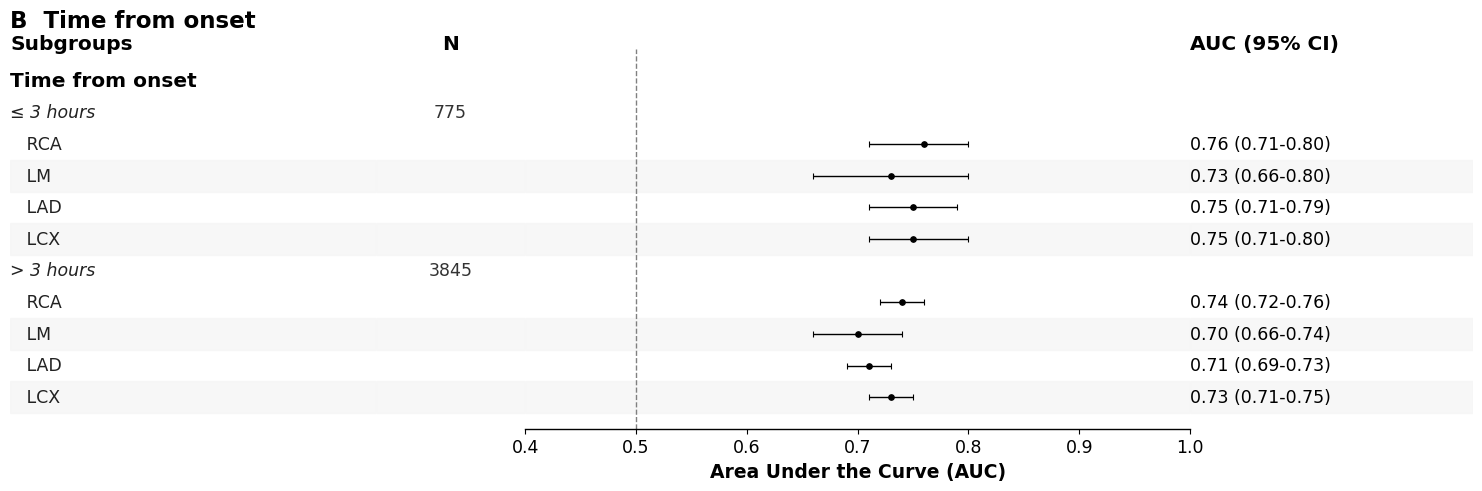

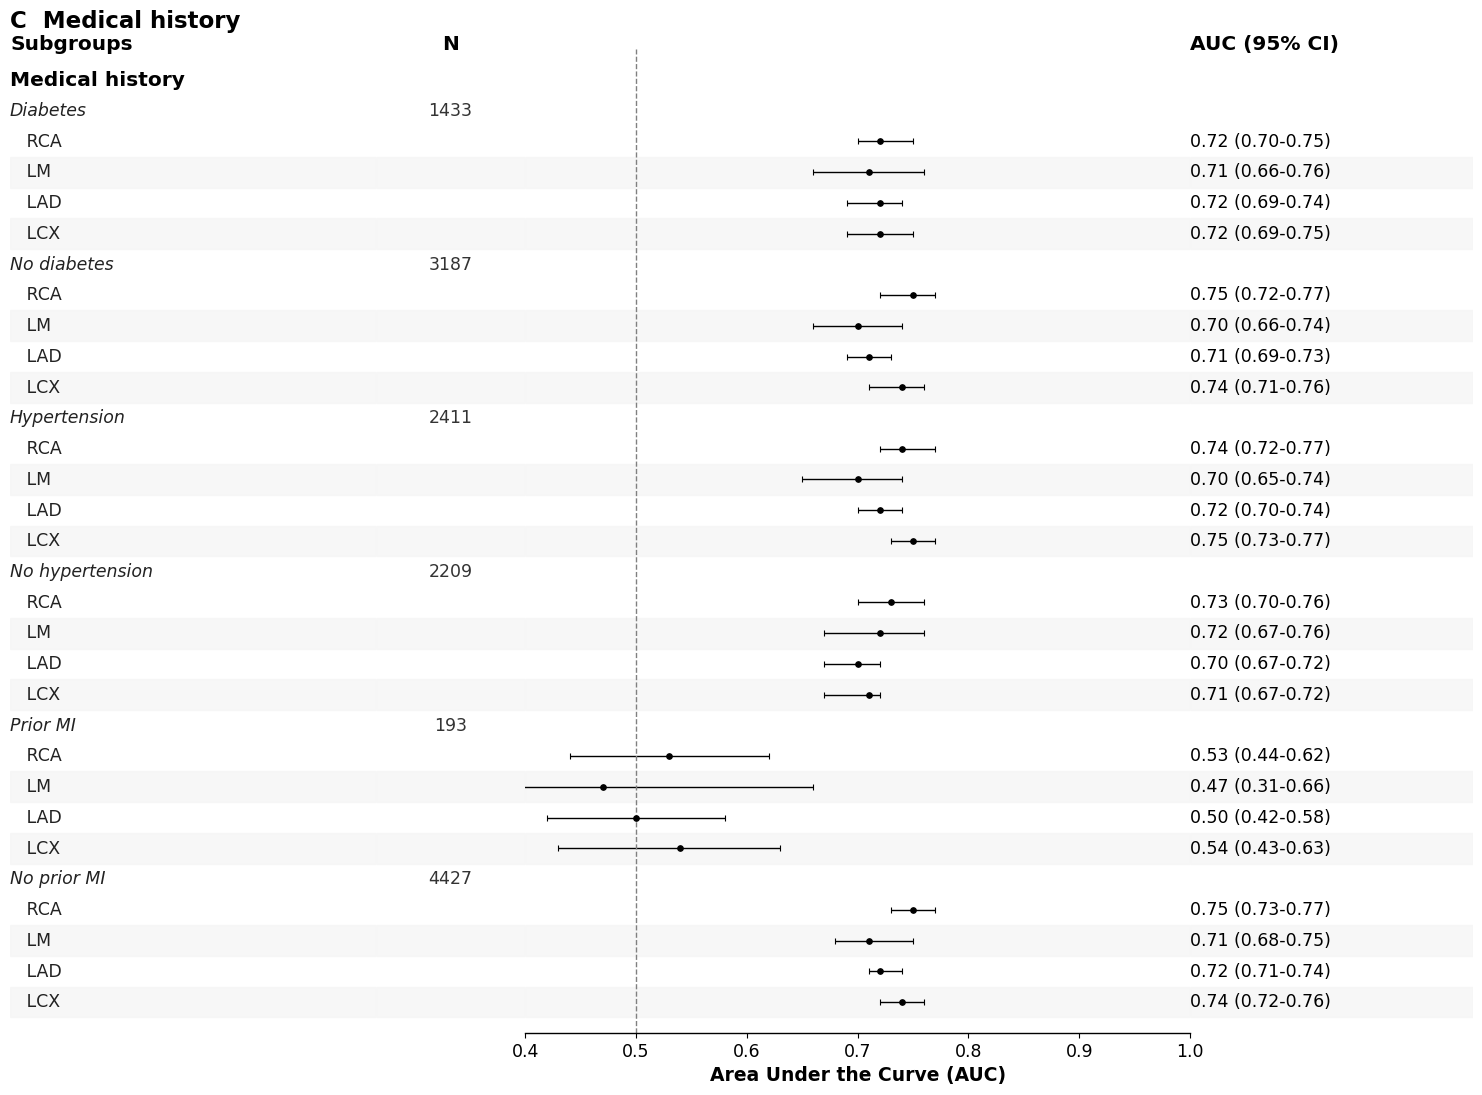

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ============================================================
# 1) 原始数据
# ============================================================
data = [
    ("Demographics & Medical history", "", "", np.nan, np.nan, np.nan, ""),

    ("Age", "", "", np.nan, np.nan, np.nan, ""),

    ("", "< 65 years", "N=1886", np.nan, np.nan, np.nan, ""),
    ("", "   RCA", "", 0.75, 0.72, 0.78, "0.75 (0.72-0.78)"),
    ("", "   LM",  "", 0.73, 0.68, 0.78, "0.73 (0.68-0.78)"),
    ("", "   LAD", "", 0.73, 0.70, 0.75, "0.73 (0.70-0.75)"),
    ("", "   LCX", "", 0.74, 0.71, 0.76, "0.74 (0.71-0.76)"),

    ("", "≥ 65 years", "N=1988", np.nan, np.nan, np.nan, ""),
    ("", "   RCA", "", 0.73, 0.70, 0.76, "0.73 (0.70-0.76)"),
    ("", "   LM",  "", 0.66, 0.61, 0.71, "0.66 (0.61-0.71)"),
    ("", "   LAD", "", 0.70, 0.67, 0.72, "0.70 (0.67-0.72)"),
    ("", "   LCX", "", 0.71, 0.68, 0.74, "0.71 (0.68-0.74)"),

    ("Sex", "", "", np.nan, np.nan, np.nan, ""),

    ("", "Male", "N=1952", np.nan, np.nan, np.nan, ""),
    ("", "   RCA", "", 0.71, 0.69, 0.74, "0.71 (0.69-0.74)"),
    ("", "   LM",  "", 0.66, 0.61, 0.70, "0.66 (0.61-0.70)"),
    ("", "   LAD", "", 0.68, 0.66, 0.71, "0.68 (0.66-0.71)"),
    ("", "   LCX", "", 0.67, 0.65, 0.70, "0.67 (0.65-0.70)"),

    ("", "Female", "N=1922", np.nan, np.nan, np.nan, ""),
    ("", "   RCA", "", 0.73, 0.69, 0.76, "0.73 (0.69-0.76)"),
    ("", "   LM",  "", 0.68, 0.59, 0.76, "0.68 (0.59-0.76)"),
    ("", "   LAD", "", 0.71, 0.68, 0.74, "0.71 (0.68-0.74)"),
    ("", "   LCX", "", 0.76, 0.73, 0.79, "0.76 (0.73-0.79)"),

    ("Time from onset", "", "", np.nan, np.nan, np.nan, ""),

    ("", "≤ 3 hours", "N=775", np.nan, np.nan, np.nan, ""),
    ("", "   RCA", "", 0.76, 0.71, 0.80, "0.76 (0.71-0.80)"),
    ("", "   LM",  "", 0.73, 0.66, 0.80, "0.73 (0.66-0.80)"),
    ("", "   LAD", "", 0.75, 0.71, 0.79, "0.75 (0.71-0.79)"),
    ("", "   LCX", "", 0.75, 0.71, 0.80, "0.75 (0.71-0.80)"),

    ("", "> 3 hours", "N=3845", np.nan, np.nan, np.nan, ""),
    ("", "   RCA", "", 0.74, 0.72, 0.76, "0.74 (0.72-0.76)"),
    ("", "   LM",  "", 0.70, 0.66, 0.74, "0.70 (0.66-0.74)"),
    ("", "   LAD", "", 0.71, 0.69, 0.73, "0.71 (0.69-0.73)"),
    ("", "   LCX", "", 0.73, 0.71, 0.75, "0.73 (0.71-0.75)"),

    ("Medical history", "", "", np.nan, np.nan, np.nan, ""),

    ("", "Diabetes", "N=1433", np.nan, np.nan, np.nan, ""),
    ("", "   RCA", "", 0.72, 0.70, 0.75, "0.72 (0.70-0.75)"),
    ("", "   LM",  "", 0.71, 0.66, 0.76, "0.71 (0.66-0.76)"),
    ("", "   LAD", "", 0.72, 0.69, 0.74, "0.72 (0.69-0.74)"),
    ("", "   LCX", "", 0.72, 0.69, 0.75, "0.72 (0.69-0.75)"),

    ("", "No diabetes", "N=3187", np.nan, np.nan, np.nan, ""),
    ("", "   RCA", "", 0.75, 0.72, 0.77, "0.75 (0.72-0.77)"),
    ("", "   LM",  "", 0.70, 0.66, 0.74, "0.70 (0.66-0.74)"),
    ("", "   LAD", "", 0.71, 0.69, 0.73, "0.71 (0.69-0.73)"),
    ("", "   LCX", "", 0.74, 0.71, 0.76, "0.74 (0.71-0.76)"),

    ("", "Hypertension", "N=2411", np.nan, np.nan, np.nan, ""),
    ("", "   RCA", "", 0.74, 0.72, 0.77, "0.74 (0.72-0.77)"),
    ("", "   LM",  "", 0.70, 0.65, 0.74, "0.70 (0.65-0.74)"),
    ("", "   LAD", "", 0.72, 0.70, 0.74, "0.72 (0.70-0.74)"),
    ("", "   LCX", "", 0.75, 0.73, 0.77, "0.75 (0.73-0.77)"),

    ("", "No hypertension", "N=2209", np.nan, np.nan, np.nan, ""),
    ("", "   RCA", "", 0.73, 0.70, 0.76, "0.73 (0.70-0.76)"),
    ("", "   LM",  "", 0.72, 0.67, 0.76, "0.72 (0.67-0.76)"),
    ("", "   LAD", "", 0.70, 0.67, 0.72, "0.70 (0.67-0.72)"),
    ("", "   LCX", "", 0.71, 0.67, 0.72, "0.71 (0.67-0.72)"),

    ("", "Prior MI", "N=193", np.nan, np.nan, np.nan, ""),
    ("", "   RCA", "", 0.53, 0.44, 0.62, "0.53 (0.44-0.62)"),
    ("", "   LM",  "", 0.47, 0.31, 0.66, "0.47 (0.31-0.66)"),
    ("", "   LAD", "", 0.50, 0.42, 0.58, "0.50 (0.42-0.58)"),
    ("", "   LCX", "", 0.54, 0.43, 0.63, "0.54 (0.43-0.63)"),

    ("", "No prior MI", "N=4427", np.nan, np.nan, np.nan, ""),
    ("", "   RCA", "", 0.75, 0.73, 0.77, "0.75 (0.73-0.77)"),
    ("", "   LM",  "", 0.71, 0.68, 0.75, "0.71 (0.68-0.75)"),
    ("", "   LAD", "", 0.72, 0.71, 0.74, "0.72 (0.71-0.74)"),
    ("", "   LCX", "", 0.74, 0.72, 0.76, "0.74 (0.72-0.76)"),
]

df_all = pd.DataFrame(data, columns=["Group", "Subgroup", "N", "Mean", "Lower", "Upper", "Text"])

# ============================================================
# 2) 按 Panel 拆分
# ============================================================
def make_panel_df(df: pd.DataFrame, panel_key: str) -> pd.DataFrame:
    df = df.copy()
    if panel_key == "demographics":
        keep_groups = {"Age", "Sex"}
    elif panel_key == "time":
        keep_groups = {"Time from onset"}
    elif panel_key == "history":
        keep_groups = {"Medical history"}
    else:
        raise ValueError("panel_key error")

    rows = []
    active = False
    for _, r in df.iterrows():
        g = (r["Group"] or "").strip()
        if g != "":
            active = (g in keep_groups)
            if active:
                rows.append(r)
        else:
            if active:
                rows.append(r)

    panel_df = pd.DataFrame(rows).reset_index(drop=True)
    panel_df = panel_df.iloc[::-1].reset_index(drop=True)
    return panel_df

# ============================================================
# 3) 绘图函数：N 单独一列
# ============================================================
def plot_forest_panel(
    df_plot: pd.DataFrame,
    panel_title: str,
    out_png: str,
    out_svg: str,
    xlim=(0.4, 1.0),
    base_fontsize=12.5,
    h_per_row=0.30,
    marker_size=4,
    elinewidth=1.0,
    capsize=2
):
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
    plt.rcParams['font.size'] = base_fontsize

    fig_height = len(df_plot) * h_per_row + 1.8

    # 4 列布局：Subgroups (2.2) | N (0.9) | Forest (4.0) | AUC text (1.7)
    # N 列稍微宽一点点以确保对齐
    fig, axes = plt.subplots(
        1, 4, figsize=(15, fig_height), sharey=True,
        gridspec_kw={'width_ratios': [2.2, 0.9, 4.0, 1.7], 'wspace': 0}
    )
    ax_text1, ax_text2, ax_plot, ax_text3 = axes

    for ax in [ax_text1, ax_text2, ax_text3]:
        ax.axis('off')
        ax.set_ylim(-1, len(df_plot))

    data_row_counter = -1

    for i in range(len(df_plot)):
        row = df_plot.iloc[i]
        y = i
        is_data = pd.notna(row["Mean"])

        # 斑马纹
        if is_data:
            data_row_counter += 1
            if data_row_counter % 2 == 0:
                for ax in axes:
                    ax.axhspan(y - 0.5, y + 0.5, color='#F2F2F2', alpha=0.55, zorder=0)

        # -------------------------------------------------------
        # 第一列：Group 和 Subgroup
        # -------------------------------------------------------
        if row["Group"]:
            # 大标题 (e.g. "Age")
            ax_text1.text(
                0, y, row["Group"], weight='bold', ha='left', va='center',
                size=base_fontsize + 2, color='black'
            )

        if row["Subgroup"]:
            subgroup = row["Subgroup"]
            # 判断是否为 "小标题行" (有 Subgroup 文字，但没有 AUC 数据)
            is_subgroup_header = (pd.isna(row["Mean"]) and str(subgroup).strip() != "")
            
            # 【修改点】 不再把 N 合并在 Subgroup 里，直接写 Subgroup
            if is_subgroup_header:
                ax_text1.text(
                    0, y, subgroup,
                    style='italic', ha='left', va='center',
                    color='#222222'
                )
            else:
                if subgroup.strip() != subgroup: # 缩进的叶子节点
                    ax_text1.text(0, y, subgroup, ha='left', va='center', color='#222222')
                else:
                    ax_text1.text(0, y, subgroup, ha='left', va='center', color='black')

        # -------------------------------------------------------
        # 第二列：N 数量 (单独列)
        # -------------------------------------------------------
        if row["N"]:
            # 数据里的 "N=1886" 去掉 "N="，只留 "1886"
            n_val = str(row["N"]).replace("N=", "").strip()
            
            # 居中显示
            ax_text2.text(
                0.5, y, n_val, 
                ha='center', va='center', 
                color='#333333', size=base_fontsize
            )

        # -------------------------------------------------------
        # 第四列：AUC 文本
        # -------------------------------------------------------
        if row["Text"]:
            ax_text3.text(0, y, row["Text"], ha='left', va='center', color='black')

        # -------------------------------------------------------
        # 第三列：森林图
        # -------------------------------------------------------
        if is_data:
            err_low = float(row['Mean'] - row['Lower'])
            err_high = float(row['Upper'] - row['Mean'])
            ax_plot.errorbar(
                float(row['Mean']), y,
                xerr=[[err_low], [err_high]],
                fmt='o', color='black', ecolor='black',
                capsize=capsize, markersize=marker_size,
                elinewidth=elinewidth, markeredgewidth=0.8
            )

    # 轴设置
    ax_plot.set_ylim(-1, len(df_plot))
    ax_plot.set_yticks([])
    ax_plot.spines['left'].set_visible(False)
    ax_plot.spines['right'].set_visible(False)
    ax_plot.spines['top'].set_visible(False)
    ax_plot.spines['bottom'].set_linewidth(1.0)
    ax_plot.spines['bottom'].set_color('black')
    ax_plot.set_xlim(*xlim)
    ax_plot.set_xlabel("Area Under the Curve (AUC)", weight='bold', size=base_fontsize + 1)
    ax_plot.axvline(0.5, color='gray', linestyle='--', linewidth=1.0)

    # 表头标题
    top_y = len(df_plot)
    ax_text1.text(0, top_y + 0.7, panel_title, weight='bold', size=base_fontsize + 4)
    ax_text1.text(0, top_y, "Subgroups", weight='bold', size=base_fontsize + 2)
    
    # 【修改点】 N 的表头，居中对齐
    ax_text2.text(0.5, top_y, "N", weight='bold', size=base_fontsize + 2, ha='center')
    
    ax_text3.text(0, top_y, "AUC (95% CI)", weight='bold', size=base_fontsize + 2)

    plt.tight_layout()
    plt.savefig(out_svg, bbox_inches='tight')
    plt.savefig(out_png, dpi=600, bbox_inches='tight')
    plt.show()

# ============================================================
# 4) 执行生成
# ============================================================
df_demo = make_panel_df(df_all, "demographics")
df_time = make_panel_df(df_all, "time")
df_hist = make_panel_df(df_all, "history")

OUT_DIR = "/data2/2shared/xiaoyujie/冠脉造影/final"

plot_forest_panel(
    df_demo, "A  Demographics", 
    f"{OUT_DIR}/subgroup_forest_A_demographics.png",
    f"{OUT_DIR}/subgroup_forest_A_demographics.svg"
)
plot_forest_panel(
    df_time, "B  Time from onset", 
    f"{OUT_DIR}/subgroup_forest_B_time.png",
    f"{OUT_DIR}/subgroup_forest_B_time.svg"
)
plot_forest_panel(
    df_hist, "C  Medical history", 
    f"{OUT_DIR}/subgroup_forest_C_history.png",
    f"{OUT_DIR}/subgroup_forest_C_history.svg"
)

In [10]:
import pandas as pd
import numpy as np

# =========================
# 0. 基本信息
# =========================
input_file = '/data2/2shared/xiaoyujie/冠脉造影/final/人民结果_with病史_性别年龄.csv'
df = pd.read_csv(input_file)

N_total = len(df)

def fmt(n, denom=N_total):
    """格式化为 n (xx.x%)"""
    if denom == 0:
        return f"{n} (0.0%)"
    return f"{n} ({n/denom*100:.1f}%)"

rows = []

# =========================
# 1. Sex
# =========================
rows.append(("Sex", "", ""))

n_male = (df['性别_labeled'] == 1).sum()
n_female = (df['性别_labeled'] == 0).sum()
n_sex_missing = df['性别_labeled'].isna().sum()

rows.append(("  Male", fmt(n_male), ""))
rows.append(("  Female", fmt(n_female), ""))
rows.append(("  Missing", fmt(n_sex_missing), ""))

# =========================
# 2. Age
# =========================
rows.append(("Age", "", ""))

n_age_valid = df['age'].notna().sum()
n_age_missing = df['age'].isna().sum()

# 连续型（可选）
age_mean = df['age'].mean()
age_std = df['age'].std()
rows.append(("  Age, mean ± SD", f"{age_mean:.1f} ± {age_std:.1f}", ""))

# 分组
rows.append(("  < 65 years", fmt((df['age'] < 65).sum()), ""))
rows.append(("  ≥ 65 years", fmt((df['age'] >= 65).sum()), ""))
rows.append(("  Missing", fmt(n_age_missing), ""))

# =========================
# 3. Comorbidities
# =========================
rows.append(("Comorbidities", "", ""))

hx_map = {
    "Diabetes": "既往_糖尿病",
    "Hypertension": "既往_高血压",
    "Prior myocardial infarction": "既往_心肌梗死",
}

for name, col in hx_map.items():
    n_yes = (df[col] == "是").sum()
    n_no = (df[col] == "否").sum()
    n_missing = df[col].isna().sum()

    rows.append((f"  {name}", fmt(n_yes), ""))
    rows.append((f"    No", fmt(n_no), ""))
    rows.append((f"    Missing", fmt(n_missing), ""))

# =========================
# 4. Coronary stenosis (label)
# =========================
rows.append(("Coronary artery stenosis", "", ""))

artery_map = {
    '右冠状动脉主干': 'RCA',
    '左冠状动脉主干': 'LM',
    '左前降支': 'LAD',
    '左回旋支': 'LCX'
}

for cn_name, en_name in artery_map.items():
    col = f"{cn_name}_label"
    n_severe = (df[col] == 1).sum()
    n_non_severe = (df[col] == 0).sum()
    n_missing = df[col].isna().sum()

    rows.append((f"  {en_name}", "", ""))
    rows.append((f"    Severe stenosis / occlusion", fmt(n_severe), ""))
    rows.append((f"    Non-severe or normal", fmt(n_non_severe), ""))
    rows.append((f"    Missing", fmt(n_missing), ""))

# =========================
# 5. 生成表格
# =========================
table1 = pd.DataFrame(
    rows,
    columns=["Characteristic", "Value (n, %)", "Notes"]
)

# =========================
# 6. 保存
# =========================
table1.to_csv("Table1_baseline_characteristics.csv", index=False)
table1.to_excel("Table1_baseline_characteristics.xlsx", index=False)

print("✅ 已生成 Table 1：")
print(" - Table1_baseline_characteristics.csv")
print(" - Table1_baseline_characteristics.xlsx")


✅ 已生成 Table 1：
 - Table1_baseline_characteristics.csv
 - Table1_baseline_characteristics.xlsx


In [5]:
import pandas as pd

csv_path = "/data2/2shared/xiaoyujie/冠脉造影/final/随访_pred.csv"  
age_col = "病人年龄"

df = pd.read_csv(csv_path)
print(len(df))
df[age_col] = (
    df[age_col]
    .astype(str)
    .str.replace("岁", "", regex=False)
)

df[age_col] = pd.to_numeric(df[age_col], errors="coerce")

df = df.dropna(subset=[age_col])

mean_age = df[age_col].mean()
std_age  = df[age_col].std()

n_total = len(df)

n_ge_65 = (df[age_col] >= 65).sum()
n_lt_65 = (df[age_col] < 65).sum()

p_ge_65 = n_ge_65 / n_total * 100
p_lt_65 = n_lt_65 / n_total * 100


print(f"样本总数: {n_total}")
print(f"平均年龄: {mean_age:.2f}")
print(f"年龄SD: {std_age:.2f}")
print(f">=65岁: {n_ge_65} 人 ({p_ge_65:.2f}%)")
print(f"<65岁: {n_lt_65} 人 ({p_lt_65:.2f}%)")


400
样本总数: 400
平均年龄: 63.14
年龄SD: 10.43
>=65岁: 201 人 (50.25%)
<65岁: 199 人 (49.75%)


In [6]:
csv_path = "/data2/2shared/xiaoyujie/冠脉造影/final/随访_pred.csv"  
age_col = "病人年龄"

df = pd.read_csv(csv_path)

In [7]:
print(df['右冠状动脉_检查结果'].value_counts())
print(df['左冠状动脉主干_检查结果'].value_counts())
print(df['左前降支_检查结果'].value_counts())
print(df['左回旋支_检查结果'].value_counts())


右冠状动脉_检查结果
未见明显狭窄    247
重度狭窄       53
中度狭窄       53
轻度狭窄       36
完全堵塞       11
Name: count, dtype: int64
左冠状动脉主干_检查结果
未见明显狭窄    394
重度狭窄        4
中度狭窄        2
Name: count, dtype: int64
左前降支_检查结果
未见明显狭窄    215
重度狭窄       68
中度狭窄       65
轻度狭窄       37
完全堵塞       15
Name: count, dtype: int64
左回旋支_检查结果
未见明显狭窄    305
重度狭窄       44
中度狭窄       23
轻度狭窄       17
完全堵塞       11
Name: count, dtype: int64


箱线图

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import numpy as np

# ==================== 1. 绘图风格设置 ====================
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 11

# ==================== 2. 数据配置 ====================
CSV_PATH = "/data2/2shared/xiaoyujie/冠脉造影/人民5折交叉验证/checkpoint_5fold_轻中度正常/oof_predictions_all_folds.csv"

LABELS = [
    '右冠状动脉主干_诊断结果',
    '左冠状动脉主干_诊断结果',
    '左前降支_诊断结果',
    '左回旋支_诊断结果'
]

PROBS = [
    '右冠状动脉主干_prob',
    '左冠状动脉主干_prob',
    '左前降支_prob',
    '左回旋支_prob'
]

VESSELS = ['RCA', 'LM', 'LAD', 'LCx']

# 定义狭窄等级映射
GRADE_MAP = {
    "未见明显狭窄": ("Normal", 0),
    "轻度狭窄": ("Mild", 1),
    "中度狭窄": ("Moderate", 2),
    "重度狭窄": ("Severe", 3),
    "完全堵塞": ("Severe", 3)
}

# ✅ 修正：手动定义唯一的绘图顺序，避免出现两个 "Severe"
ORDER_EN = ["Normal", "Mild", "Moderate", "Severe"]

# 读取数据
df = pd.read_csv(CSV_PATH)

# ==================== 3. 开始绘图 ====================
fig, axes = plt.subplots(2, 2, figsize=(16, 11))
axes = axes.flatten()

print("\n===== Spearman Trend Test =====\n")

for i in range(4):
    # 1. 基础提取与去空值 (NaN)
    temp = df[[LABELS[i], PROBS[i]]].dropna().copy()
    
    # 🔥🔥 修改点：过滤掉不在字典里的“脏数据”或“空文本” 🔥🔥
    # 只有当标签在 GRADE_MAP 的 key 里时才保留
    # 这样就能自动删掉 " " (空字符串)、"无法判断" 等脏数据
    temp = temp[temp[LABELS[i]].isin(GRADE_MAP.keys())]
    
    # 如果过滤后没数据了，跳过防止报错
    if temp.empty:
        print(f"Skipping {VESSELS[i]} - No valid labels found.")
        continue

    # 2. 映射等级
    temp["Grade_EN"] = temp[LABELS[i]].map(lambda x: GRADE_MAP[x][0])
    temp["Grade_Level"] = temp[LABELS[i]].map(lambda x: GRADE_MAP[x][1])

    ax = axes[i]

    # 3. 绘制 Boxplot
    sns.boxplot(
        x="Grade_EN",
        y=PROBS[i],
        data=temp,
        order=ORDER_EN,  # 使用去重后的顺序
        ax=ax,
        width=0.5,
        linewidth=1.5,
        fliersize=3,
        palette="Blues"
    )

    # 坐标轴与标题
    ax.set_title(VESSELS[i], fontsize=15, fontweight='bold')
    ax.set_xlabel("Stenosis Grade")
    ax.set_ylabel("Predicted Probability")
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # 自适应 Y 轴逻辑
    if not temp.empty:
        data_min = temp[PROBS[i]].min()
        data_max = temp[PROBS[i]].max()
        padding = (data_max - data_min) * 0.1
        if pd.notna(data_min) and pd.notna(data_max):
            ax.set_ylim(data_min - padding, data_max + padding)

    # ---------- Spearman 趋势检验 ----------
    # 确保有足够的数据点计算相关性
    if len(temp) > 2:
        rho, p_value = spearmanr(temp["Grade_Level"], temp[PROBS[i]])
        
        p_text = "< 0.001" if p_value < 0.001 else f"{p_value:.3f}"
        trend_text = f"Spearman trend: ρ = {rho:.3f}, p {p_text if '<' in p_text else '= ' + p_text}"
        
        print(f"{VESSELS[i]} -> {trend_text}")

        ax.text(
            0.5, -0.20,
            trend_text,
            transform=ax.transAxes,
            ha='center',
            va='top',
            fontsize=11,
            fontweight='medium',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='lightgray', boxstyle='round,pad=0.3')
        )
    else:
        print(f"{VESSELS[i]} -> Not enough data for Spearman test")

# ==================== 4. 布局调整 ====================
plt.subplots_adjust(
    left=0.08,
    right=0.96,
    top=0.94,
    bottom=0.15,
    hspace=0.4,
    wspace=0.25
)

plt.show()

校准曲线

========= Calibration Plot Generation =========
Label rule: Severe stenosis / occlusion = 1; (Normal/Mild/Moderate) = 0
------------------------------------------------
[RCA] Threshold: 15.0% | N=4620, Positive=795 (17.21%), Negative=3825 (82.79%)
[LM] Threshold: 1.0% | N=4620, Positive=235 (5.09%), Negative=4385 (94.91%)
[LAD] Threshold: 15.0% | N=4620, Positive=1373 (29.72%), Negative=3247 (70.28%)
[LCX] Threshold: 15.0% | N=4620, Positive=795 (17.21%), Negative=3825 (82.79%)
------------------------------------------------
===== Summary Table (copy-ready) =====
Vessel    N  Positive_n  Positive_rate  Negative_n  Negative_rate  Threshold    Brier
   RCA 4620         795       0.172078        3825       0.827922       0.15 0.129732
    LM 4620         235       0.050866        4385       0.949134       0.01 0.046865
   LAD 4620        1373       0.297186        3247       0.702814       0.15 0.189568
   LCX 4620         795       0.172078        3825       0.827922       0.15 0.130909

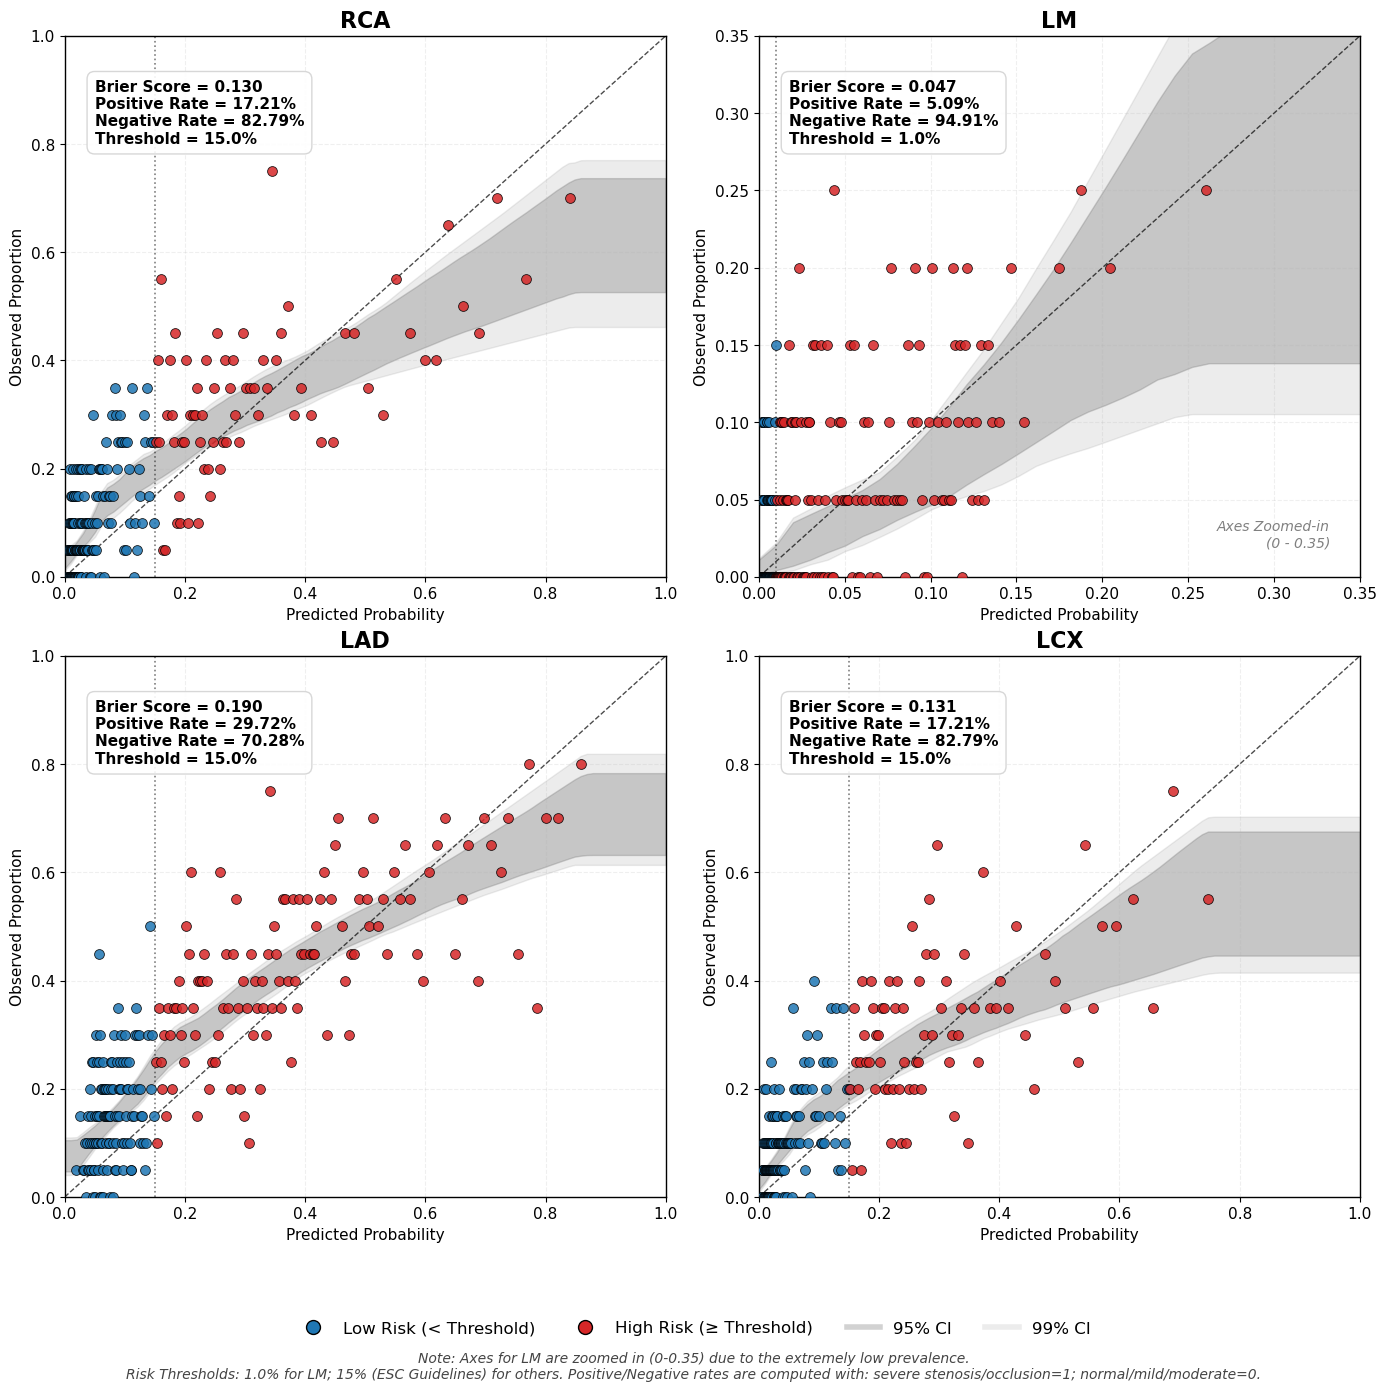

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss
from statsmodels.nonparametric.smoothers_lowess import lowess
from matplotlib.lines import Line2D

# ==================== 1. 配置参数 ====================
CSV_PATH = "/data2/2shared/xiaoyujie/冠脉造影/人民5折交叉验证/checkpoint_5fold_轻中度正常/oof_predictions_all_folds.csv"

LABEL_COLUMN_NAMES = [
    '右冠状动脉主干_诊断结果',
    '左冠状动脉主干_诊断结果',
    '左前降支_诊断结果',
    '左回旋支_诊断结果'
]

PROB_COLUMN_NAMES = [
    '右冠状动脉主干_prob',
    '左冠状动脉主干_prob',
    '左前降支_prob',
    '左回旋支_prob'
]

VESSEL_NAMES = ['RCA', 'LM', 'LAD', 'LCX']

# 定义负样本标签（正常、轻度、中度均为0，只有重度为1）
NON_EVENT_LABELS = ["未见明显狭窄", "轻度狭窄", "中度狭窄"]

GROUP_SIZE = 20
BOOTSTRAP = 500

RISK_COLORS = {
    "Low": "#1f77b4",   # 蓝色
    "High": "#d62728"   # 红色
}

# ✅ 混合策略阈值 (Hybrid Thresholds)
VESSEL_THRESHOLDS = {
    "RCA": 0.15,  # 15% (ESC 指南)
    "LM":  0.01,  # 1.0% (相对风险策略, 10倍基线)
    "LAD": 0.15,  # 15% (ESC 指南)
    "LCX": 0.15   # 15% (ESC 指南)
}

# ==================== 2. 辅助函数 ====================

def grouped_calibration(y, p, group_size):
    """计算分组校准点"""
    df_gp = pd.DataFrame({"y": y, "p": p}).sort_values("p")
    grouped = []
    for i in range(0, len(df_gp), group_size):
        chunk = df_gp.iloc[i:i+group_size]
        if len(chunk) > 0:
            grouped.append({
                "mean_p": chunk["p"].mean(),
                "obs": chunk["y"].mean(),
                "n": len(chunk)
            })
    return pd.DataFrame(grouped)

def bootstrap_ci_levels(y, p, x_grid, group_size=20, n_boot=500, ci=0.95, seed=42):
    """计算校准曲线的置信区间带（LOWESS + bootstrap）"""
    preds = []
    rng = np.random.RandomState(seed)

    y = np.asarray(y)
    p = np.asarray(p)

    for _ in range(n_boot):
        idx = rng.choice(len(y), len(y), replace=True)
        df_group = grouped_calibration(y[idx], p[idx], group_size)
        if len(df_group) < 3:
            continue
        try:
            smoothed = lowess(df_group["obs"], df_group["mean_p"], frac=0.6, return_sorted=True)
            preds.append(np.interp(x_grid, smoothed[:, 0], smoothed[:, 1]))
        except Exception:
            continue

    if len(preds) == 0:
        return np.zeros_like(x_grid), np.zeros_like(x_grid)

    preds = np.array(preds)
    lower = np.percentile(preds, (1-ci)/2*100, axis=0)
    upper = np.percentile(preds, (1+ci)/2*100, axis=0)
    return lower, upper

# ==================== 3. 主绘图逻辑 + 阳性/阴性率统计 ====================

plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['font.size'] = 11
plt.rcParams['axes.linewidth'] = 1.0

df = pd.read_csv(CSV_PATH)

fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()

print("========= Calibration Plot Generation =========")
print("Label rule: Severe stenosis / occlusion = 1; (Normal/Mild/Moderate) = 0")
print("------------------------------------------------")

# （可选）汇总表，便于你复制进论文/补充材料
summary_rows = []

for i, (label_col, prob_col, vessel) in enumerate(zip(
    LABEL_COLUMN_NAMES, PROB_COLUMN_NAMES, VESSEL_NAMES)):

    # 1) 准备数据：重度狭窄=1, 其他=0
    y_true = df[label_col].apply(lambda x: 0 if x in NON_EVENT_LABELS else 1).astype(int).values
    y_prob = df[prob_col].astype(float).values

    # ===== 阳性率 / 阴性率 =====
    n_total = len(y_true)
    n_pos = int(y_true.sum())
    n_neg = int(n_total - n_pos)
    pos_rate = n_pos / n_total if n_total > 0 else np.nan
    neg_rate = n_neg / n_total if n_total > 0 else np.nan

    # 2) 计算校准点
    calib_df = grouped_calibration(y_true, y_prob, GROUP_SIZE)

    # 3) 确定风险分组
    cutoff = VESSEL_THRESHOLDS[vessel]
    calib_df["risk"] = calib_df["mean_p"].apply(lambda pp: "High" if pp >= cutoff else "Low")

    # 4) 计算置信区间带
    x_grid_full = np.linspace(0, 1, 100)
    ci95_low, ci95_high = bootstrap_ci_levels(
        y_true, y_prob, x_grid_full, group_size=GROUP_SIZE, n_boot=BOOTSTRAP, ci=0.95, seed=42
    )
    ci99_low, ci99_high = bootstrap_ci_levels(
        y_true, y_prob, x_grid_full, group_size=GROUP_SIZE, n_boot=BOOTSTRAP, ci=0.99, seed=42
    )

    brier = brier_score_loss(y_true, y_prob)
    ax = axes[i]

    # 打印统计信息
    print(f"[{vessel}] Threshold: {cutoff:.1%} | N={n_total}, Positive={n_pos} ({pos_rate:.2%}), Negative={n_neg} ({neg_rate:.2%})")

    # 汇总表（可选）
    summary_rows.append({
        "Vessel": vessel,
        "N": n_total,
        "Positive_n": n_pos,
        "Positive_rate": pos_rate,
        "Negative_n": n_neg,
        "Negative_rate": neg_rate,
        "Threshold": cutoff,
        "Brier": brier
    })

    # ==========================================
    # LM 单独调整坐标轴范围
    # ==========================================
    if vessel == 'LM':
        display_limit = 0.35
        ax.set_xlim(0, display_limit)
        ax.set_ylim(0, display_limit)

        # 对角线（只画显示区域）
        ax.plot([0, display_limit], [0, display_limit],
                linestyle='--', color='black', linewidth=1, alpha=0.7)

        ax.text(0.95, 0.05, "Axes Zoomed-in\n(0 - 0.35)", transform=ax.transAxes,
                ha='right', va='bottom', fontsize=10, style='italic', color='gray')
    else:
        ax.plot([0, 1], [0, 1], linestyle='--', color='black', linewidth=1, alpha=0.7)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

    # 5) 置信区间带
    ax.fill_between(x_grid_full, ci99_low, ci99_high, color="gray", alpha=0.15, label='_nolegend_')
    ax.fill_between(x_grid_full, ci95_low, ci95_high, color="gray", alpha=0.35, label='_nolegend_')

    # 6) 校准点（按风险分色）
    for risk in ["Low", "High"]:
        sub = calib_df[calib_df["risk"] == risk]
        if len(sub) > 0:
            ax.scatter(
                sub["mean_p"], sub["obs"],
                s=50,
                color=RISK_COLORS[risk],
                alpha=0.85,
                edgecolor="black",
                linewidth=0.6,
                zorder=10
            )

    # 7) 阈值竖线
    ax.axvline(x=cutoff, color='black', linestyle=':', linewidth=1.2, alpha=0.5)

    # 8) 图表装饰
    ax.set_title(vessel, fontsize=16, fontweight='bold')
    ax.set_xlabel("Predicted Probability")
    ax.set_ylabel("Observed Proportion")
    ax.grid(alpha=0.2, linestyle='--')

    # 显示统计指标（加入阳性率/阴性率）
    stats_text = (
        f"Brier Score = {brier:.3f}\n"
        f"Positive Rate = {pos_rate:.2%}\n"
        f"Negative Rate = {neg_rate:.2%}\n"
        f"Threshold = {cutoff:.1%}"
    )
    ax.text(0.05, 0.92, stats_text,
            transform=ax.transAxes,
            fontsize=11, fontweight='bold',
            va='top',
            bbox=dict(facecolor='white', alpha=0.9, edgecolor='lightgray', boxstyle='round,pad=0.5'))

print("------------------------------------------------")

# （可选）把汇总表打印出来，方便复制
summary_df = pd.DataFrame(summary_rows)
print("===== Summary Table (copy-ready) =====")
print(summary_df.to_string(index=False))

# ==================== 4. 全局图例与注脚 ====================

legend_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=RISK_COLORS['Low'],
           markersize=10, markeredgecolor='k', label='Low Risk (< Threshold)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=RISK_COLORS['High'],
           markersize=10, markeredgecolor='k', label='High Risk (≥ Threshold)'),
    Line2D([0], [0], color='gray', linewidth=4, alpha=0.35, label='95% CI'),
    Line2D([0], [0], color='gray', linewidth=4, alpha=0.15, label='99% CI'),
]

fig.legend(handles=legend_handles, loc="lower center", ncol=4, frameon=False,
           fontsize=12, bbox_to_anchor=(0.5, 0.03))

plt.figtext(
    0.5, 0.01,
    "Note: Axes for LM are zoomed in (0-0.35) due to the extremely low prevalence.\n"
    "Risk Thresholds: 1.0% for LM; 15% (ESC Guidelines) for others. "
    "Positive/Negative rates are computed with: severe stenosis/occlusion=1; normal/mild/moderate=0.",
    ha="center",
    fontsize=10,
    style='italic',
    color='#444'
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.14)  # 留出底部给图例
plt.show()


DCA

In [6]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import confusion_matrix

# ==================== 1) PATHS ====================

CSV_PATH = "/data2/2shared/xiaoyujie/冠脉造影/人民5折交叉验证/checkpoint_5fold_轻中度正常/oof_predictions_all_folds.csv"
OUT_DIR  = "./SA_DCA_outputs_nature"
os.makedirs(OUT_DIR, exist_ok=True)

LABEL_COLUMN_NAMES = [
    "右冠状动脉主干_诊断结果",
    "左冠状动脉主干_诊断结果",
    "左前降支_诊断结果",
    "左回旋支_诊断结果",
]
PROB_COLUMN_NAMES = [
    "右冠状动脉主干_prob",
    "左冠状动脉主干_prob",
    "左前降支_prob",
    "左回旋支_prob",
]
VESSEL_NAMES = ["RCA", "LM", "LAD", "LCX"]

NON_EVENT_STRINGS = ["未见明显狭窄", "轻度狭窄", "中度狭窄"]

VESSEL_THRESHOLDS = {"RCA": 0.15, "LM": 0.01, "LAD": 0.15, "LCX": 0.15}

RANGE_DEFAULT = (0.01, 0.60)
RANGE_LM      = (0.001, 0.10)

N_TH   = 200
N_PT   = 300

# ==================== 2) STYLE (Nature-ish) ====================

plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
plt.rcParams["font.size"] = 11
plt.rcParams["axes.linewidth"] = 1.0

COLOR_MODEL = "#1f77b4"
COLOR_ALL   = "#7f7f7f"
COLOR_ZERO  = "black"

# ✅ Opportunistic screening threshold line: light yellow (Nature-ish)
# COLOR_OPPORT = "#f3e5ab"  # pale yellow
COLOR_OPPORT = "black"

OPPORT_LABEL = "Opportunistic screening"

SPEC_TARGET_DEFAULT = 0.95
SPEC_TARGET_LM      = 0.87

# ==================== 3) UTILITIES ====================

def _safe_to_numeric(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

def _label_to_binary(label_series: pd.Series) -> np.ndarray:
    def is_nonevent(x) -> bool:
        x = "" if pd.isna(x) else str(x).strip()
        return any(k in x for k in NON_EVENT_STRINGS)
    return label_series.apply(lambda x: 0 if is_nonevent(x) else 1).to_numpy(dtype=int)

def _confusion(y_true: np.ndarray, y_pred: np.ndarray):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return tn, fp, fn, tp

def _sens_spec(y_true: np.ndarray, y_prob: np.ndarray, thr: float):
    y_pred = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = _confusion(y_true, y_pred)
    sens = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    return sens, spec

def threshold_sweep_sens_spec(vessel: str, y_true: np.ndarray, y_prob: np.ndarray):
    lo, hi = RANGE_LM if vessel == "LM" else RANGE_DEFAULT
    ths = np.linspace(lo, hi, N_TH)
    sens = np.zeros_like(ths, dtype=float)
    spec = np.zeros_like(ths, dtype=float)
    for i, t in enumerate(ths):
        s1, s2 = _sens_spec(y_true, y_prob, float(t))
        sens[i] = s1
        spec[i] = s2
    out = pd.DataFrame({"threshold": ths, "sensitivity": sens, "specificity": spec})
    out.to_csv(os.path.join(OUT_DIR, f"{vessel}_threshold_sens_spec.csv"),
               index=False, encoding="utf-8-sig")
    return out

def _spec_target_for_vessel(vessel: str) -> float:
    return SPEC_TARGET_LM if vessel == "LM" else SPEC_TARGET_DEFAULT

def _find_first_threshold_meeting_spec(dfm: pd.DataFrame, base_thr: float, target_spec: float):
    sub = dfm[dfm["threshold"] >= base_thr].copy()
    sub = sub.dropna(subset=["specificity"])
    hit = sub[sub["specificity"] >= target_spec]
    if len(hit) == 0:
        return np.nan
    return float(hit.iloc[0]["threshold"])

def _select_6_thresholds_from_df(dfm: pd.DataFrame, base_thr: float, t_end: float):
    th = dfm["threshold"].values
    sens = dfm["sensitivity"].values
    spec = dfm["specificity"].values

    if not np.isfinite(t_end) or t_end < base_thr:
        t_end = th[-1]

    targets = np.linspace(base_thr, t_end, 6)
    idx = np.searchsorted(th, targets, side="left")
    idx = np.clip(idx, 0, len(th) - 1)

    seen = set()
    idx_unique = []
    for j in idx:
        j = int(j)
        if j not in seen:
            idx_unique.append(j)
            seen.add(j)

    k = idx_unique[-1] if len(idx_unique) > 0 else 0
    while len(idx_unique) < 6:
        k = min(k + 1, len(th) - 1)
        if k not in seen:
            idx_unique.append(k)
            seen.add(k)
        if k == len(th) - 1 and len(idx_unique) < 6:
            idx_unique.append(len(th) - 1)

    idx_unique = idx_unique[:6]

    out = pd.DataFrame({
        "Thr": th[idx_unique],
        "Sensitivity": sens[idx_unique],
        "Specificity": spec[idx_unique],
    })
    return out

# -------------------- DCA --------------------

def net_benefit_model(y_true: np.ndarray, y_prob: np.ndarray, pts: np.ndarray) -> np.ndarray:
    n = len(y_true)
    nb = np.zeros_like(pts, dtype=float)
    for i, pt in enumerate(pts):
        y_pred = (y_prob >= pt).astype(int)
        tn, fp, fn, tp = _confusion(y_true, y_pred)
        w = pt / (1.0 - pt)
        nb[i] = (tp / n) - (fp / n) * w
    return nb

def net_benefit_treat_all(y_true: np.ndarray, pts: np.ndarray) -> np.ndarray:
    n = len(y_true)
    event = np.sum(y_true == 1)
    nonevent = n - event
    nb = np.zeros_like(pts, dtype=float)
    for i, pt in enumerate(pts):
        w = pt / (1.0 - pt)
        nb[i] = (event / n) - (nonevent / n) * w
    return nb

def dca_curve(vessel: str, y_true: np.ndarray, y_prob: np.ndarray):
    lo, hi = RANGE_LM if vessel == "LM" else RANGE_DEFAULT
    pts = np.linspace(lo, hi, N_PT)
    nb_m = net_benefit_model(y_true, y_prob, pts)
    nb_a = net_benefit_treat_all(y_true, pts)
    nb_0 = np.zeros_like(pts, dtype=float)
    out = pd.DataFrame({"pt": pts, "NB_model": nb_m, "NB_all": nb_a, "NB_none": nb_0})
    out.to_csv(os.path.join(OUT_DIR, f"{vessel}_dca.csv"),
               index=False, encoding="utf-8-sig")
    return out

# ==================== 4) PLOTTING ====================

def _panel_title(ax, vessel: str):
    ax.set_title(vessel, fontsize=14, fontweight="bold", pad=8)

def plot_threshold_sensspec_2x2(vessel_to_df: dict, vessel_thresholds: dict):
    """
    - base 阈值竖线（黑色 :）
    - 机会性筛查阈值竖线（淡黄色 --），不在图中标文字
      LM: spec>=0.87，其它: spec>=0.95
    - 单独输出 6 点表格 CSV/TeX
    - 图例居中（下方）
    """
    fig, axes = plt.subplots(2, 2, figsize=(10.5, 8.5), dpi=300)
    axes = axes.flatten()

    summary_rows = []

    for i, vessel in enumerate(VESSEL_NAMES):
        ax = axes[i]
        dfm = vessel_to_df[vessel]
        base_thr = float(vessel_thresholds[vessel])

        lo, hi = RANGE_LM if vessel == "LM" else RANGE_DEFAULT

        ax.plot(dfm["threshold"], dfm["sensitivity"], lw=2.3, color="#d62728")
        ax.plot(dfm["threshold"], dfm["specificity"], lw=2.3, color="#1f77b4")

        ax.axvline(base_thr, color="black", lw=1.2, ls=":")

        target_spec = _spec_target_for_vessel(vessel)
        t_op = _find_first_threshold_meeting_spec(dfm, base_thr=base_thr, target_spec=target_spec)
        t_end = t_op if np.isfinite(t_op) else hi

        t6 = _select_6_thresholds_from_df(dfm, base_thr=base_thr, t_end=t_end)
        for _, r in t6.iterrows():
            summary_rows.append({
                "Vessel": vessel,
                "Base_thr": base_thr,
                "Spec_target": target_spec,
                "Thr": float(r["Thr"]),
                "Sensitivity": float(r["Sensitivity"]),
                "Specificity": float(r["Specificity"]),
                "Opportunistic_thr": float(t_op) if np.isfinite(t_op) else np.nan,
            })

        if np.isfinite(t_op):
            ax.axvline(t_op, color=COLOR_OPPORT, lw=2.0, ls="--", alpha=0.95)

        ax.set_xlim(lo, hi)
        ax.set_ylim(0, 1.0)

        _panel_title(ax, vessel)
        ax.set_xlabel("Threshold probability")
        ax.set_ylabel("Metric value")
        ax.grid(False)

        ax.text(
            0.02, 0.06,
            f"Base = {base_thr:.2f}",
            transform=ax.transAxes,
            fontsize=10,
            color="black",
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.75, pad=2.5)
        )

    # ✅ 图例居中（下方）
    handles = [
        Line2D([0], [0], color="#d62728", lw=2.3, label="Sensitivity"),
        Line2D([0], [0], color="#1f77b4", lw=2.3, label="Specificity"),
        Line2D([0], [0], color="black",   lw=1.2, ls=":",  label="Base threshold"),
        Line2D([0], [0], color=COLOR_OPPORT, lw=2.0, ls="--", label=OPPORT_LABEL),
    ]
    fig.legend(handles=handles, loc="lower center", ncol=2, frameon=False,
               bbox_to_anchor=(0.5, 0.01), fontsize=11)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.14)

    out_png = os.path.join(OUT_DIR, "Figure_Threshold_SensSpec_2x2.png")
    out_pdf = os.path.join(OUT_DIR, "Figure_Threshold_SensSpec_2x2.pdf")
    plt.savefig(out_png, dpi=600, bbox_inches="tight")
    plt.savefig(out_pdf, bbox_inches="tight")
    plt.close()
    print("Saved:", out_png)
    print("Saved:", out_pdf)

    summary_df = pd.DataFrame(summary_rows)
    out_csv = os.path.join(OUT_DIR, "Table_Threshold_SensSpec_6points.csv")
    summary_df.to_csv(out_csv, index=False, encoding="utf-8-sig")
    print("Saved:", out_csv)

    out_tex = os.path.join(OUT_DIR, "Table_Threshold_SensSpec_6points.tex")
    with open(out_tex, "w", encoding="utf-8") as f:
        f.write(summary_df.to_latex(index=False, float_format="%.3f"))
    print("Saved:", out_tex)

def plot_dca_2x2(vessel_to_dca: dict, vessel_thresholds: dict):
    fig, axes = plt.subplots(2, 2, figsize=(10.5, 8.5), dpi=300)
    axes = axes.flatten()

    for i, vessel in enumerate(VESSEL_NAMES):
        ax = axes[i]
        dfd = vessel_to_dca[vessel]
        base_thr = float(vessel_thresholds[vessel])

        ax.plot(dfd["pt"], dfd["NB_model"], lw=2.5, color=COLOR_MODEL)
        ax.plot(dfd["pt"], dfd["NB_all"],   lw=2.0, color=COLOR_ALL,   ls="--")
        ax.axhline(0, lw=1.2, color=COLOR_ZERO, ls=":")

        #ax.axvline(base_thr, color="black", lw=1.0, ls=":", alpha=0.7)

        lo, hi = RANGE_LM if vessel == "LM" else RANGE_DEFAULT
        ax.set_xlim(lo, hi)

        _panel_title(ax, vessel)
        ax.set_xlabel("Threshold probability")
        ax.set_ylabel("Net benefit")
        ax.grid(False)

    # ✅ 图例居中（下方）
    handles = [
        Line2D([0], [0], color=COLOR_MODEL, lw=2.5, label="Model"),
        Line2D([0], [0], color=COLOR_ALL,   lw=2.0, ls="--", label="Treat-all"),
        Line2D([0], [0], color=COLOR_ZERO,  lw=1.2, ls=":",  label="Treat-none (NB=0)"),
        Line2D([0], [0], color="black",     lw=1.0, ls=":",  label="Clinical threshold"),
    ]
    fig.legend(handles=handles, loc="lower center", ncol=2, frameon=False,
               bbox_to_anchor=(0.5, 0.01), fontsize=11)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.14)

    out_png = os.path.join(OUT_DIR, "Figure_DCA_2x2.png")
    out_pdf = os.path.join(OUT_DIR, "Figure_DCA_2x2.pdf")
    plt.savefig(out_png, dpi=600, bbox_inches="tight")
    plt.savefig(out_pdf, bbox_inches="tight")
    plt.close()
    print("Saved:", out_png)
    print("Saved:", out_pdf)

# ==================== 5) MAIN ====================

def load_and_prepare(df: pd.DataFrame, label_col: str, prob_col: str):
    if label_col not in df.columns or prob_col not in df.columns:
        raise KeyError(f"Missing columns: {label_col} or {prob_col}")

    tmp = df[[label_col, prob_col]].copy()
    tmp[prob_col] = _safe_to_numeric(tmp[prob_col])
    tmp = tmp.dropna(subset=[label_col, prob_col])

    y_true = _label_to_binary(tmp[label_col])
    y_prob = tmp[prob_col].to_numpy(dtype=float)

    if len(np.unique(y_true)) < 2:
        print(f"⚠️ Warning: only one class in {label_col}. Curves may be meaningless.")
    return y_true, y_prob

def main():
    df = pd.read_csv(CSV_PATH)

    vessel_to_th = {}
    vessel_to_dca_df = {}

    for label_col, prob_col, vessel in zip(LABEL_COLUMN_NAMES, PROB_COLUMN_NAMES, VESSEL_NAMES):
        y_true, y_prob = load_and_prepare(df, label_col, prob_col)
        vessel_to_th[vessel] = threshold_sweep_sens_spec(vessel, y_true, y_prob)
        vessel_to_dca_df[vessel] = dca_curve(vessel, y_true, y_prob)

    plot_threshold_sensspec_2x2(vessel_to_th, VESSEL_THRESHOLDS)
    plot_dca_2x2(vessel_to_dca_df, VESSEL_THRESHOLDS)

if __name__ == "__main__":
    main()


Saved: ./SA_DCA_outputs_nature/Figure_Threshold_SensSpec_2x2.png
Saved: ./SA_DCA_outputs_nature/Figure_Threshold_SensSpec_2x2.pdf
Saved: ./SA_DCA_outputs_nature/Table_Threshold_SensSpec_6points.csv
Saved: ./SA_DCA_outputs_nature/Table_Threshold_SensSpec_6points.tex
Saved: ./SA_DCA_outputs_nature/Figure_DCA_2x2.png
Saved: ./SA_DCA_outputs_nature/Figure_DCA_2x2.pdf


可解释

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sys
from scipy.signal import find_peaks

# ================= 配置区域 =================
CONFIG = {
    'CODE_DIR': '/data2/2shared/xiaoyujie/冠脉造影/code',
    'CSV_PATH': '/data2/2shared/xiaoyujie/冠脉造影/人民5折交叉验证/checkpoint_5fold_轻中度正常/oof_predictions_all_folds.csv',
    
    'TARGETS': [
        {'name': 'RCA', 'prob_col': '右冠状动脉主干_prob', 'threshold': 0.15}, 
        {'name': 'LM',  'prob_col': '左冠状动脉主干_prob', 'threshold': 0.01}, 
        {'name': 'LAD', 'prob_col': '左前降支_prob',       'threshold': 0.15}, 
        {'name': 'LCX', 'prob_col': '左回旋支_prob',       'threshold': 0.15}  
    ],
    
    'SAMPLE_LIMIT': 500, 
    'FS': 500,
    'BEFORE_R': 0.25,   
    'AFTER_R': 0.65,    
}

sys.path.append(CONFIG['CODE_DIR'])
try:
    from ECGdataset import ECGDataset
except ImportError:
    print("⚠️ 警告: 无法导入 ECGdataset")

# ================= 1. 心拍提取 + Z-score 归一化 (保持不变) =================
def extract_aligned_beats(signal, fs=500, before_sec=0.1, after_sec=0.4):
    lead_data = signal[1]
    peaks, _ = find_peaks(lead_data, height=np.max(lead_data)*0.3, distance=int(fs*0.4))
    before_pts = int(before_sec * fs)
    after_pts = int(after_sec * fs)
    beats = []
    
    for r in peaks:
        if r - before_pts < 0 or r + after_pts > signal.shape[1]: continue
        beat_raw = signal[:, r - before_pts: r + after_pts]
        
        mean = np.mean(beat_raw, axis=1, keepdims=True)
        std = np.std(beat_raw, axis=1, keepdims=True)
        beat_norm = (beat_raw - mean) / (std + 1e-8)
        beats.append(beat_norm)
        
    return np.stack(beats) if len(beats) > 0 else None

# ================= 2. 统计计算 (保持不变) =================
def get_risk_group_stats(df, prob_col, threshold):
    df_low = df[df[prob_col] < threshold]
    df_high = df[df[prob_col] >= threshold]
    
    print(f"    Threshold: {threshold:.2%} | Low Risk: {len(df_low)} | High Risk: {len(df_high)}")
    
    if len(df_low) > CONFIG['SAMPLE_LIMIT']: df_low = df_low.sample(n=CONFIG['SAMPLE_LIMIT'], random_state=42)
    if len(df_high) > CONFIG['SAMPLE_LIMIT']: df_high = df_high.sample(n=CONFIG['SAMPLE_LIMIT'], random_state=42)

    def collect_beats(sub_df):
        try: dataset = ECGDataset(sub_df, use_augment=False)
        except NameError: return None
        all_beats = []
        for i in range(len(dataset)):
            try:
                signal, _, _, _, _ = dataset[i]
                signal_np = signal.numpy() if isinstance(signal, torch.Tensor) else np.asarray(signal)
                beats = extract_aligned_beats(signal_np, CONFIG['FS'], CONFIG['BEFORE_R'], CONFIG['AFTER_R'])
                if beats is not None: all_beats.append(beats)
            except: continue
        return np.concatenate(all_beats, axis=0) if all_beats else None

    beats_low = collect_beats(df_low)
    beats_high = collect_beats(df_high)
    
    if beats_low is None or beats_high is None: 
        print("    ⚠️ 警告: 某一组样本不足，无法提取心拍")
        return None

    return {
        'low_mean': beats_low.mean(axis=0),
        'low_std': beats_low.std(axis=0),
        'high_mean': beats_high.mean(axis=0),
        'high_std': beats_high.std(axis=0)
    }

# ================= 3. 绘图 (修改布局逻辑) =================
def plot_risk_stratified_grid(stats_dict):
    
    # 1. 计算全局 Y 轴范围
    all_y = []
    for key in stats_dict:
        s = stats_dict[key]
        y_vals = np.concatenate([
            s['low_mean'].flatten() + s['low_std'].flatten(),
            s['low_mean'].flatten() - s['low_std'].flatten(),
            s['high_mean'].flatten() + s['high_std'].flatten(),
            s['high_mean'].flatten() - s['high_std'].flatten()
        ])
        all_y.append(y_vals)
    
    all_y = np.concatenate(all_y)
    g_min, g_max = np.percentile(all_y, 0.5), np.percentile(all_y, 99.5)
    
    center = (g_max + g_min) / 2
    span = max(g_max - g_min, 4.0) 
    ylim_range = (center - span/2 - 0.2, center + span/2 + 0.2)

    # 2. 创建画布 - 🔥 修改点 A: 使用 11 列，设置宽度比例
    # 比例说明: [图, 图, 空, 图, 图, 空, 图, 图, 空, 图, 图]
    # 10 代表绘图区域宽度，2 代表空白间隔宽度 (你可以把 2 改成 3 或 4 让间距更大)
    width_ratios = [10, 10, 2, 10, 10, 2, 10, 10, 2, 10, 10]
    
    fig, axes = plt.subplots(6, 11, figsize=(36, 18), dpi=120, 
                             gridspec_kw={'width_ratios': width_ratios})
    
    # 🔥 修改点 B: 调整间距参数
    # wspace=0.1 保持同一血管的两列(如 I 和 V1)比较紧凑
    # 血管之间的距离由上面的 width_ratios 中的空列控制
    plt.subplots_adjust(wspace=0.1, hspace=0.15, top=0.92, bottom=0.08, left=0.03, right=0.97)
    
    # 隐藏所有间隔列 (第 2, 5, 8 列，索引从0开始)
    spacer_indices = [2, 5, 8]
    for row in range(6):
        for col in spacer_indices:
            axes[row, col].axis('off')

    lead_indices_map = [
        (0, 0, 'I'),   (1, 0, 'II'),  (2, 0, 'III'), (3, 0, 'aVR'), (4, 0, 'aVL'), (5, 0, 'aVF'), 
        (0, 1, 'V1'),  (1, 1, 'V2'),  (2, 1, 'V3'),  (3, 1, 'V4'),  (4, 1, 'V5'),  (5, 1, 'V6')  
    ]

    t = np.linspace(-CONFIG['BEFORE_R'], CONFIG['AFTER_R'], int((CONFIG['BEFORE_R']+CONFIG['AFTER_R'])*CONFIG['FS']))

    # 3. 循环绘图
    for v_idx, vessel_cfg in enumerate(CONFIG['TARGETS']):
        v_name = vessel_cfg['name']
        stats = stats_dict.get(v_name)
        if stats is None: continue

        # 🔥 修改点 C: 计算起始列索引
        # 0 -> 0 (RCA)
        # 1 -> 3 (LM, 跳过列2)
        # 2 -> 6 (LAD, 跳过列2,5)
        # 3 -> 9 (LCX, 跳过列2,5,8)
        start_col = v_idx * 3 
        
        for lead_real_idx in range(12):
            row_offset, col_offset, label = lead_indices_map[lead_real_idx]
            ax = axes[row_offset, start_col + col_offset]

            # --- 绘图 ---
            ax.fill_between(t, 
                            stats['low_mean'][lead_real_idx]-0.5*stats['low_std'][lead_real_idx],
                            stats['low_mean'][lead_real_idx]+0.5*stats['low_std'][lead_real_idx], 
                            alpha=0.1, color='gray')
            ax.plot(t, stats['low_mean'][lead_real_idx], color='#404040', linewidth=2.0, alpha=0.9)
            
            ax.fill_between(t, 
                            stats['high_mean'][lead_real_idx]-0.5*stats['high_std'][lead_real_idx],
                            stats['high_mean'][lead_real_idx]+0.5*stats['high_std'][lead_real_idx], 
                            alpha=0.1, color='#d62728')
            ax.plot(t, stats['high_mean'][lead_real_idx], color='#d62728', linewidth=2.5, alpha=0.9)

            # --- 样式调整 ---
            ax.set_ylim(ylim_range)
            ax.set_xlim(-CONFIG['BEFORE_R'], CONFIG['AFTER_R'])
            ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
            ax.yaxis.set_major_locator(ticker.MultipleLocator(1.0)) 
            ax.grid(True, which='major', color='#d0d0d0', linewidth=0.8, linestyle='-')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.tick_params(left=False, bottom=False)
            
            for spine in ax.spines.values():
                spine.set_linewidth(1.0)
                spine.set_color('black')

            ax.text(0.04, 0.90, label, transform=ax.transAxes, 
                    fontsize=14, fontweight='bold', va='top', ha='left',
                    bbox=dict(boxstyle="square,pad=0.1", fc="white", ec="none", alpha=0.7))

    # ================= 4. 标题与图例 =================
    fig.canvas.draw()
    header_y = 0.95
    
    for i, cfg in enumerate(CONFIG['TARGETS']):
        # 🔥 修改点 D: 标题位置计算，需要基于新的列索引
        start_col = i * 3
        ax0 = axes[0, start_col]     # 左侧列 (I导联)
        ax1 = axes[0, start_col + 1] # 右侧列 (V1导联)
        
        bbox0 = ax0.get_position()
        bbox1 = ax1.get_position()
        center_x = (bbox0.x0 + bbox1.x1) / 2
        
        title_str = f"{cfg['name']}"
        plt.figtext(center_x, header_y, title_str, ha='center', va='bottom', 
                    fontsize=28, fontweight='bold', color='black')

    # 图例
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='#404040', lw=3.0, label='Low Risk (< Threshold)'),
        Line2D([0], [0], color='#d62728', lw=3.0, label='High Risk (≥ Threshold)')
    ]
    fig.legend(handles=legend_elements, loc='lower center', 
               bbox_to_anchor=(0.5, 0.02), ncol=2, frameon=False, fontsize=18)
    
    plt.figtext(0.5, 0.01, 
                "Risk Thresholds: 1.0% (10x Prevalence) for LM; 15% (ESC Guidelines) for RCA/LAD/LCX.", 
                ha='center', fontsize=12, style='italic', color='gray')

    plt.show()

# ================= 主程序 =================
def main():
    if not pd.io.common.file_exists(CONFIG['CSV_PATH']):
        print(f"找不到文件: {CONFIG['CSV_PATH']}")
        return

    df = pd.read_csv(CONFIG['CSV_PATH'])
    
    all_stats = {}
    print("正在计算基于风险分层的波形统计...")
    for target in CONFIG['TARGETS']:
        print(f"... Processing {target['name']} (Threshold: {target['threshold']:.1%})")
        stats = get_risk_group_stats(df, target['prob_col'], target['threshold'])
        all_stats[target['name']] = stats

    print("正在绘图...")
    plot_risk_stratified_grid(all_stats)

if __name__ == "__main__":
    main()

Individual AUC

[Raw rows]        4620
[Exam-level rows] 4153   (unique 患者编号+对应时间)
[Patient-level]   2323 (unique 患者编号)


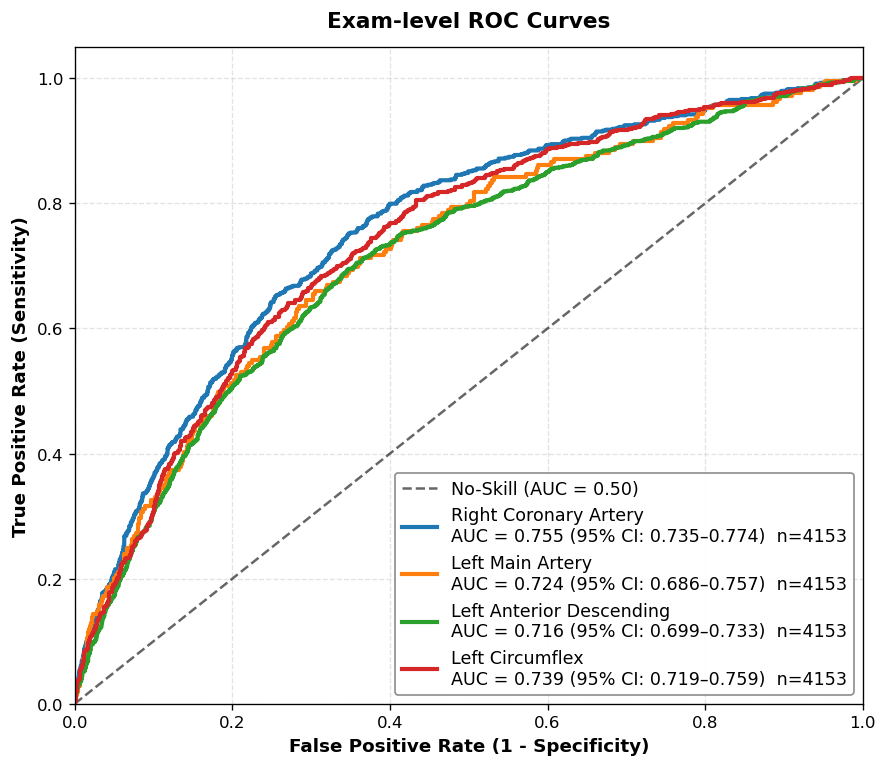

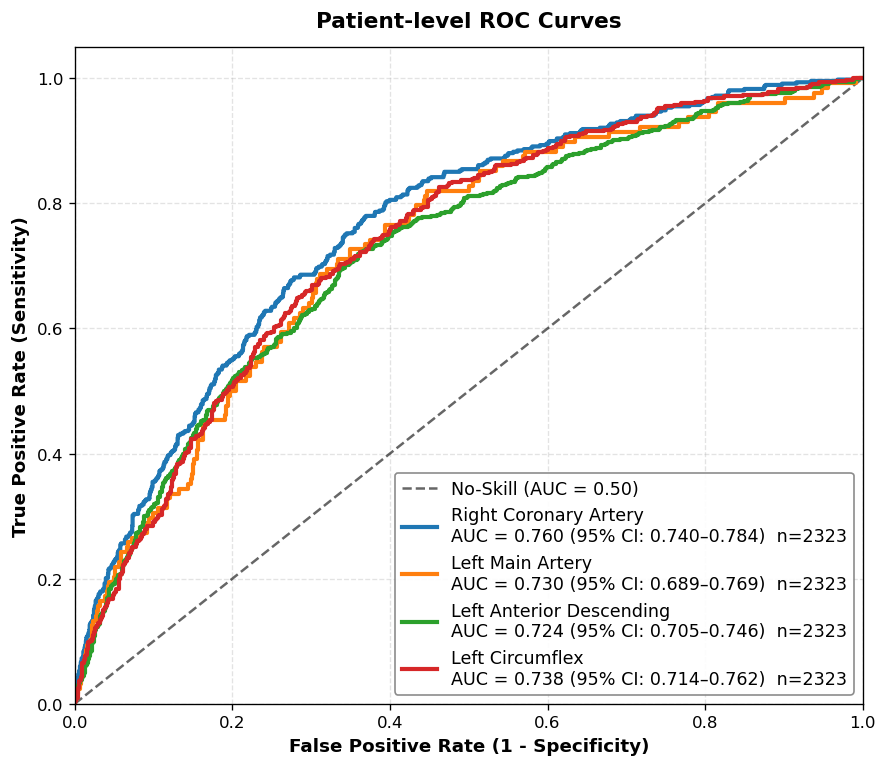

Saved figures:
/data2/2shared/xiaoyujie/冠脉造影/final/auc/ROC_check_vs_patient_exam_level.png
/data2/2shared/xiaoyujie/冠脉造影/final/auc/ROC_check_vs_patient_patient_level.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np


RESULTS_CSV_PATH = '/data2/2shared/xiaoyujie/冠脉造影/人民5折交叉验证/checkpoint_5fold_轻中度正常/oof_predictions_all_folds.csv'

PATIENT_ID_COL = '患者编号'
EXAM_TIME_COL  = '对应时间'
TIME_DIFF_COL  = '时间差天数'

LABEL_COLUMN_NAMES = [
    '右冠状动脉主干_诊断结果',
    '左冠状动脉主干_诊断结果',
    '左前降支_诊断结果',
    '左回旋支_诊断结果'
]

PROB_COLUMN_NAMES = [
    '右冠状动脉主干_prob',
    '左冠状动脉主干_prob',
    '左前降支_prob',
    '左回旋支_prob'
]

CLASS_NAMES_ENGLISH = [
    'Right Coronary Artery',
    'Left Main Artery',
    'Left Anterior Descending',
    'Left Circumflex'
]

NEGATIVE_CLASS_STRINGS_LIST = ["未见明显狭窄","轻度狭窄","中度狭窄"]

N_BOOTSTRAPS = 1000
CI_ALPHA = 0.95
SEED = 42

FIG_SAVE_PATH = '/data2/2shared/xiaoyujie/冠脉造影/final/auc/ROC_check_vs_patient.png'
DPI_SAVE = 900


def calculate_auc_ci(y_true, y_scores, n_bootstraps=1000, alpha=0.95, rng_seed=42):
    y_true = pd.Series(y_true).reset_index(drop=True)
    y_scores = pd.Series(y_scores).reset_index(drop=True)

    rng = np.random.RandomState(rng_seed)
    bootstrapped_scores = []

    n = len(y_scores)
    if n < 2:
        return np.nan, np.nan

    for _ in range(n_bootstraps):
        indices = rng.randint(0, n, n)
        if len(np.unique(y_true.iloc[indices])) < 2:
            continue
        fpr_b, tpr_b, _ = roc_curve(y_true.iloc[indices], y_scores.iloc[indices])
        bootstrapped_scores.append(auc(fpr_b, tpr_b))

    if len(bootstrapped_scores) == 0:
        return np.nan, np.nan

    sorted_scores = np.sort(np.array(bootstrapped_scores))
    lower_bound = np.percentile(sorted_scores, (1 - alpha) / 2 * 100)
    upper_bound = np.percentile(sorted_scores, (1 + alpha) / 2 * 100)
    return lower_bound, upper_bound



def filter_exam_level(df):

    required = [PATIENT_ID_COL, EXAM_TIME_COL, TIME_DIFF_COL]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"CSV 缺少必要列: {missing}")

    temp = df.copy()
    temp = temp.dropna(subset=[PATIENT_ID_COL, EXAM_TIME_COL, TIME_DIFF_COL])

    # idxmin(|时间差|)
    idx = temp.groupby([PATIENT_ID_COL, EXAM_TIME_COL])[TIME_DIFF_COL] \
              .apply(lambda x: x.abs().idxmin())
    temp = temp.loc[idx].reset_index(drop=True)
    return temp


def filter_patient_level(df_exam_level):

    temp = df_exam_level.copy()
    temp = temp.dropna(subset=[PATIENT_ID_COL, TIME_DIFF_COL])

    idx = temp.groupby(PATIENT_ID_COL)[TIME_DIFF_COL] \
              .apply(lambda x: x.abs().idxmin())
    temp = temp.loc[idx].reset_index(drop=True)
    return temp



def compute_roc_results(df_in):

    roc_results = {}

    for label_col, prob_col, class_name in zip(LABEL_COLUMN_NAMES, PROB_COLUMN_NAMES, CLASS_NAMES_ENGLISH):
        if label_col not in df_in.columns or prob_col not in df_in.columns:
            continue

        temp_df = df_in[[label_col, prob_col]].dropna()
        if len(temp_df) == 0:
            continue

        y_true = temp_df[label_col].apply(lambda x: 0 if x in NEGATIVE_CLASS_STRINGS_LIST else 1)
        y_scores = temp_df[prob_col].astype(float)

        if len(np.unique(y_true)) < 2:
            # 只有一个类别无法计算 ROC
            continue

        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        ci_low, ci_high = calculate_auc_ci(
            y_true, y_scores,
            n_bootstraps=N_BOOTSTRAPS,
            alpha=CI_ALPHA,
            rng_seed=SEED
        )

        roc_results[class_name] = {
            "fpr": fpr,
            "tpr": tpr,
            "auc": roc_auc,
            "ci_low": ci_low,
            "ci_high": ci_high,
        }

    return roc_results


df_raw = pd.read_csv(RESULTS_CSV_PATH)

df_exam = filter_exam_level(df_raw)
df_patient = filter_patient_level(df_exam)

print(f"[Raw rows]        {len(df_raw)}")
print(f"[Exam-level rows] {len(df_exam)}   (unique {PATIENT_ID_COL}+{EXAM_TIME_COL})")
print(f"[Patient-level]   {len(df_patient)} (unique {PATIENT_ID_COL})")

roc_exam = compute_roc_results(df_exam)
roc_patient = compute_roc_results(df_patient)

if (not roc_exam) and (not roc_patient):
    raise RuntimeError("两种级别都没有可用于绘图的有效 ROC 数据（可能标签只有单一类别或列名不匹配）。")


def plot_one_panel(ax, roc_results, title, subtitle=None):
    # 对角线
    ax.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.6, label='No-Skill (AUC = 0.50)')

    if not roc_results:
        ax.set_title(title if subtitle is None else f"{title}\n{subtitle}", fontsize=13, fontweight='bold')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=11, fontweight='bold')
        ax.set_ylabel('True Positive Rate (Sensitivity)', fontsize=11, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.35)
        return

    for idx, (class_name, res) in enumerate(roc_results.items()):
        color = colors[idx % len(colors)]
        auc_val = res["auc"]
        ci_low = res["ci_low"]
        ci_high = res["ci_high"]
        n = res["n"]

        if np.isnan(ci_low) or np.isnan(ci_high):
            label_str = f"{class_name}\nAUC = {auc_val:.3f} (CI: NA)  n={n}"
        else:
            label_str = f"{class_name}\nAUC = {auc_val:.3f} (95% CI: {ci_low:.3f}–{ci_high:.3f})  n={n}"

        ax.plot(res["fpr"], res["tpr"], lw=2.5, color=color, label=label_str)

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=11, fontweight='bold')
    ax.set_ylabel('True Positive Rate (Sensitivity)', fontsize=11, fontweight='bold')

    # ✅ 这里：subtitle=None 就只显示一行标题
    ax.set_title(title if subtitle is None else f"{title}\n{subtitle}",
                 fontsize=13, fontweight='bold', pad=12)

    ax.legend(loc="lower right", fontsize=10.5, frameon=True, framealpha=0.9, edgecolor='gray')
    ax.grid(True, linestyle='--', alpha=0.35)


# ===================================================================
# 6. 绘图：分别生成两张独立 ROC 图
# ===================================================================

plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']

# -------------------------
# 图 1：Exam-level ROC
# -------------------------
fig1, ax1 = plt.subplots(figsize=(7.5, 6.5), dpi=120)

plot_one_panel(
    ax1,
    roc_exam,
    "Exam-level ROC Curves"
)

plt.tight_layout()
plt.savefig(
    FIG_SAVE_PATH.replace(".png", "_exam_level.png"),
    dpi=DPI_SAVE
)
plt.show()


# -------------------------
# 图 2：Patient-level ROC
# -------------------------
fig2, ax2 = plt.subplots(figsize=(7.5, 6.5), dpi=120)

plot_one_panel(
    ax2,
    roc_patient,
    "Patient-level ROC Curves"
)

plt.tight_layout()
plt.savefig(
    FIG_SAVE_PATH.replace(".png", "_patient_level.png"),
    dpi=DPI_SAVE
)
plt.show()

print("Saved figures:")
print(FIG_SAVE_PATH.replace(".png", "_exam_level.png"))
print(FIG_SAVE_PATH.replace(".png", "_patient_level.png"))



[Exam-level rows] 4153
[Patient-level]   2323


Combined figure saved to: /data2/2shared/xiaoyujie/冠脉造影/final/auc/ROC_Combined_Exam_Patient.png


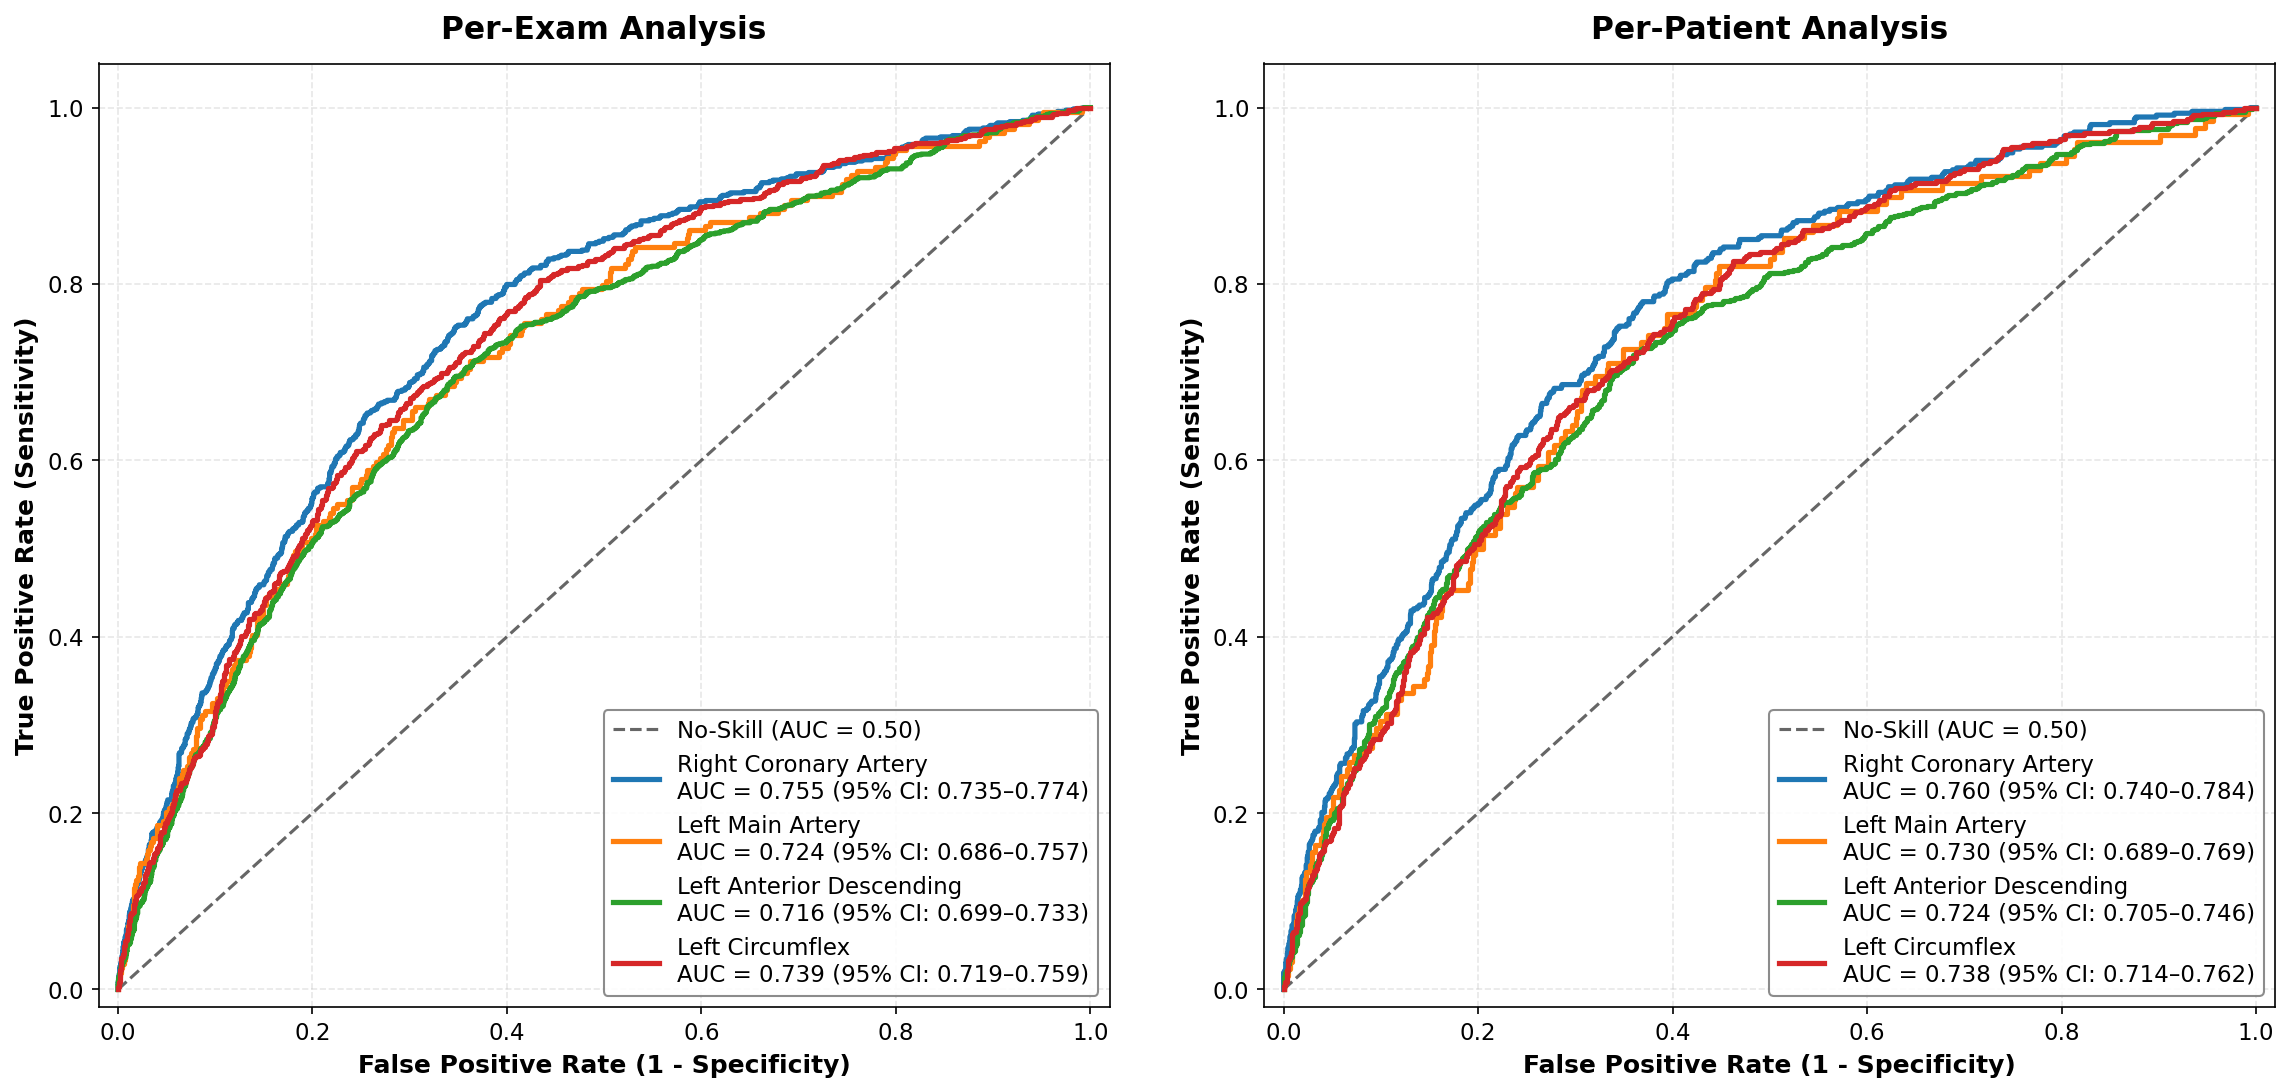

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
import os

# ==================== 配置 ====================

RESULTS_CSV_PATH = '/data2/2shared/xiaoyujie/冠脉造影/人民5折交叉验证/checkpoint_5fold_轻中度正常/oof_predictions_all_folds.csv'
FIG_SAVE_PATH = '/data2/2shared/xiaoyujie/冠脉造影/final/auc/ROC_Combined_Exam_Patient.png'
DPI_SAVE = 300 

PATIENT_ID_COL = '患者编号'
EXAM_TIME_COL  = '对应时间'
TIME_DIFF_COL  = '时间差天数'

LABEL_COLUMN_NAMES = [
    '右冠状动脉主干_诊断结果',
    '左冠状动脉主干_诊断结果',
    '左前降支_诊断结果',
    '左回旋支_诊断结果'
]

PROB_COLUMN_NAMES = [
    '右冠状动脉主干_prob',
    '左冠状动脉主干_prob',
    '左前降支_prob',
    '左回旋支_prob'
]

# 🟢 修改点：使用全称以匹配参考图例风格
CLASS_NAMES_ENGLISH = [
    'Right Coronary Artery',
    'Left Main Artery',
    'Left Anterior Descending',
    'Left Circumflex'
]

NEGATIVE_CLASS_STRINGS_LIST = ["未见明显狭窄","轻度狭窄","中度狭窄"]

N_BOOTSTRAPS = 1000
CI_ALPHA = 0.95
SEED = 42

# 颜色列表
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# ==================== 数据处理与计算函数 ====================

def calculate_auc_ci(y_true, y_scores, n_bootstraps=1000, alpha=0.95, rng_seed=42):
    y_true = pd.Series(y_true).reset_index(drop=True)
    y_scores = pd.Series(y_scores).reset_index(drop=True)
    
    rng = np.random.RandomState(rng_seed)
    bootstrapped_scores = []
    
    n = len(y_scores)
    if n < 2:
        return np.nan, np.nan
        
    for _ in range(n_bootstraps):
        indices = rng.randint(0, n, n)
        if len(np.unique(y_true.iloc[indices])) < 2:
            continue
        fpr_b, tpr_b, _ = roc_curve(y_true.iloc[indices], y_scores.iloc[indices])
        bootstrapped_scores.append(auc(fpr_b, tpr_b))
        
    if len(bootstrapped_scores) == 0:
        return np.nan, np.nan
        
    sorted_scores = np.sort(np.array(bootstrapped_scores))
    lower_bound = np.percentile(sorted_scores, (1 - alpha) / 2 * 100)
    upper_bound = np.percentile(sorted_scores, (1 + alpha) / 2 * 100)
    return lower_bound, upper_bound

def filter_exam_level(df):
    required = [PATIENT_ID_COL, EXAM_TIME_COL, TIME_DIFF_COL]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"CSV 缺少必要列: {missing}")
        
    temp = df.copy()
    temp = temp.dropna(subset=[PATIENT_ID_COL, EXAM_TIME_COL, TIME_DIFF_COL])
    idx = temp.groupby([PATIENT_ID_COL, EXAM_TIME_COL])[TIME_DIFF_COL] \
              .apply(lambda x: x.abs().idxmin())
    temp = temp.loc[idx].reset_index(drop=True)
    return temp

def filter_patient_level(df_exam_level):
    temp = df_exam_level.copy()
    temp = temp.dropna(subset=[PATIENT_ID_COL, TIME_DIFF_COL])
    idx = temp.groupby(PATIENT_ID_COL)[TIME_DIFF_COL] \
              .apply(lambda x: x.abs().idxmin())
    temp = temp.loc[idx].reset_index(drop=True)
    return temp

def compute_roc_results(df_in):
    roc_results = {}
    
    for label_col, prob_col, class_name in zip(LABEL_COLUMN_NAMES, PROB_COLUMN_NAMES, CLASS_NAMES_ENGLISH):
        if label_col not in df_in.columns or prob_col not in df_in.columns:
            continue
            
        temp_df = df_in[[label_col, prob_col]].dropna()
        if len(temp_df) == 0:
            continue
            
        y_true = temp_df[label_col].apply(lambda x: 0 if x in NEGATIVE_CLASS_STRINGS_LIST else 1)
        y_scores = temp_df[prob_col].astype(float)
        
        if len(np.unique(y_true)) < 2:
            continue
            
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        ci_low, ci_high = calculate_auc_ci(
            y_true, y_scores,
            n_bootstraps=N_BOOTSTRAPS,
            alpha=CI_ALPHA,
            rng_seed=SEED
        )
        
        roc_results[class_name] = {
            "fpr": fpr,
            "tpr": tpr,
            "auc": roc_auc,
            "ci_low": ci_low,
            "ci_high": ci_high
        }
        
    return roc_results

# ==================== 绘图函数 (更新格式) ====================

def plot_one_panel(ax, roc_results, title):
    # 🟢 修改点：对角线标签改为 No-Skill
    ax.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.6, label='No-Skill (AUC = 0.50)')
    
    if not roc_results:
        ax.text(0.5, 0.5, "Insufficient Data", ha='center', va='center')
        ax.set_title(title, fontsize=14, fontweight='bold')
        return

    for idx, (class_name, res) in enumerate(roc_results.items()):
        color = COLORS[idx % len(COLORS)]
        auc_val = res["auc"]
        ci_low = res["ci_low"]
        ci_high = res["ci_high"]
        
        # 🟢 核心修改点：图例格式改为两行，带 95% CI 文字
        if np.isnan(ci_low) or np.isnan(ci_high):
            label_str = f"{class_name}\nAUC = {auc_val:.3f} (95% CI: NA)"
        else:
            # 格式：Name \n AUC = 0.xxx (95% CI: 0.xxx–0.xxx)
            label_str = f"{class_name}\nAUC = {auc_val:.3f} (95% CI: {ci_low:.3f}–{ci_high:.3f})"
            
        ax.plot(res["fpr"], res["tpr"], lw=2.5, color=color, label=label_str)
        
    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.05]) # 稍微增加顶部空间以容纳较大的图例
    
    ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Positive Rate (Sensitivity)', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=15, fontweight='bold', pad=12)
    
    # 图例设置：调整字号适应子图
    ax.legend(loc="lower right", fontsize=11, frameon=True, framealpha=0.9, edgecolor='gray')
    ax.grid(True, linestyle='--', alpha=0.3)

# ==================== 主程序 ====================

# 1. 读取与处理数据
df_raw = pd.read_csv(RESULTS_CSV_PATH)
df_exam = filter_exam_level(df_raw)
df_patient = filter_patient_level(df_exam)

print(f"[Exam-level rows] {len(df_exam)}")
print(f"[Patient-level]   {len(df_patient)}")

# 2. 计算 ROC 统计量
roc_exam = compute_roc_results(df_exam)
roc_patient = compute_roc_results(df_patient)

if (not roc_exam) and (not roc_patient):
    raise RuntimeError("无有效绘图数据。")

# 3. 绘制左右子图 (1行2列)
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 稍微调高高度，因为图例变高了
fig, axes = plt.subplots(1, 2, figsize=(16, 8), dpi=150)

# 左图：Exam Level
plot_one_panel(axes[0], roc_exam, "Per-Exam Analysis")

# 右图：Patient Level
plot_one_panel(axes[1], roc_patient, "Per-Patient Analysis")

plt.tight_layout(pad=3.0)

# 保存
os.makedirs(os.path.dirname(FIG_SAVE_PATH), exist_ok=True)
plt.savefig(FIG_SAVE_PATH, dpi=DPI_SAVE)
print(f"Combined figure saved to: {FIG_SAVE_PATH}")

plt.show()